<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

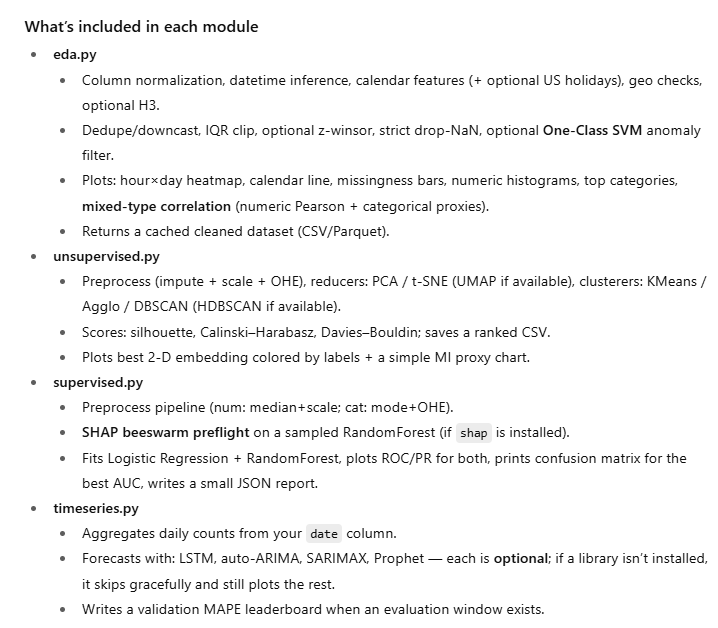



🔹 In Unsupervised

Gaussian Mixture Models (GMM / EM) (fits lecture notes).

Spectral Clustering (covered in the book, sec. 12.4).

Stability analysis (bootstrap clustering stability).

Cluster profiling (compare means/proportions of features across clusters).

Anomaly detection extension (tie clusters + outliers to highlight rare cases).

🔹 In Time Series

Compare ARIMA, Prophet, LSTM (classical + deep).

Stationarity tests (ADF, KPSS).

Hyperparameter grid search (p,d,q,P,D,Q).

Cross-validation with rolling/expanding window (instead of single split).

MAPE, RMSE, MAE metrics with plots.

🔹 In General (Report & Code)

Train/validation/test split explanation (required).

Overfitting prevention: dropout, early stopping, regularization.

Hyperparameter tuning process (grid/random search, report best params).

Runtime/complexity discussion (iterations, convergence speed).

Clear comparison tables for supervised & unsupervised results.

Visuals:

Calendar heatmaps (crime over time)

Spatial density plots (hexbin, ridgelines)

Cluster embedding plots

In [1]:
!pip install scikit-learn imbalanced-learn statsmodels seaborn holidays h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00


In [2]:
from eda import run_eda

In [3]:
from supervised import quick_demo

In [4]:
from unsupervised import run_unsupervised

In [ ]:
from timeseries import run_timeseries

#Fast EDA

SMART LAPD DATA PROCESSING PIPELINE

1. Loading raw data...
Raw shape: (974477, 15)
Dropped 0 completely empty rows

2. Creating time-based features...
Using time column: Time_occured
Extracting hours from column: 'Time_occured'
Sample values: [2130, 1800, 1700, 2037, 1200]
Successfully extracted hours from 934971/974477 rows (95.9%)

Hour distribution (count and night rate):
      count  mean
hour             
1.0   29003   1.0
2.0   24572   1.0
3.0   21610   1.0
4.0   18281   1.0
5.0   16839   1.0
6.0   22393   1.0
7.0   25356   0.0
8.0   36142   0.0
9.0   35418   0.0
10.0  41737   0.0
11.0  42361   0.0
12.0  65775   0.0
13.0  44171   0.0
14.0  47749   0.0
15.0  51101   0.0
16.0  51345   0.0
17.0  56936   0.0
18.0  58043   0.0
19.0  53816   0.0
20.0  54491   0.0
21.0  49259   0.0
22.0  47571   1.0
23.0  41002   1.0
Night target created: 221271 night crimes, 753206 day crimes

3. Preparing victim sex for stratification...
Found victim sex column: Victim_sex
Victim sex distribution aft

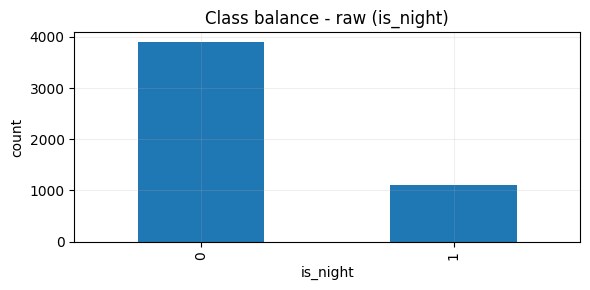

preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---raw.png


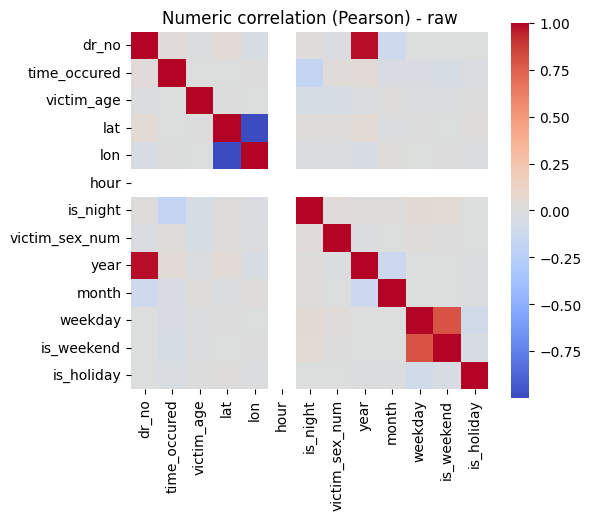

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---raw.png


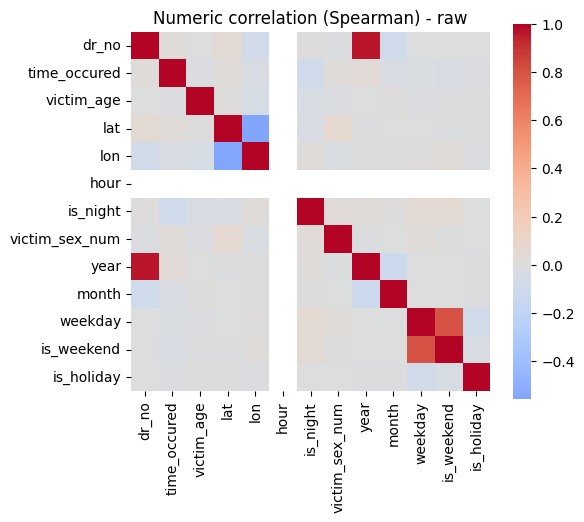

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---raw.png


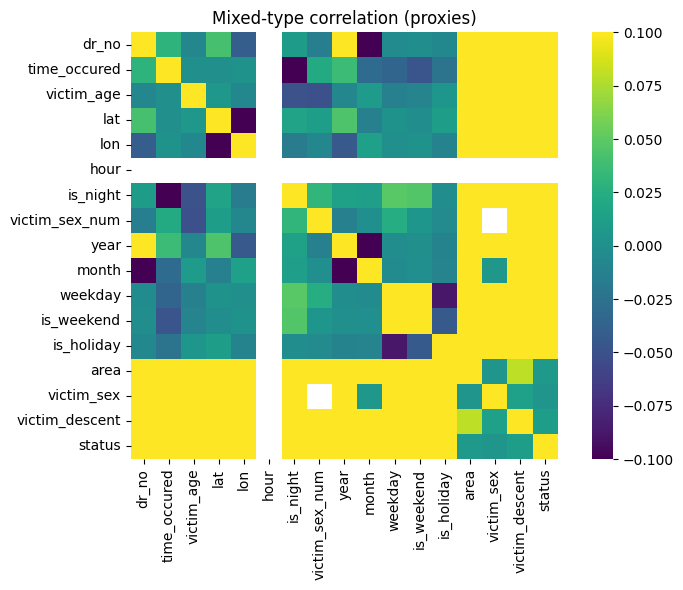

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---raw.png


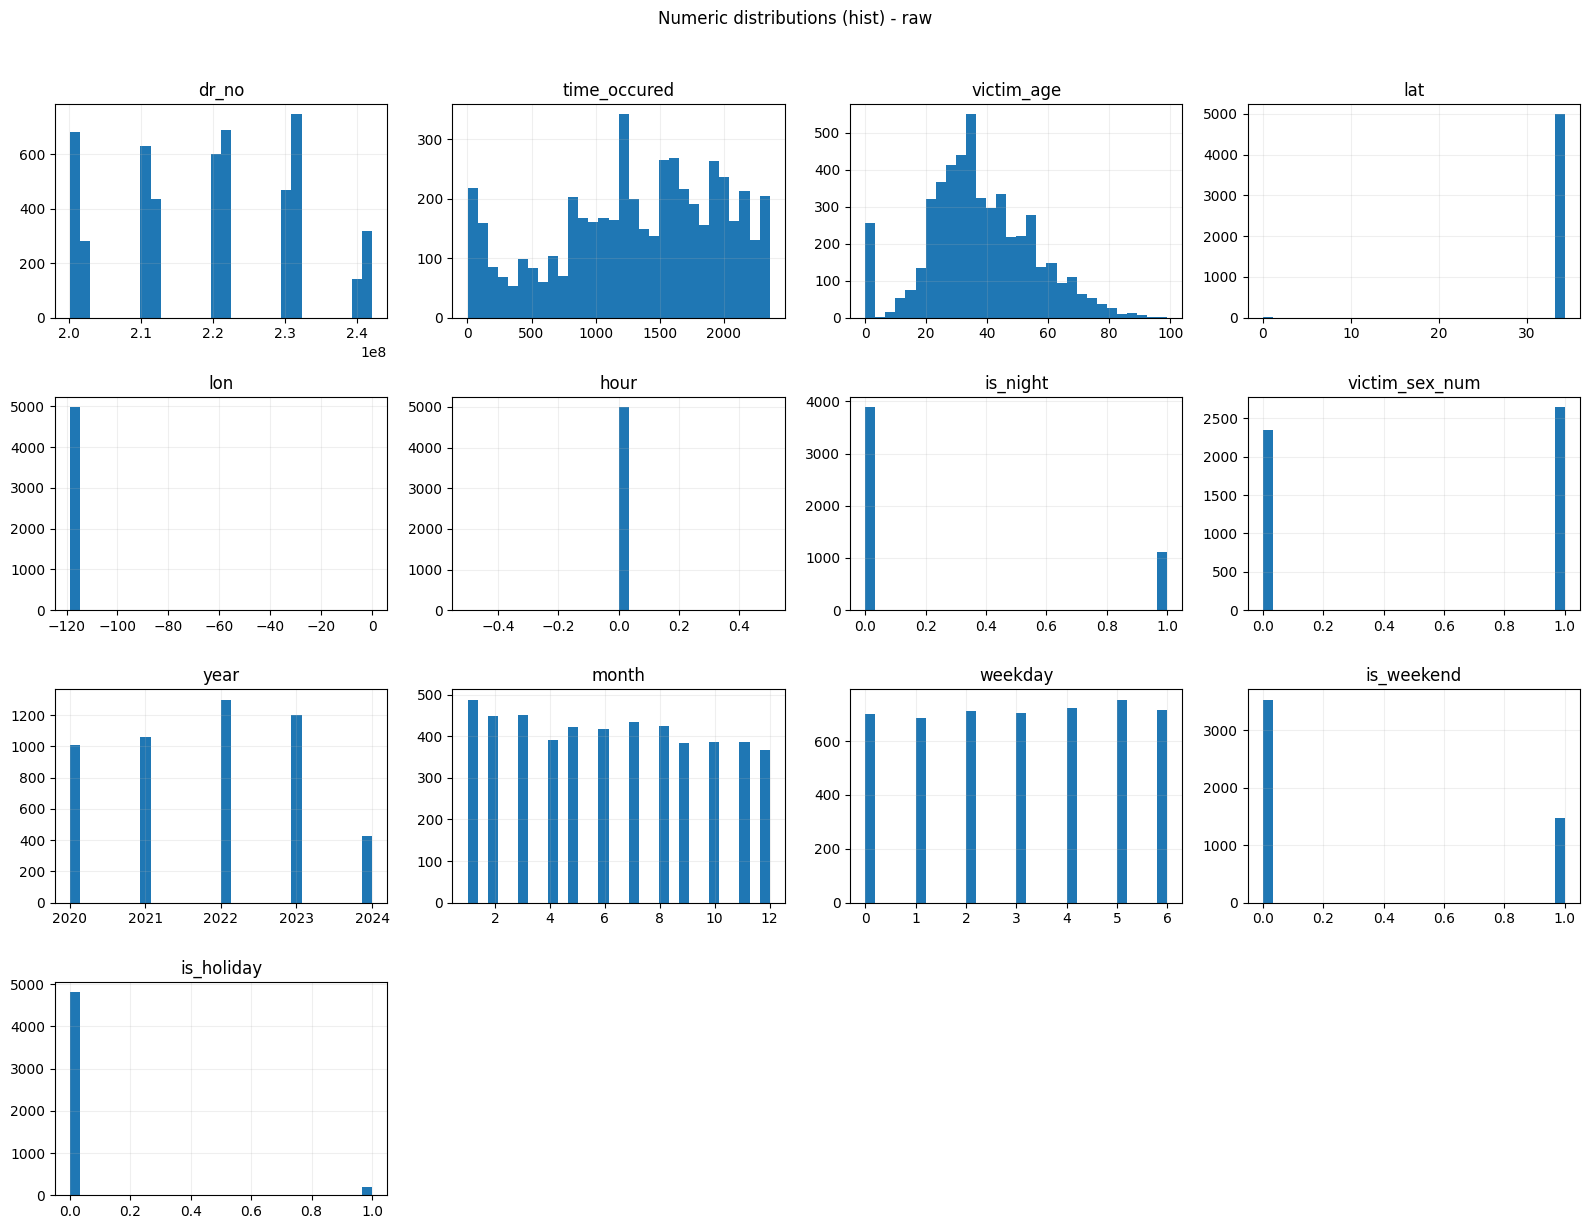

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
              issue  count
0  zero_zero_coords     13
1   outside_LA_bbox     13
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 99 / 4,999 rows
[LOF] flagged 98 / 4,900 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda/Missingness---cleaned.png


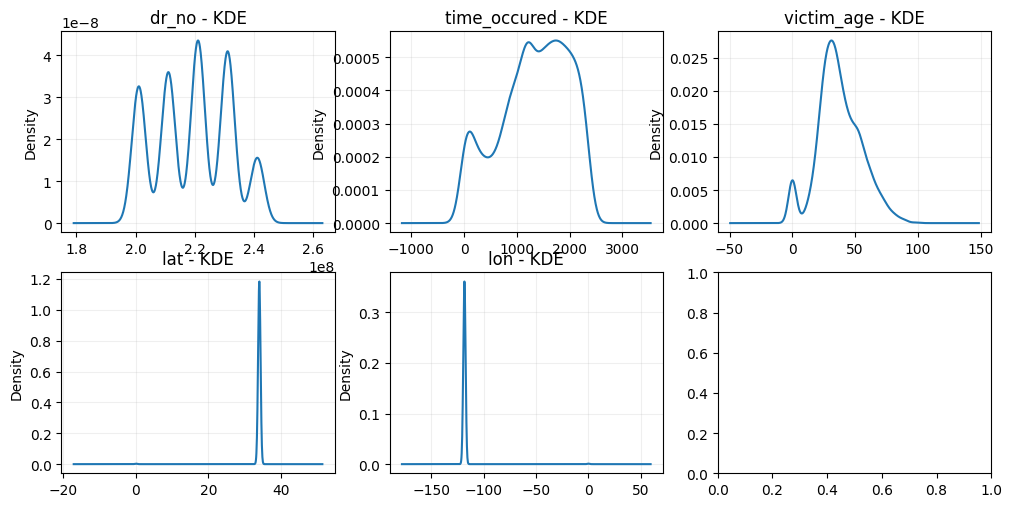

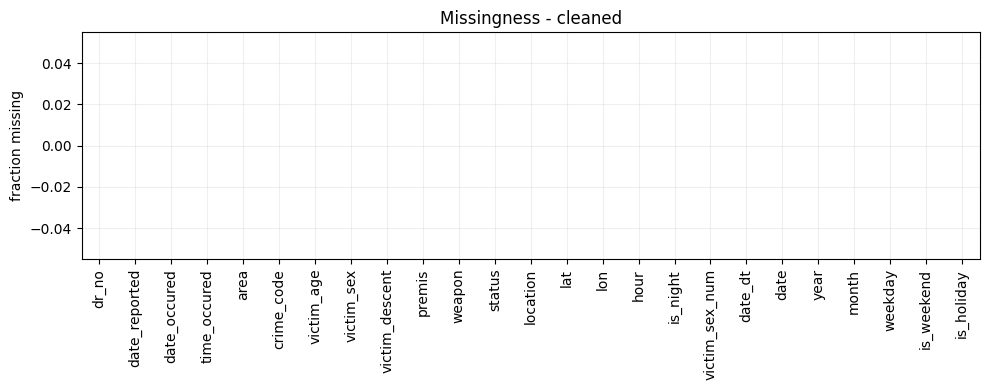

🗂️ saved: /content/figs_eda/Missingness-matrix---cleaned.png


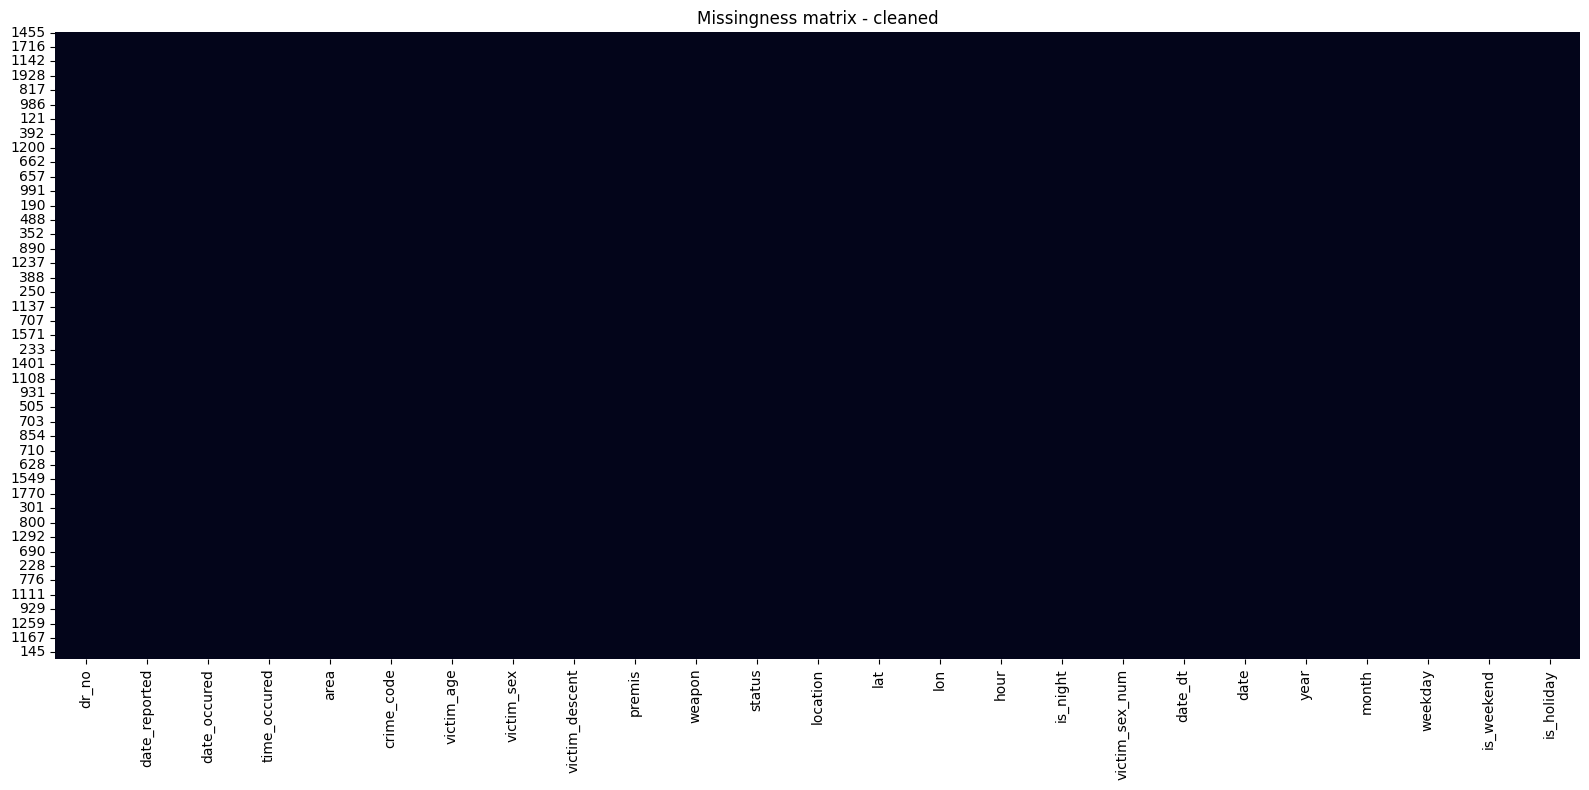

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---cleaned.png


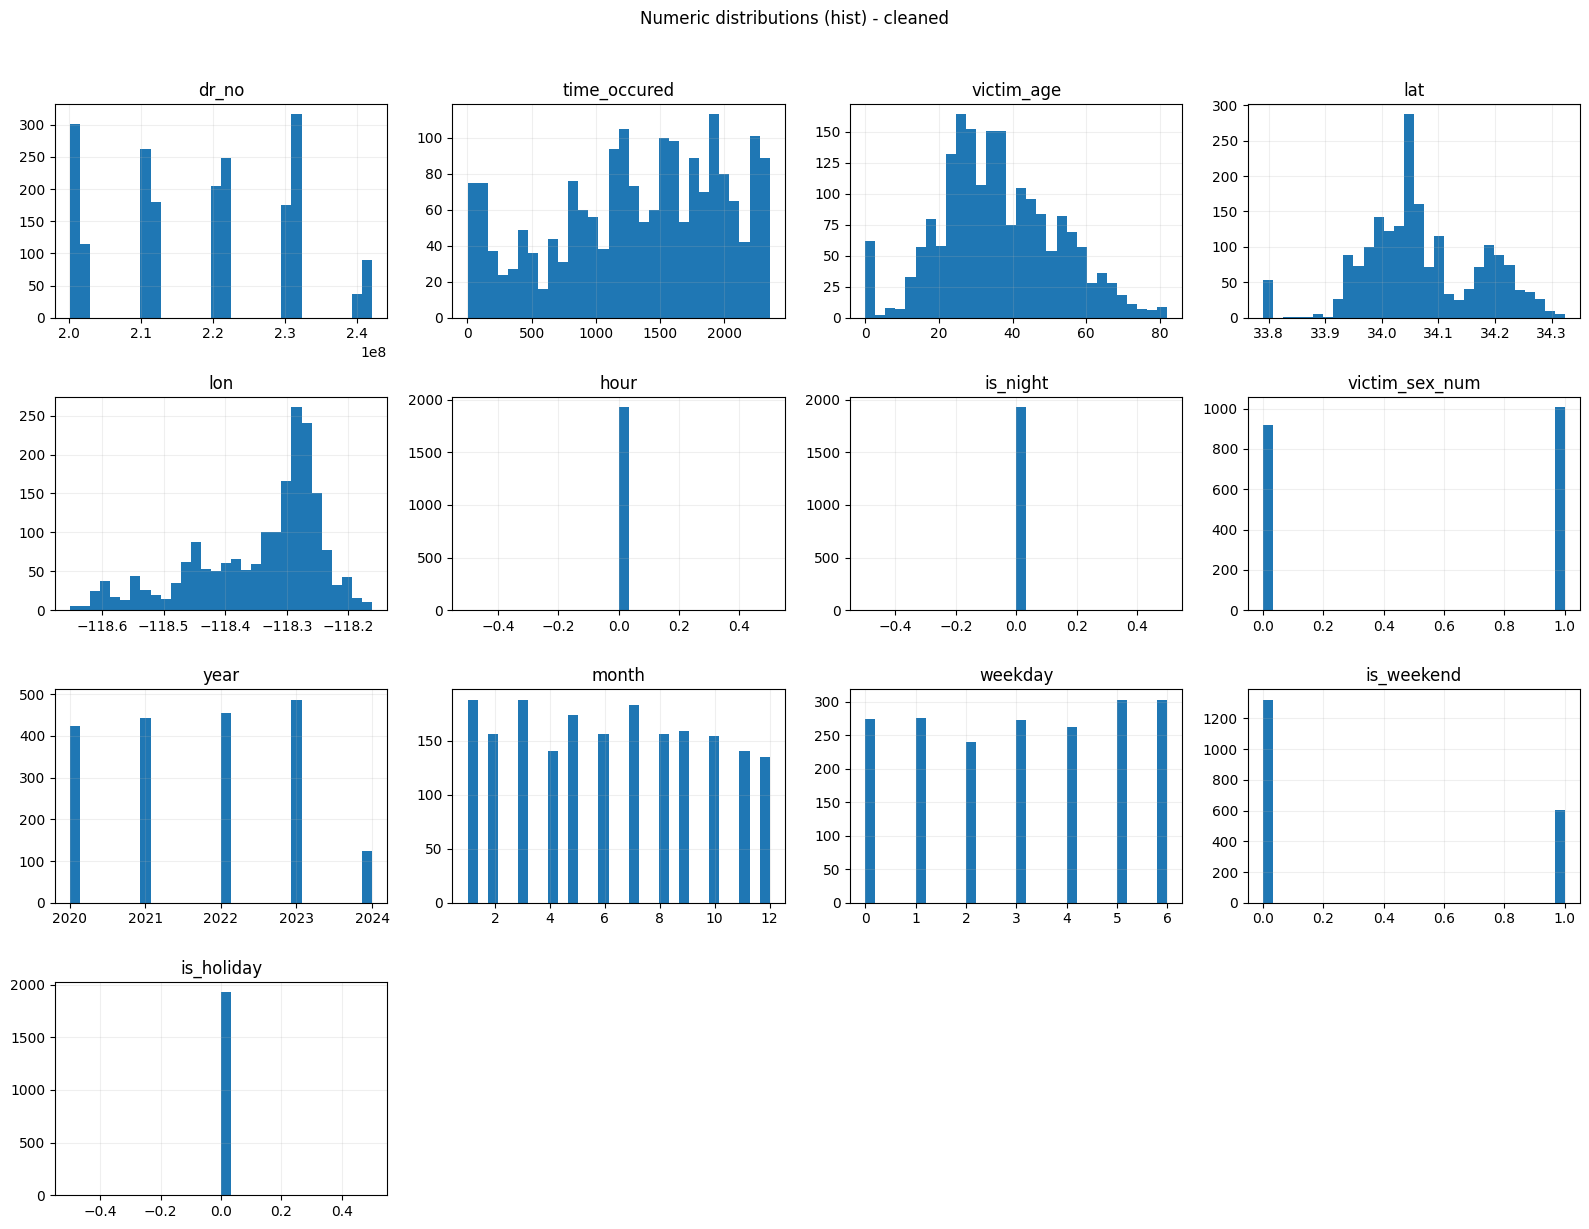

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---cleaned.png


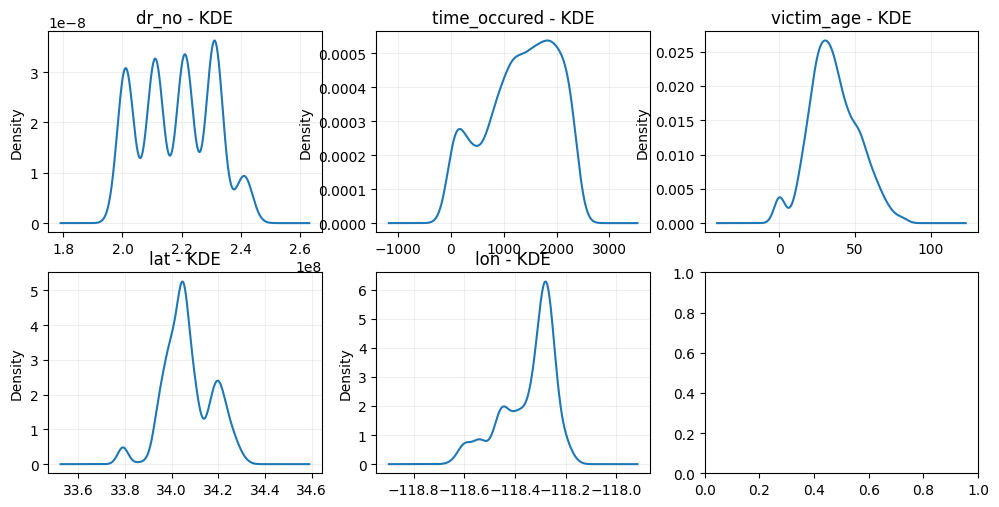

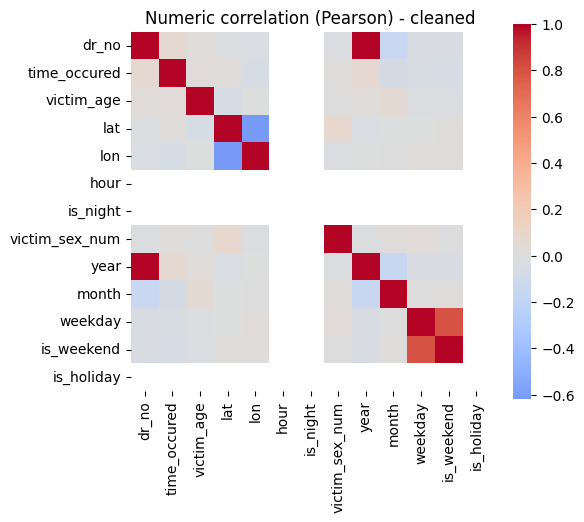

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---cleaned.png


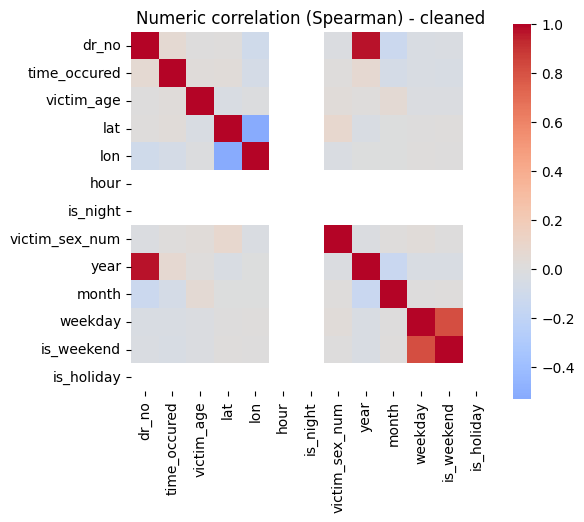

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---cleaned.png


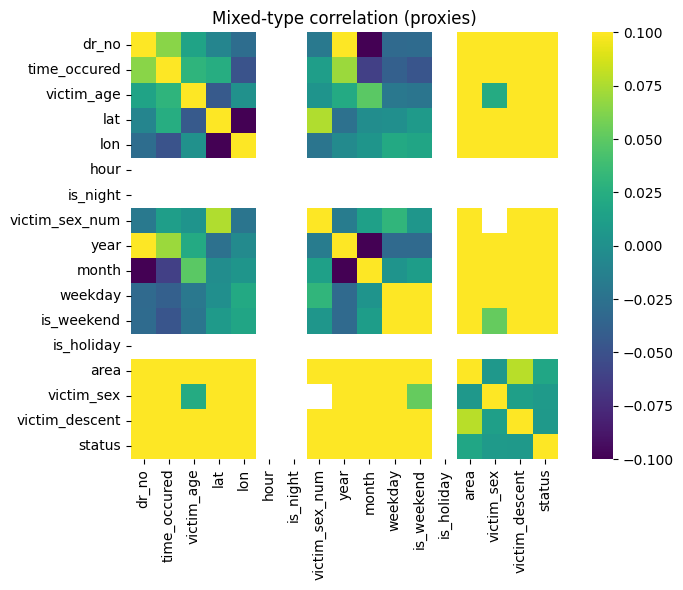

SMOTE failed; falling back to undersample: The target 'y' needs to have more than 1 class. Got 1 class instead
[Balance] target has <2 classes; skip.
🗂️ saved: /content/figs_eda/Mutual-Information-vs-is_night.png


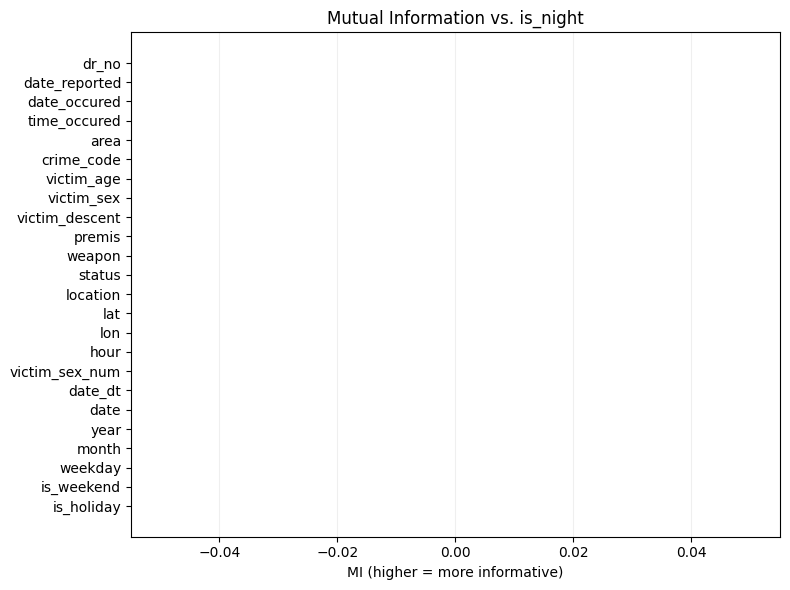

🗂️ saved: /content/figs_eda/RF-feature-importance.png


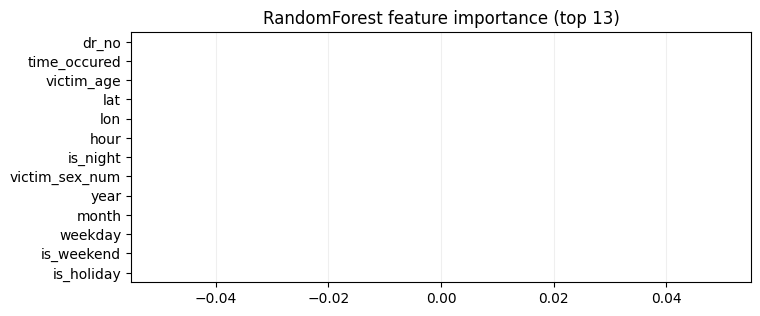

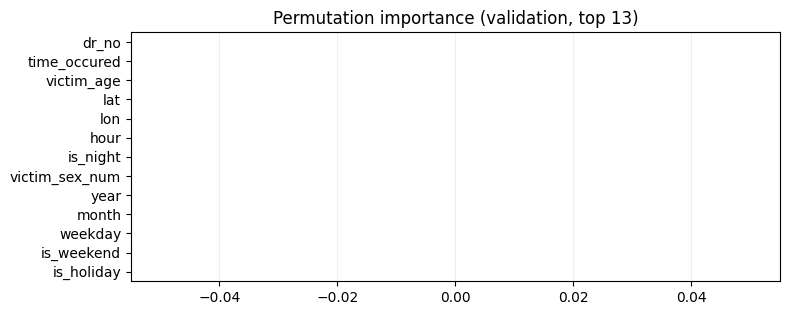

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean_final.parquet

Final dataset shape: (1929, 25)
Night distribution: {0.0: 1929}
Victim sex distribution: {1.0: 1008, 0.0: 921}
Final sample saved: /content/lapd_sample.parquet

PIPELINE COMPLETE


In [5]:
import pandas as pd
import numpy as np
from eda import run_eda
import os

# Configuration
SAMPLE_SIZE = 5000
RANDOM_STATE = 42
RAW_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
OUTPUT_DIR = "/content"

# Single EDA configuration - no duplicates
EDA_CONFIG = {
    "use_us_holidays": True,
    "add_h3": False,
    "iqr_clip": True,
    "iqr_multiplier": 1.5,
    "zscore_winsor": True,
    "zscore_max": 4.0,
    "drop_any_nan_after_features": True,
    "imbalance_target": "is_night",  # Set directly since we'll create it
    "balance_preview": True,
    "balance_method": "smote",
    "balance_max_n": 20000,
    "corr_pearson": True,
    "corr_spearman": True,
    "corr_mutual_info": True,
    "feature_importance": True,
    "plot_numeric_dists": True,
    "plot_kde_box": True,
    "missing_matrix": True,
    "outliers_iforest": True,
    "outliers_lof": True,
    "outliers_ocsvm": True,
    "outliers_max_frac": 0.02,
    "plot_corr": True,
    "vif_check": True,
}


def extract_hour_from_time(time_str):
    """
    Extract hour from various time formats.
    Handles: "1430" (24h), "14:30", "2:30 PM", etc.
    """
    if pd.isna(time_str):
        return np.nan

    time_str = str(time_str).strip()

    # Handle 24-hour format without colons (e.g., "1430")
    if time_str.isdigit() and len(time_str) >= 3:
        if len(time_str) == 3:  # e.g., "730" -> "07:30"
            hour = int(time_str[0])
        elif len(time_str) == 4:  # e.g., "1430" -> "14:30"
            hour = int(time_str[:2])
        else:
            return np.nan
        return hour if 0 <= hour <= 23 else np.nan

    # Handle formats with colons or AM/PM
    try:
        # Try parsing with pandas
        parsed_time = pd.to_datetime(time_str, format='%H:%M', errors='coerce')
        if pd.notna(parsed_time):
            return parsed_time.hour

        # Try with AM/PM
        parsed_time = pd.to_datetime(time_str, format='%I:%M %p', errors='coerce')
        if pd.notna(parsed_time):
            return parsed_time.hour

        # Try just hour extraction from various formats
        if ':' in time_str:
            hour_part = time_str.split(':')[0]
            if 'PM' in time_str.upper() or 'AM' in time_str.upper():
                hour = int(hour_part)
                if 'PM' in time_str.upper() and hour != 12:
                    hour += 12
                elif 'AM' in time_str.upper() and hour == 12:
                    hour = 0
                return hour if 0 <= hour <= 23 else np.nan
            else:
                hour = int(hour_part)
                return hour if 0 <= hour <= 23 else np.nan

    except (ValueError, IndexError):
        pass

    return np.nan


def create_night_target(df):
    """
    Create is_night target with proper hour extraction and night definition.
    Night hours: 10 PM to 6 AM (22:00 to 06:00)
    """
    # Find time column - common names in LAPD data
    time_cols = ['TIME OCC', 'time_occ', 'time', 'Time', 'TIME']
    time_col = None

    for col in time_cols:
        if col in df.columns:
            time_col = col
            break

    if time_col is None:
        # Try to find any column with 'time' in name
        time_candidates = [col for col in df.columns if 'time' in col.lower()]
        if time_candidates:
            time_col = time_candidates[0]
            print(f"Using time column: {time_col}")

    if time_col is None:
        raise ValueError("No time column found. Available columns: " + str(list(df.columns)))

    print(f"Extracting hours from column: '{time_col}'")
    print(f"Sample values: {df[time_col].head().tolist()}")

    # Extract hours
    df['hour'] = df[time_col].apply(extract_hour_from_time)

    # Check extraction success
    valid_hours = df['hour'].notna().sum()
    total_rows = len(df)
    print(f"Successfully extracted hours from {valid_hours}/{total_rows} rows ({valid_hours/total_rows*100:.1f}%)")

    if valid_hours < total_rows * 0.5:
        print(f"Warning: Only extracted valid hours from {valid_hours/total_rows*100:.1f}% of rows")
        print("Sample failed extractions:")
        failed_sample = df[df['hour'].isna()][time_col].head()
        print(failed_sample.tolist())

    # Create night target: 10 PM (22:00) to 6 AM (06:00)
    # This is more realistic than 8 PM to 6 AM
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

    # Show hour distribution
    if df['hour'].notna().any():
        hour_dist = df.groupby('hour')['is_night'].agg(['count', 'mean']).round(3)
        print("\nHour distribution (count and night rate):")
        print(hour_dist)

    return df


def find_victim_sex_column(df):
    """Find victim sex column with various naming conventions."""
    sex_aliases = [
        'vict sex', 'vict_sex', 'victim_sex', 'victim sex',
        'victimsex', 'sex', 'gender', 'vict_gender'
    ]

    # Exact match first
    for alias in sex_aliases:
        if alias in df.columns:
            return alias

    # Case-insensitive partial match
    for col in df.columns:
        col_lower = col.lower().replace(' ', '_')
        for alias in sex_aliases:
            alias_clean = alias.lower().replace(' ', '_')
            if alias_clean in col_lower or col_lower in alias_clean:
                return col

    return None


def clean_victim_sex(df, sex_col):
    """Clean and standardize victim sex values."""
    if sex_col not in df.columns:
        return df

    # Standardize values
    df[sex_col] = (
        df[sex_col]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({
            'U': 'UNKNOWN', 'X': 'UNKNOWN', '-': 'UNKNOWN',
            'N': 'UNKNOWN', '': 'UNKNOWN', 'NAN': 'UNKNOWN',
            'MALE': 'M', 'FEMALE': 'F'
        })
    )

    print(f"Victim sex distribution after cleaning:\n{df[sex_col].value_counts()}")
    return df


def create_stratified_sample(df, stratify_col, sample_size, random_state=42):
    """Create stratified sample maintaining proportions."""
    if len(df) <= sample_size:
        return df.copy()

    # Calculate proportional sample sizes
    value_counts = df[stratify_col].value_counts()
    total = len(df)

    sampled_parts = []
    remaining_budget = sample_size

    for value, count in value_counts.items():
        if remaining_budget <= 0:
            break

        # Proportional allocation with minimum 1
        target_n = max(1, int((count / total) * sample_size))
        actual_n = min(target_n, count, remaining_budget)

        subset = df[df[stratify_col] == value].sample(n=actual_n, random_state=random_state)
        sampled_parts.append(subset)
        remaining_budget -= actual_n

    result = pd.concat(sampled_parts, ignore_index=True)

    # Shuffle the final result
    return result.sample(frac=1.0, random_state=random_state).reset_index(drop=True)


def main():
    """Main processing pipeline."""
    print("=" * 60)
    print("SMART LAPD DATA PROCESSING PIPELINE")
    print("=" * 60)

    # 1. Load and initial cleaning
    print("\n1. Loading raw data...")
    df = pd.read_csv(RAW_PATH, low_memory=False, compression='infer')
    print(f"Raw shape: {df.shape}")

    # Clean missing values
    missing_sentinels = ["", " ", "NA", "N/A", "na", "n/a", "None", "NONE",
                        "null", "NULL", "?", "-", "--", "nan", "NaN"]
    df = df.replace(missing_sentinels, np.nan)

    # Drop rows with all missing values
    before_drop = len(df)
    df = df.dropna(how='all').reset_index(drop=True)
    print(f"Dropped {before_drop - len(df):,} completely empty rows")

    # 2. Create hour and night target BEFORE EDA
    print("\n2. Creating time-based features...")
    try:
        df = create_night_target(df)
        night_counts = df['is_night'].value_counts()
        print(f"Night target created: {night_counts[1]} night crimes, {night_counts[0]} day crimes")
    except Exception as e:
        print(f"Failed to create night target: {e}")
        return

    # 3. Clean victim sex for stratification
    print("\n3. Preparing victim sex for stratification...")
    sex_col = find_victim_sex_column(df)
    if sex_col:
        print(f"Found victim sex column: {sex_col}")
        df = clean_victim_sex(df, sex_col)

        # Create numeric version for ML
        df['victim_sex_num'] = df[sex_col].map({'F': 0, 'M': 1})
        mf_only = df[df[sex_col].isin(['M', 'F'])].copy()
        print(f"Rows with M/F victim sex: {len(mf_only):,}")
    else:
        print("Warning: No victim sex column found")
        mf_only = df.copy()
        sex_col = None

    # 4. Create stratified sample BEFORE EDA to save time
    print(f"\n4. Creating stratified sample...")
    if len(mf_only) > SAMPLE_SIZE and sex_col:
        df_sample = create_stratified_sample(mf_only, sex_col, SAMPLE_SIZE, RANDOM_STATE)
        print(f"Sample shape: {df_sample.shape}")
        if sex_col:
            print(f"Sample sex distribution:\n{df_sample[sex_col].value_counts()}")
    else:
        df_sample = mf_only.copy()
        print(f"Using full dataset: {df_sample.shape}")

    # Save intermediate sample
    temp_csv = os.path.join(OUTPUT_DIR, "temp_sample_with_target.csv")
    df_sample.to_csv(temp_csv, index=False)

    # 5. Run EDA once on the sample with target
    print(f"\n5. Running EDA on sample with target...")
    clean_path = run_eda(
        raw_csv_path=temp_csv,
        fig_dir=os.path.join(OUTPUT_DIR, "figs_eda"),
        cache_path=os.path.join(OUTPUT_DIR, "lapd_clean_final.parquet"),
        config_overrides=EDA_CONFIG
    )

    # 6. Final output
    final_df = pd.read_parquet(clean_path)
    print(f"\nFinal dataset shape: {final_df.shape}")

    # Verify targets exist
    if 'is_night' in final_df.columns:
        print(f"Night distribution: {final_df['is_night'].value_counts().to_dict()}")
    if 'victim_sex_num' in final_df.columns:
        print(f"Victim sex distribution: {final_df['victim_sex_num'].value_counts().to_dict()}")

    # Save final sample for ML
    sample_output = os.path.join(OUTPUT_DIR, "lapd_sample.parquet")
    final_df.to_parquet(sample_output, index=False)
    print(f"Final sample saved: {sample_output}")

    # Cleanup
    if os.path.exists(temp_csv):
        os.remove(temp_csv)

    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    return clean_path


if __name__ == "__main__":
    main()

# EDA

==== [RUNNER] Read CSV/ZIP & strict full-row drop ====
[Runner] Raw shape: (974477, 15)
[Runner] Strict dropna removed 648,974 rows; remaining 325,503.
[Runner] Post-drop shape: (325503, 15)

Running comprehensive EDA pipeline on strictly-complete data...
==== [EDA-1] Read CSV/ZIP ====
Using date column: Date_occured
shape: (325503, 22)
==== [EDA-2] Normalize column names ====
==== [EDA-3] Build datetime + add time features ====
preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---raw.png


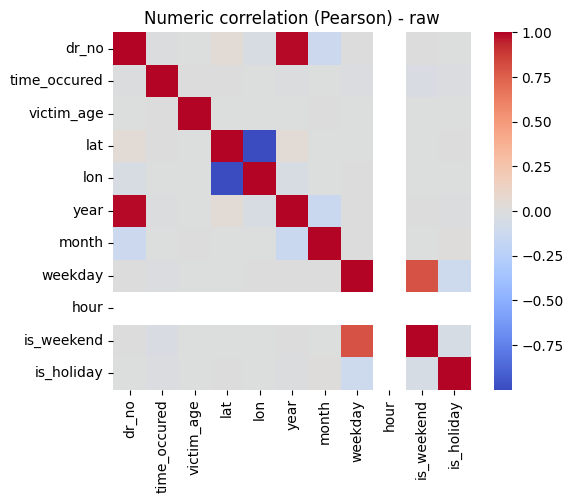

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---raw.png


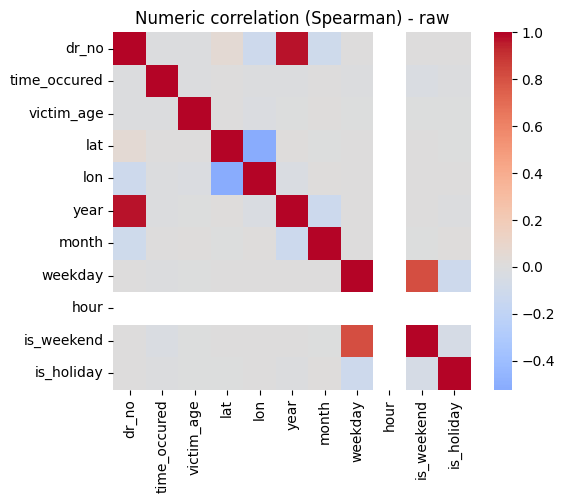

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---raw.png


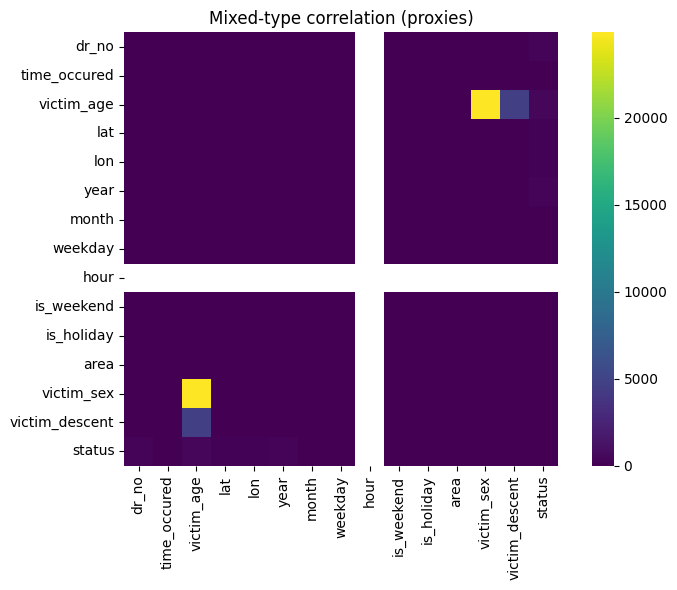

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---raw.png


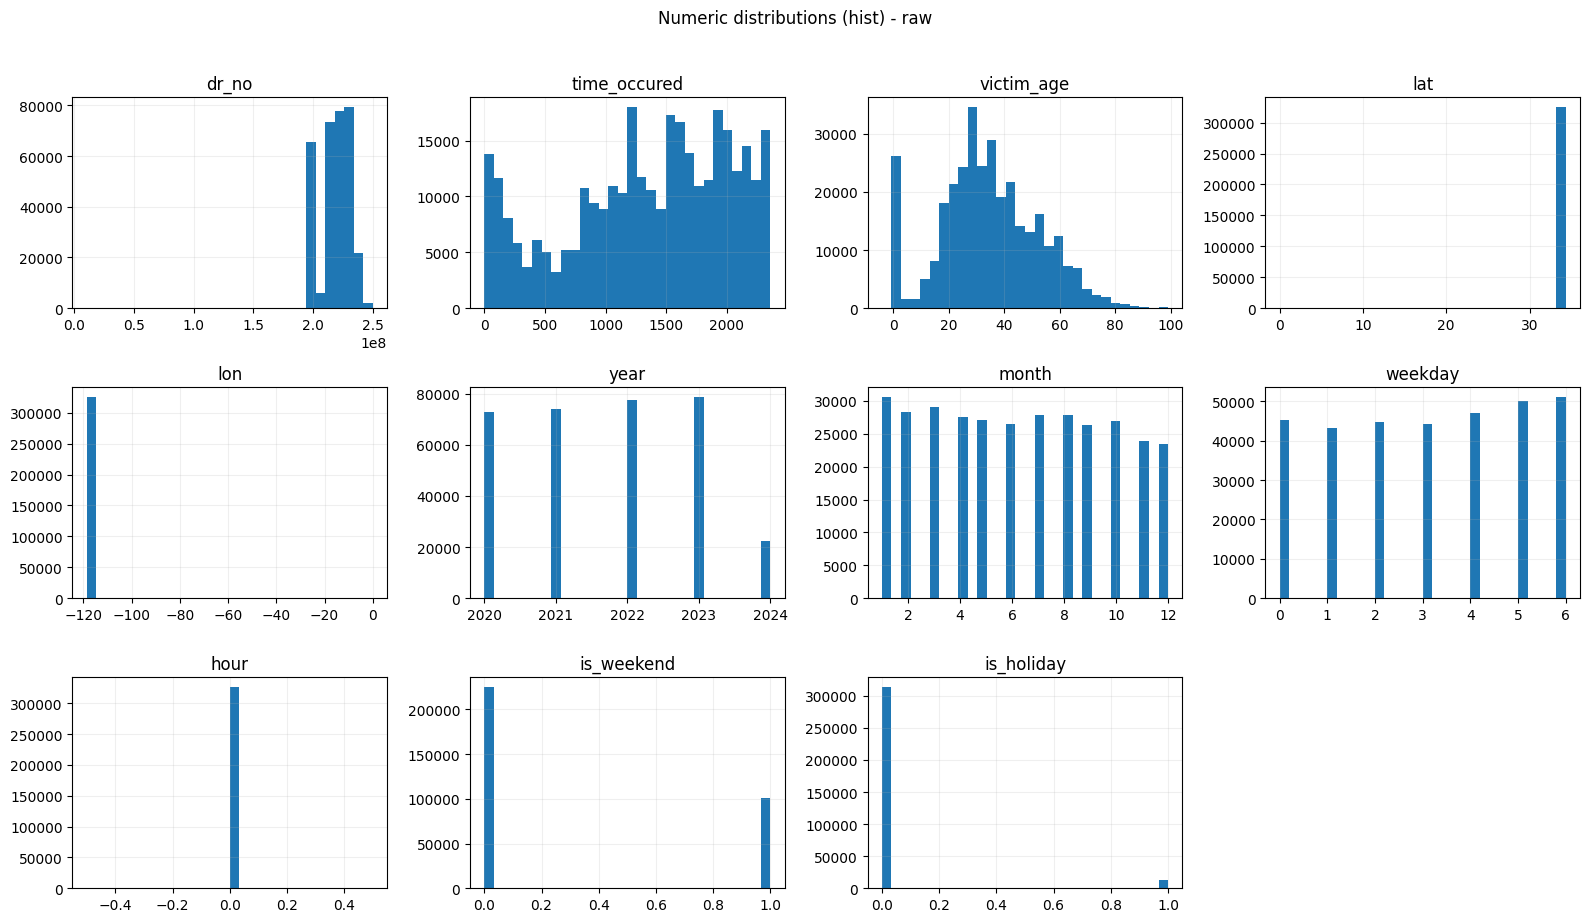

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
              issue  count
0  zero_zero_coords    833
1   outside_LA_bbox    833
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 6,510 / 325,503 rows
[LOF] flagged 6,379 / 318,993 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda/Missingness---cleaned.png


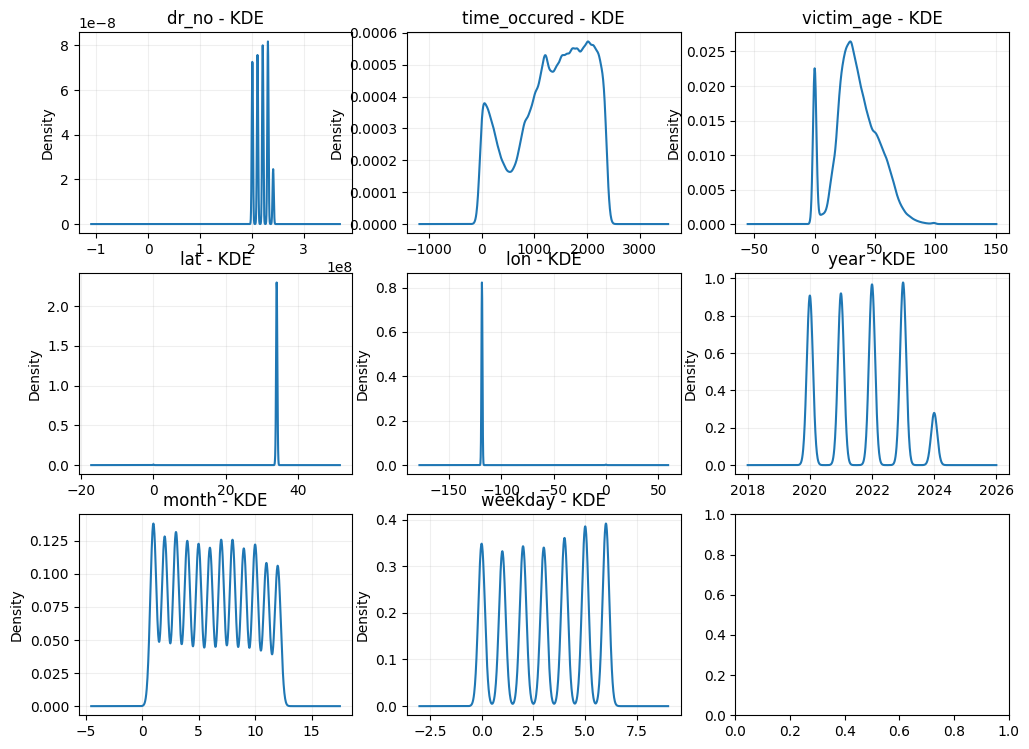

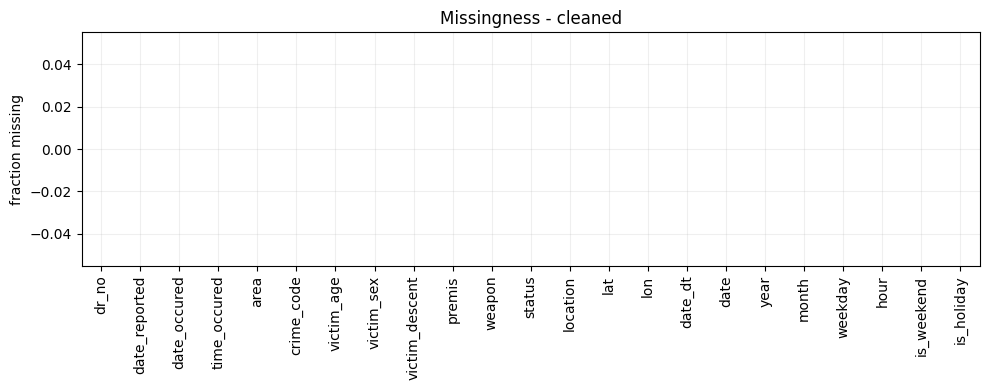

🗂️ saved: /content/figs_eda/Missingness-matrix---cleaned.png


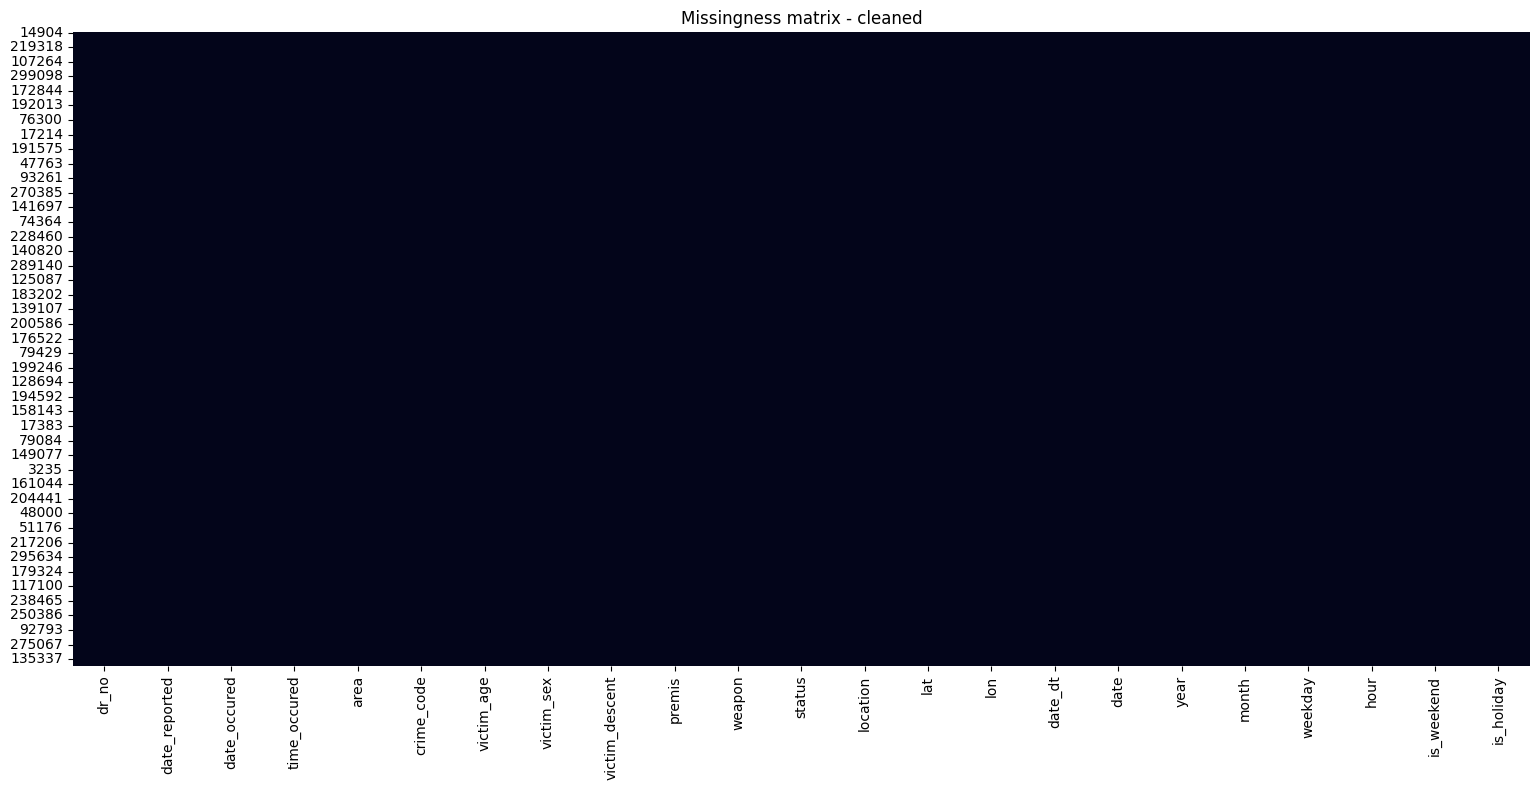

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---cleaned.png


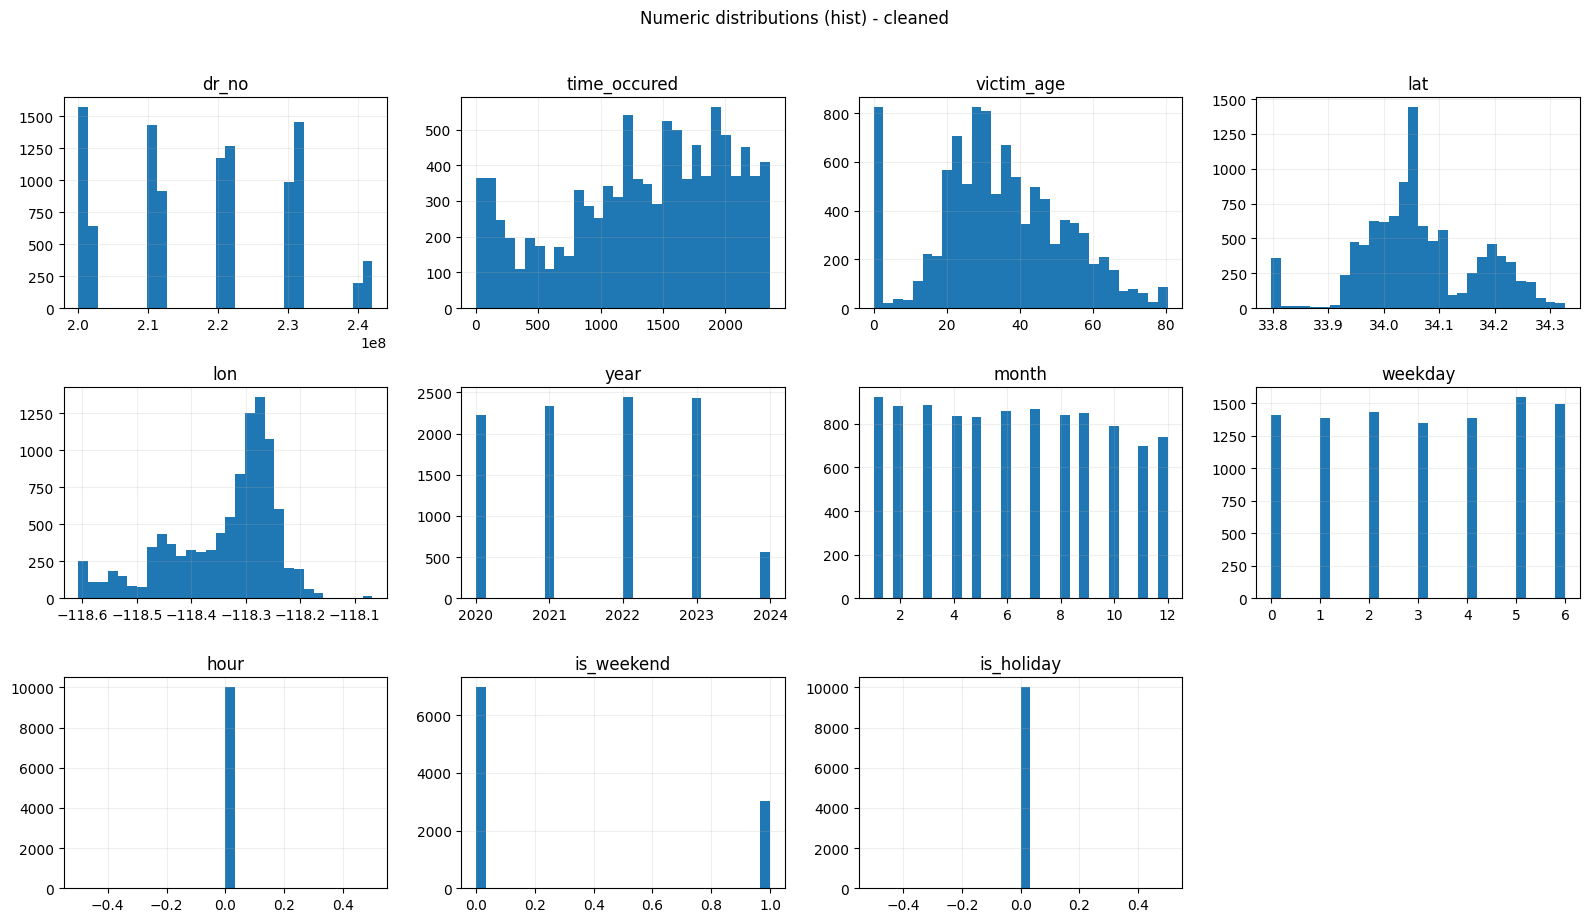

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---cleaned.png


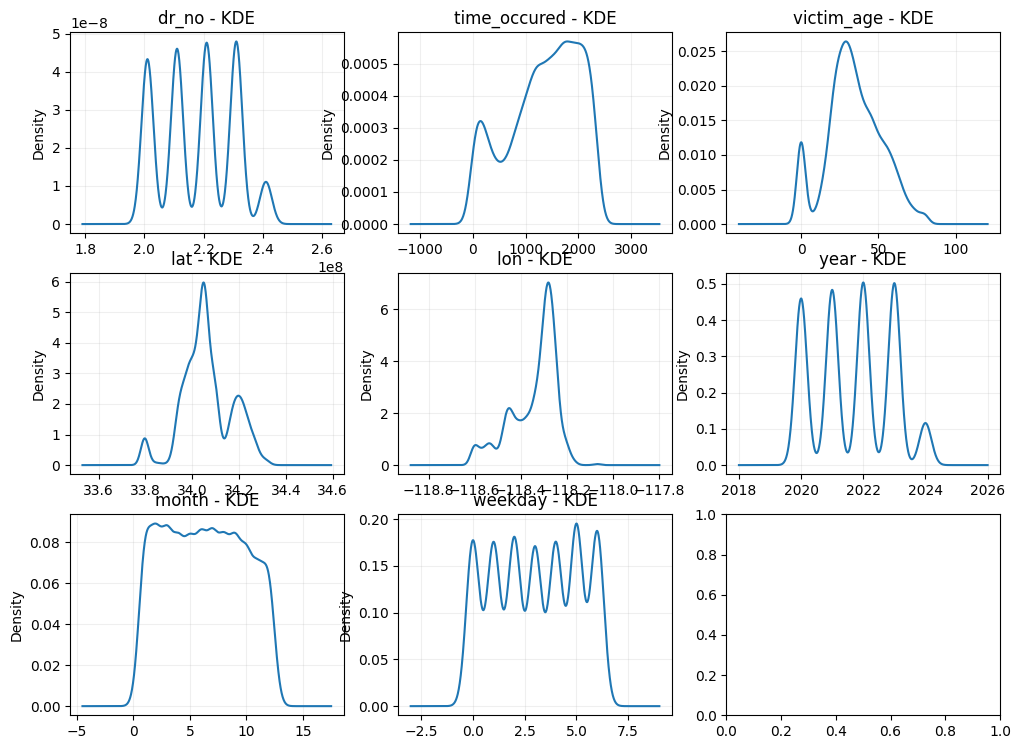

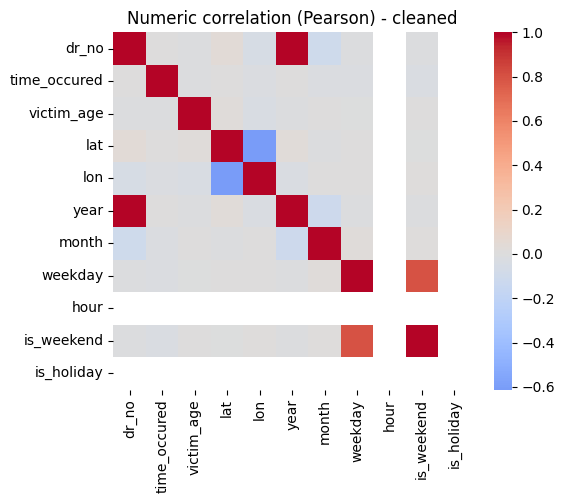

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---cleaned.png


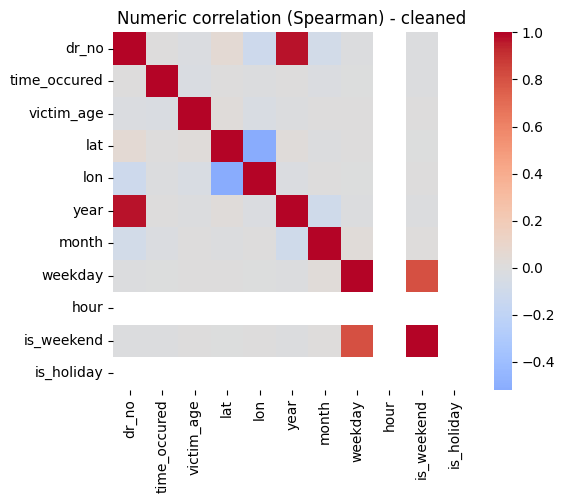

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---cleaned.png


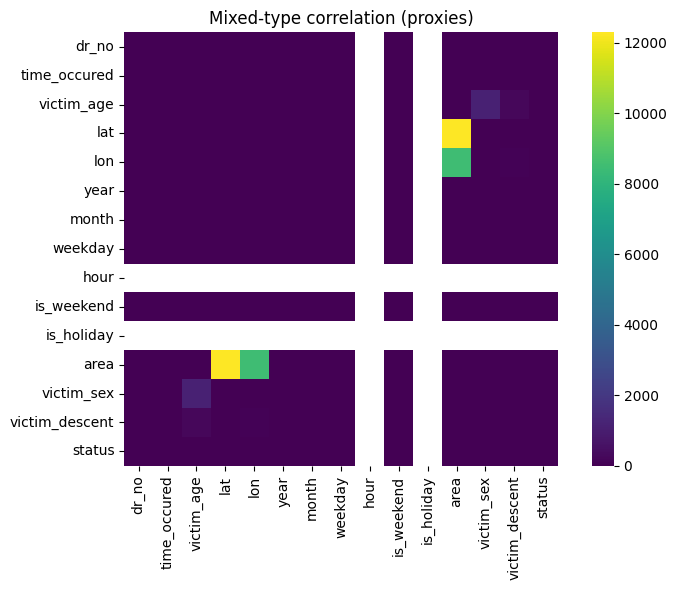

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean.parquet
Loading cleaned data returned by EDA...
[EDA output] Cleaned data shape: (312614, 23)
Created is_night target:
is_night
1    312614
Name: count, dtype: int64

Re-running EDA with target variable for class-specific analysis...
==== [EDA-1] Read CSV/ZIP ====
Using date column: date
shape: (312614, 24)
==== [EDA-2] Normalize column names ====
==== [EDA-3] Build datetime + add time features ====
🗂️ saved: /content/figs_eda_with_target/class_balance_raw_is_night.png


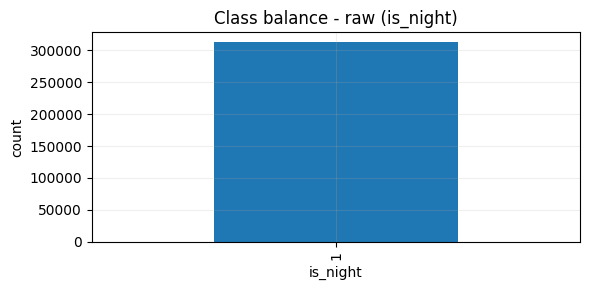

preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Pearson)---raw.png


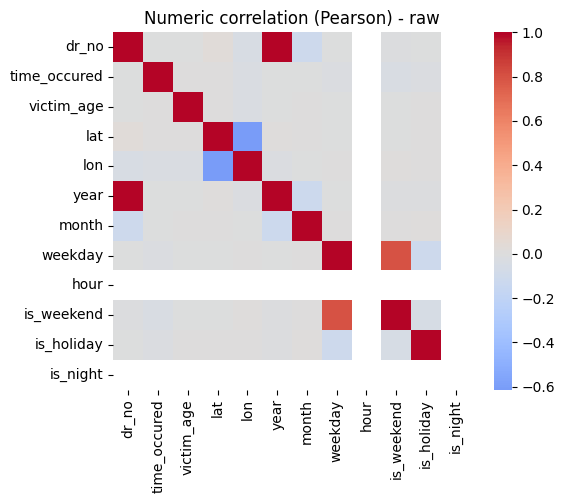

🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Spearman)---raw.png


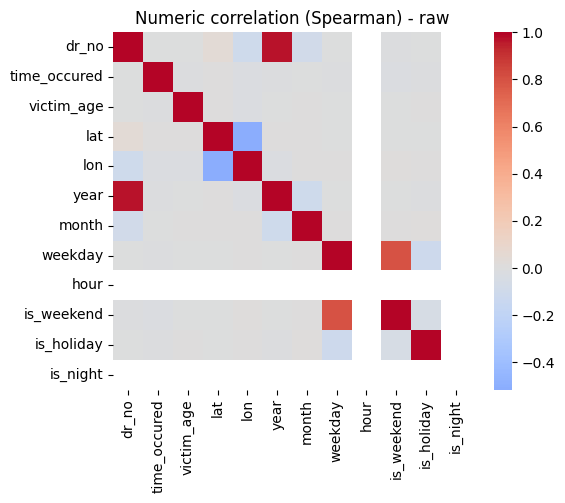

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat)---raw.png


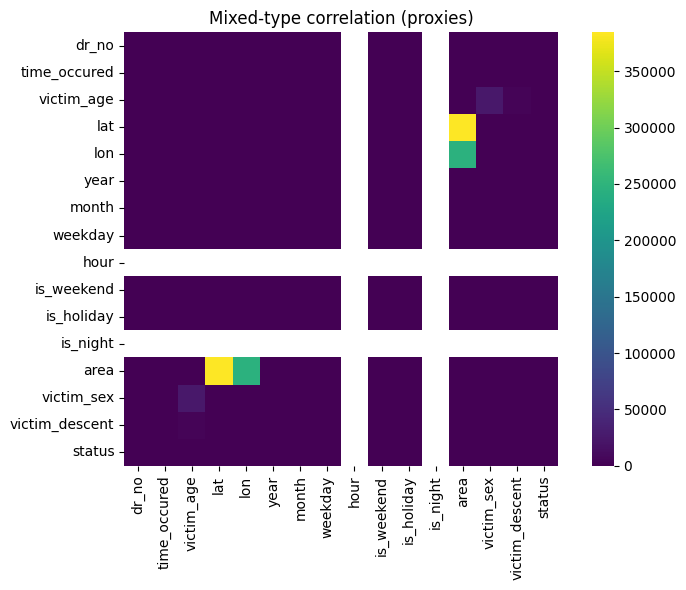

🗂️ saved: /content/figs_eda_with_target/Numeric-distributions-(hist)---raw.png


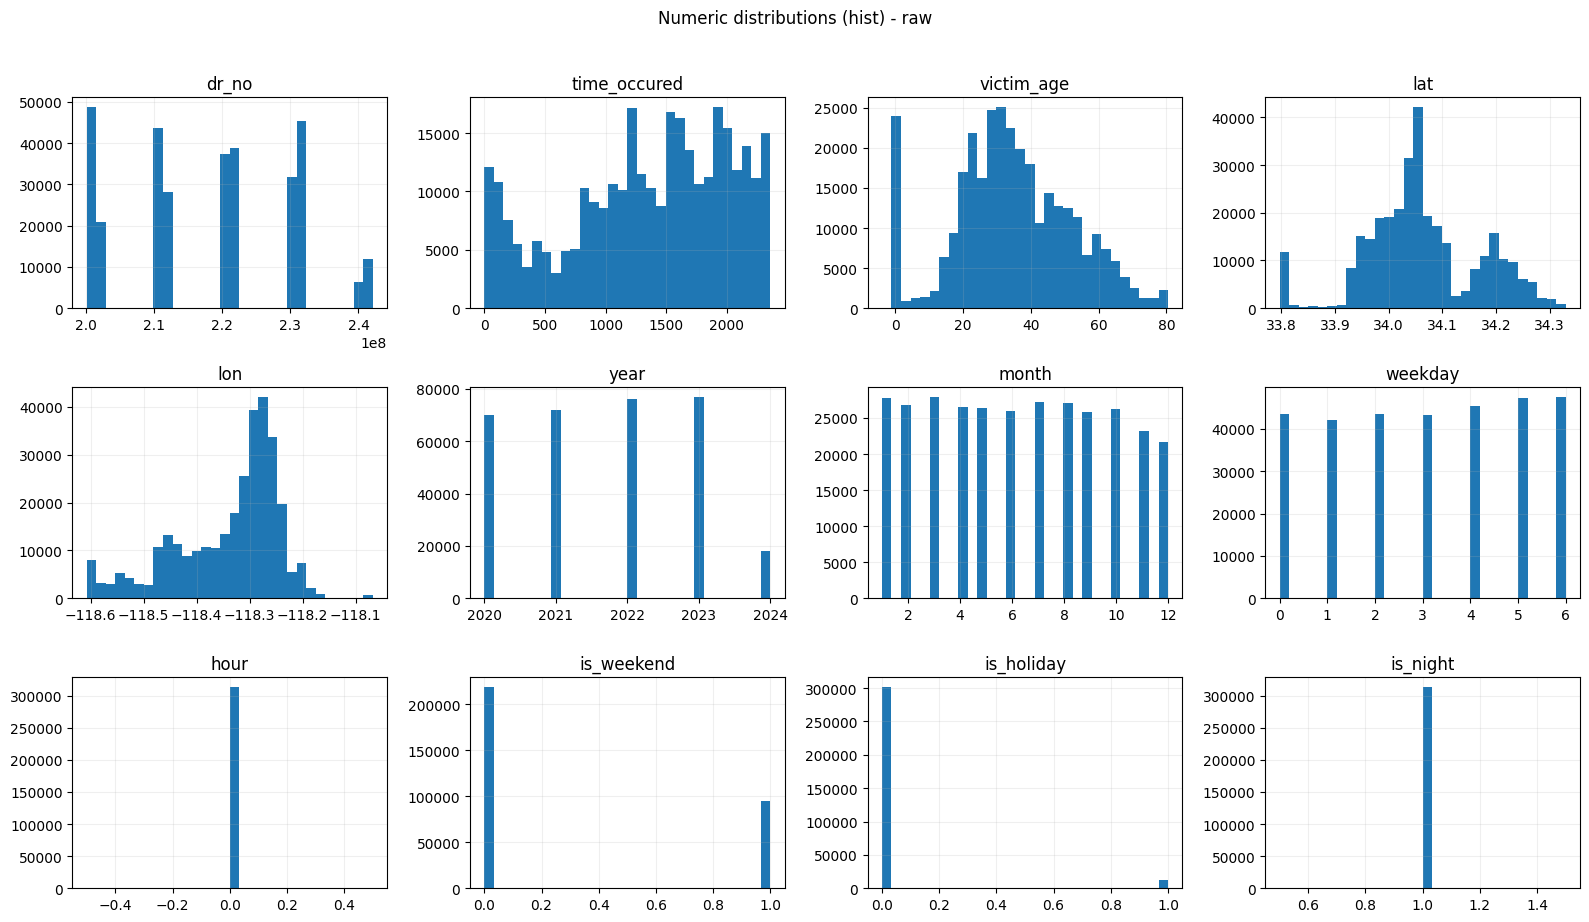

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
Empty DataFrame
Columns: [issue, count]
Index: []
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 6,252 / 312,614 rows
[LOF] flagged 6,127 / 306,362 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda_with_target/Missingness---cleaned.png


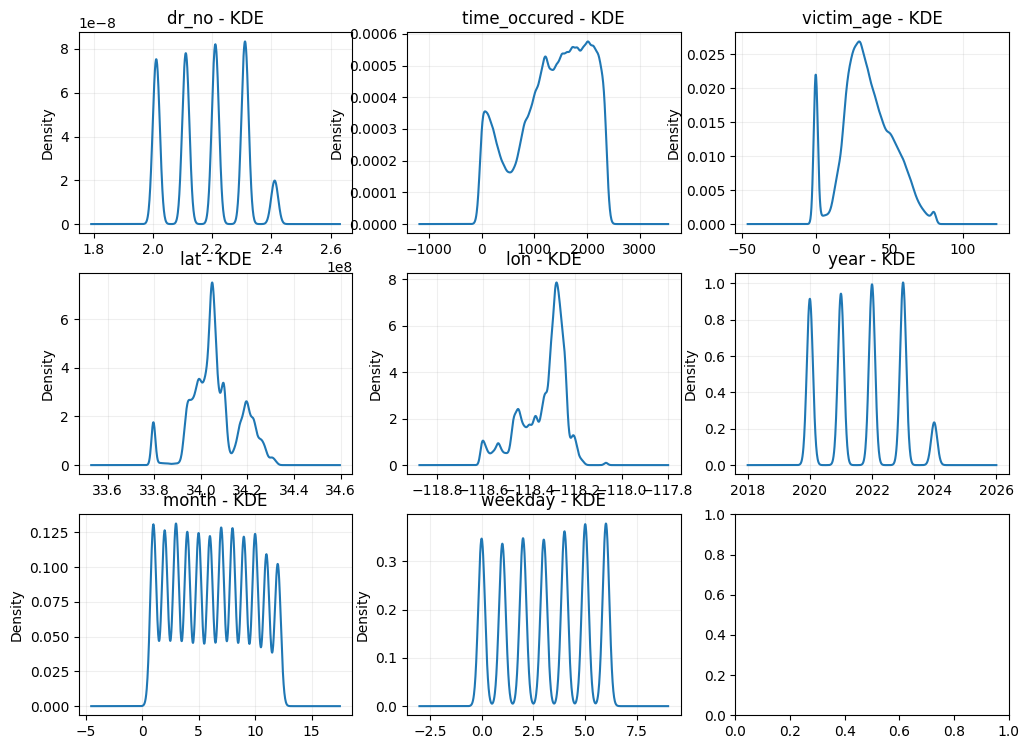

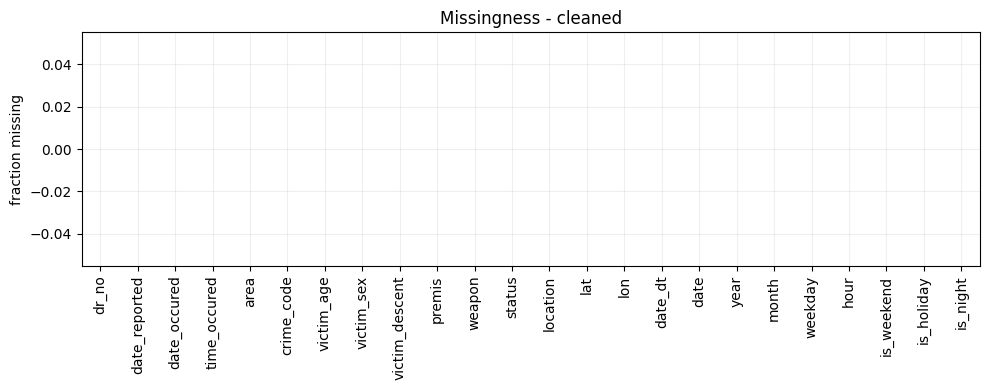

🗂️ saved: /content/figs_eda_with_target/Missingness-matrix---cleaned.png


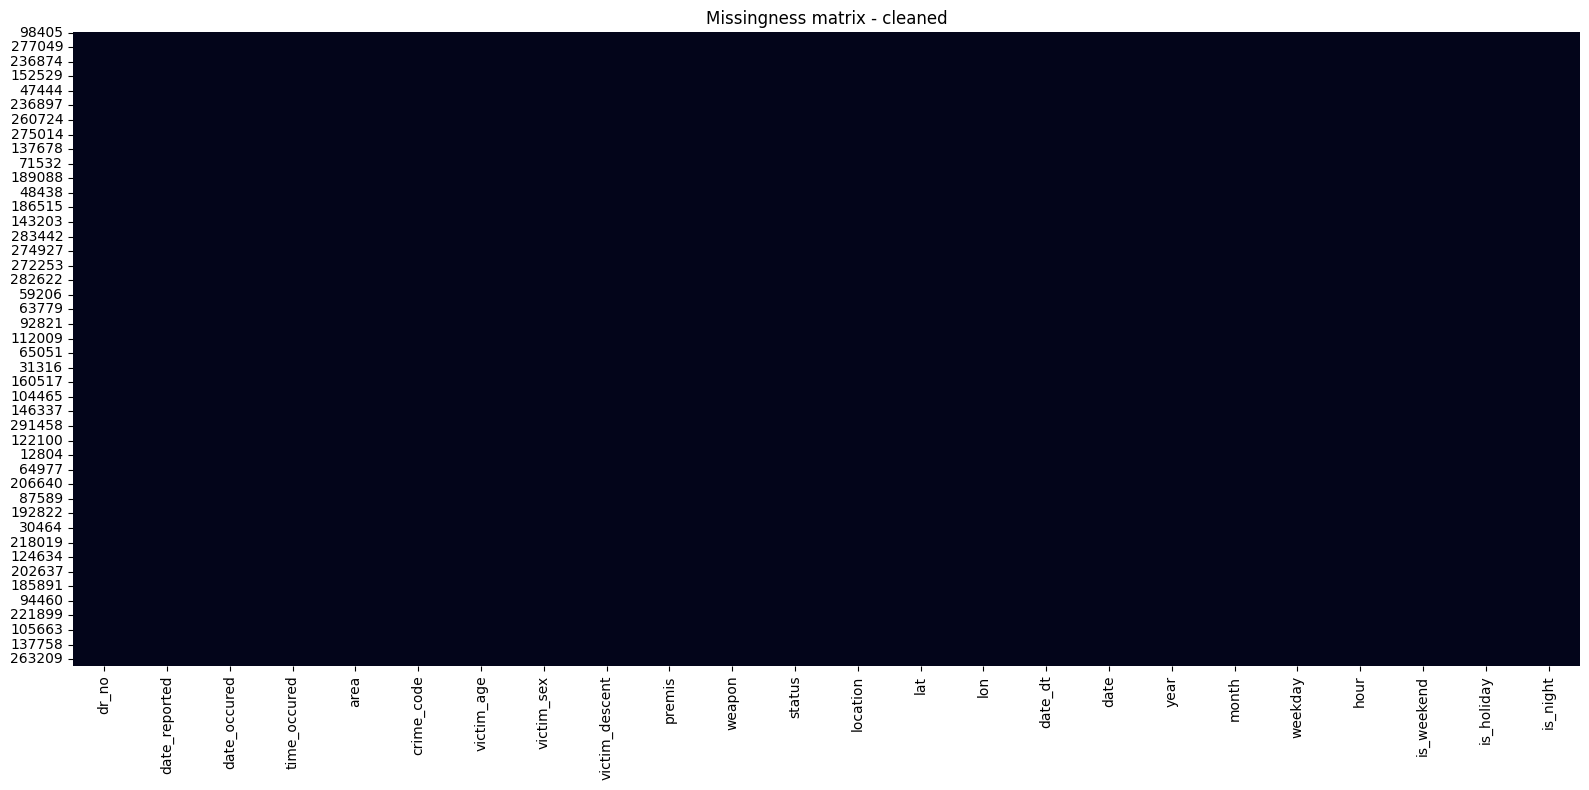

🗂️ saved: /content/figs_eda_with_target/Numeric-distributions-(hist)---cleaned.png


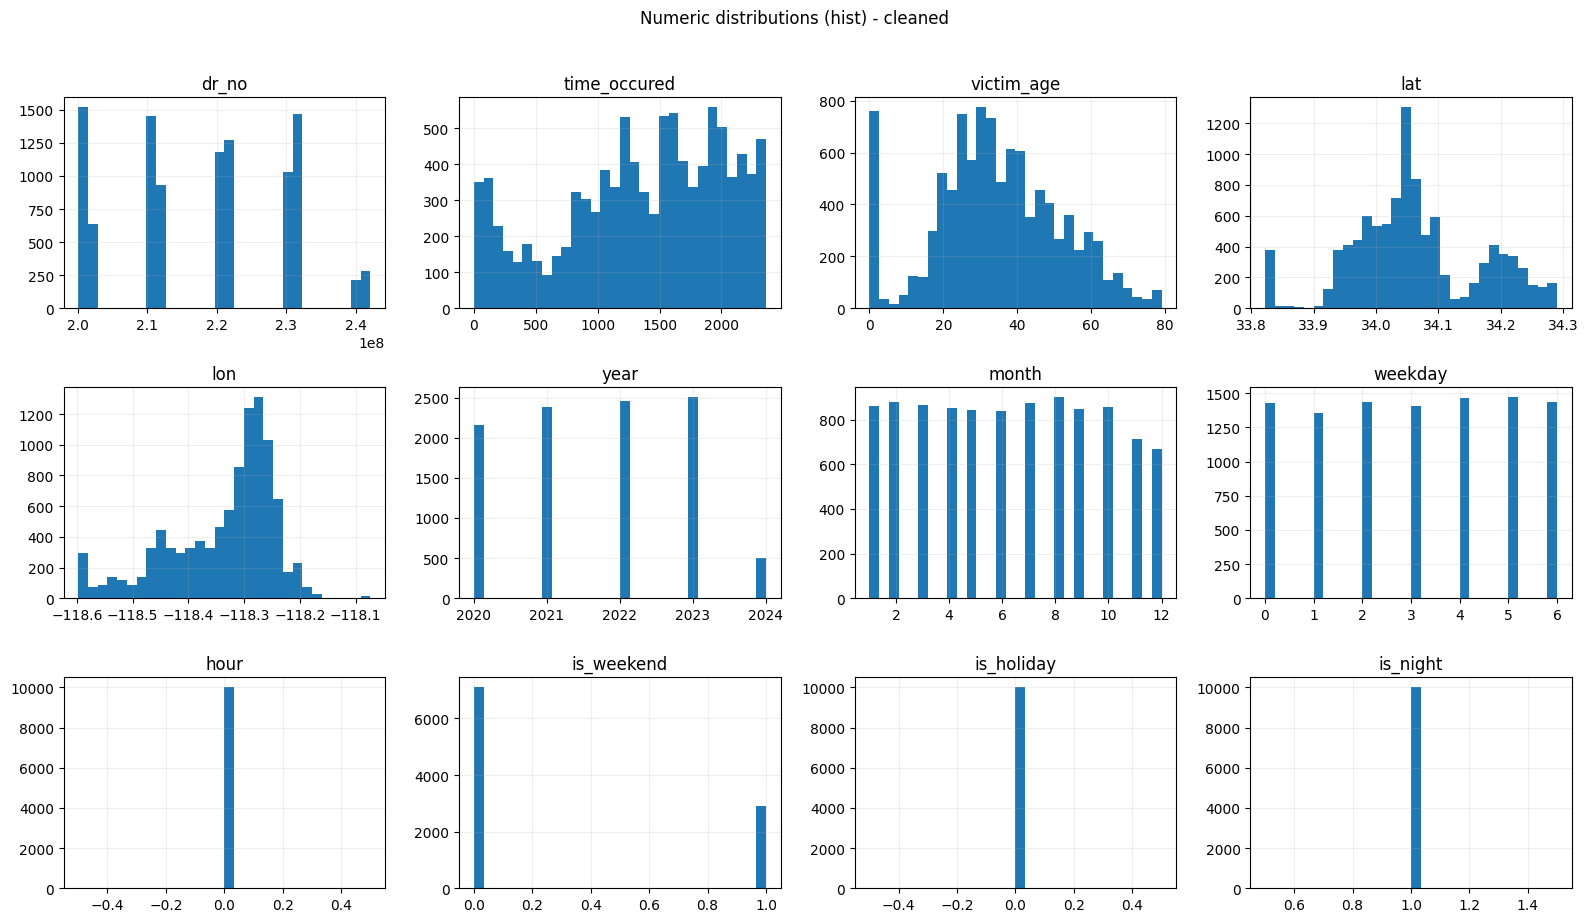

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Pearson)---cleaned.png


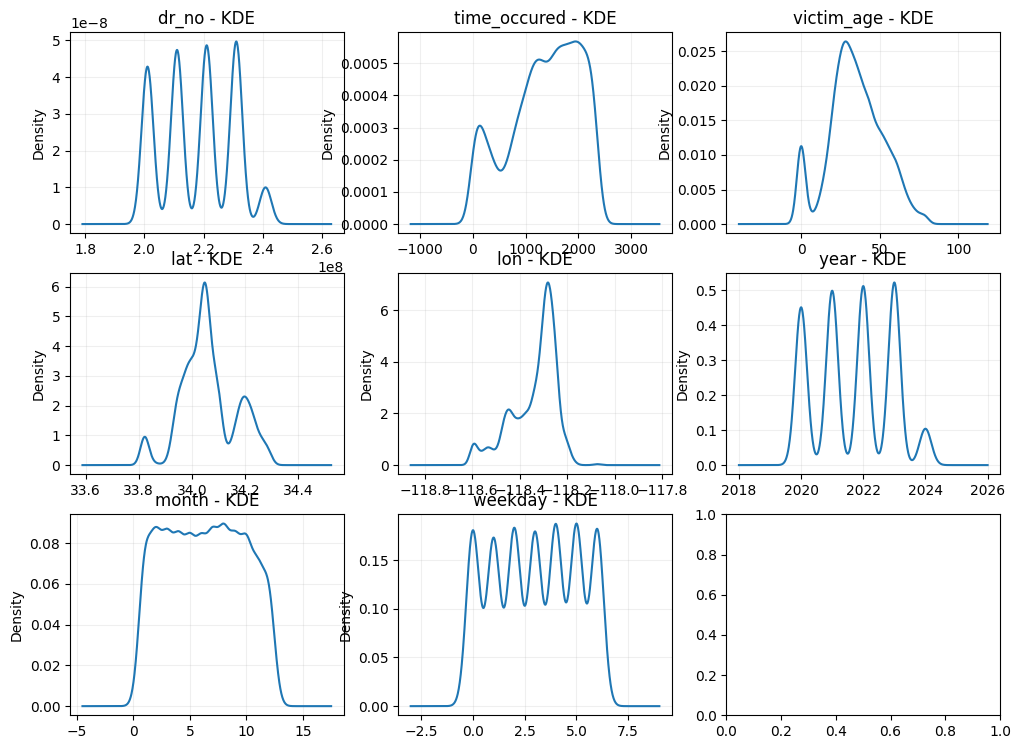

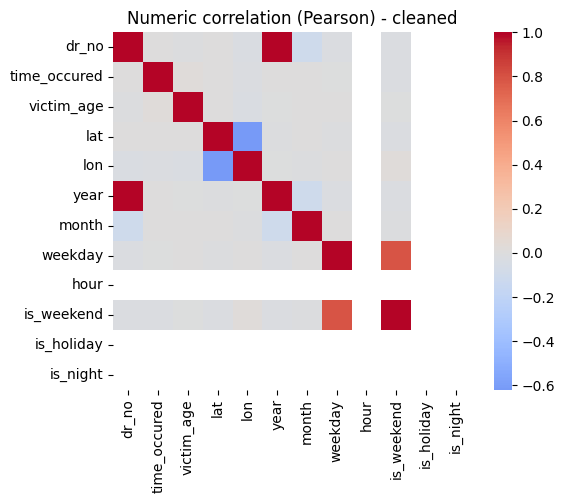

🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Spearman)---cleaned.png


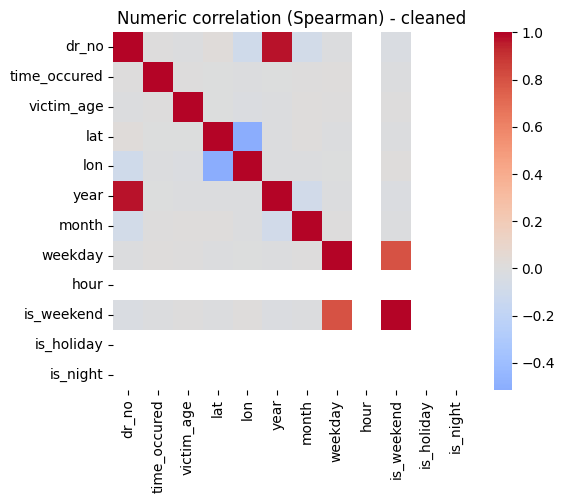

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat)---cleaned.png


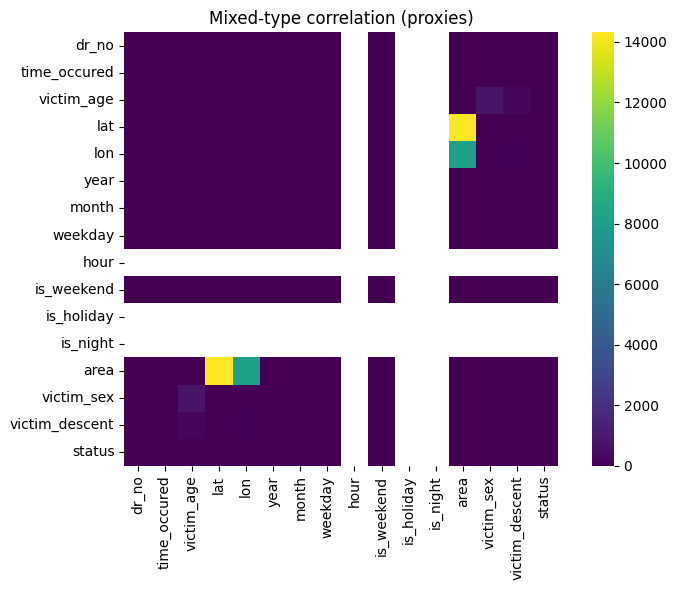

SMOTE failed; falling back to undersample: The target 'y' needs to have more than 1 class. Got 1 class instead
[Balance] target has <2 classes; skip.
🗂️ saved: /content/figs_eda_with_target/Mutual-Information-vs-is_night.png


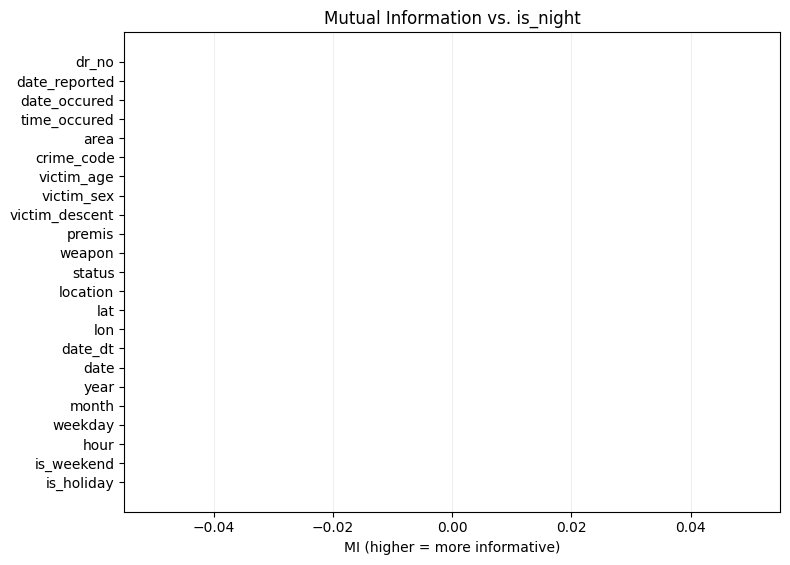

🗂️ saved: /content/figs_eda_with_target/RF-feature-importance.png


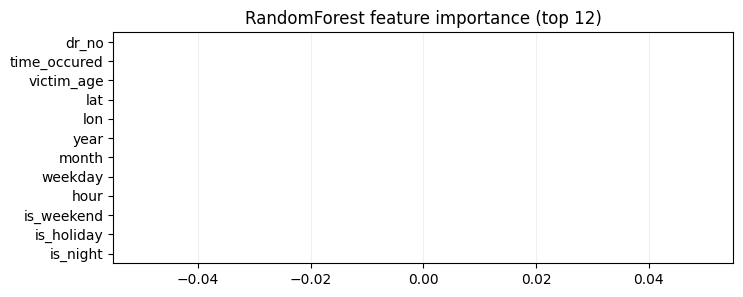

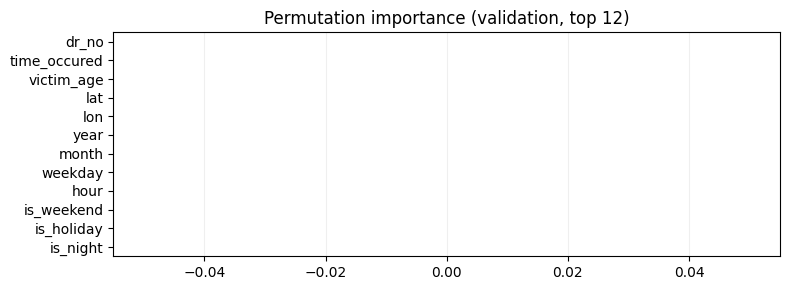

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean_with_target.parquet

Creating stratified sample of 5000 rows...
[EDA Runner] Stratified sample using 'victim_sex': 5,000 rows.
Stratified sample saved to: /content/lapd_sample.parquet
Sample shape: (5000, 24)
Gender distribution:
victim_sex
M    2582
F    2418
Name: count, dtype: int64

Final cleaned dataset: /content/lapd_clean_with_target.parquet


In [ ]:
import pandas as pd
import numpy as np
from eda import run_eda

# Define missing constants
SAMPLE_SIZE = 5000
RANDOM_STATE = 42

# Configuration for EDA (we'll already drop-all-missing in the runner)
EDA_CFG = {
    "use_us_holidays": True,
    "add_h3": False,
    "iqr_clip": True,
    "iqr_multiplier": 1.5,
    "zscore_winsor": True,
    "zscore_max": 4.0,
    "drop_any_nan_after_features": True,
    "imbalance_target": None,  # set later when we add is_night
    "balance_preview": True,
    "balance_method": "smote",
    "balance_max_n": 20000,
    "corr_pearson": True,
    "corr_spearman": True,
    "corr_mutual_info": True,
    "feature_importance": True,
    "plot_numeric_dists": True,
    "plot_kde_box": True,
    "missing_matrix": True,
    "outliers_iforest": True,
    "outliers_lof": True,
    "outliers_ocsvm": True,
    "outliers_max_frac": 0.02,
    "plot_corr": True,
    "vif_check": True,
}

RAW_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
STRICT_CLEAN_PATH = "/content/_strict_full_rows.csv"  # keep as .csv

# --- STRICT FULL-ROW CLEANING IN RUNNER --------------------------------------
print("==== [RUNNER] Read CSV/ZIP & strict full-row drop ====")
df = pd.read_csv(RAW_PATH, low_memory=False, compression='infer')
print(f"[Runner] Raw shape: {df.shape}")

# Normalize common missing sentinels to NaN, then drop any row with ANY NaN
_missing_sentinels = ["", " ", "NA", "N/A", "na", "n/a", "None", "NONE",
                      "null", "NULL", "?", "-", "--"]
df = df.replace(_missing_sentinels, np.nan)

before = len(df)
df = df.dropna(axis=0, how="any").reset_index(drop=True)
after = len(df)
print(f"[Runner] Strict dropna removed {before - after:,} rows; remaining {after:,}.")
print(f"[Runner] Post-drop shape: {df.shape}")

# Persist this strictly complete dataset as CSV; run_eda expects CSV
df.to_csv(STRICT_CLEAN_PATH, index=False)

# ------------------------------------------------------------------------------

# Run the main EDA pipeline on the already-cleaned CSV
print("\nRunning comprehensive EDA pipeline on strictly-complete data...")
clean_path = run_eda(
    raw_csv_path=STRICT_CLEAN_PATH,
    fig_dir="/content/figs_eda",
    cache_path="/content/lapd_clean.parquet",
    config_overrides=EDA_CFG
)

# Load the EDA-cleaned data
print("Loading cleaned data returned by EDA...")
df_clean = pd.read_parquet(clean_path)
print(f"[EDA output] Cleaned data shape: {df_clean.shape}")

# Create the is_night target variable (assuming 'hour' column exists and is numeric)
if 'hour' in df_clean.columns:
    # If hour accidentally came through as non-numeric, coerce to numeric first
    df_clean['hour'] = pd.to_numeric(df_clean['hour'], errors='coerce')
    # If any coercion made NaNs, drop those rows to keep the 'full info only' contract
    before_hour = len(df_clean)
    df_clean = df_clean.dropna(subset=['hour']).reset_index(drop=True)
    if len(df_clean) != before_hour:
        print(f"[Runner] Dropped {before_hour - len(df_clean):,} rows with non-numeric 'hour' after EDA.")

    df_clean['is_night'] = ((df_clean['hour'] >= 20) | (df_clean['hour'] <= 6)).astype(int)
    print(f"Created is_night target:\n{df_clean['is_night'].value_counts()}")

    # Save updated dataset with target as a new CSV for the second run
    second_csv_path = "/content/lapd_clean_with_target.csv"
    df_clean.to_csv(second_csv_path, index=False)

    # Re-run EDA with target for class-specific analysis
    print("\nRe-running EDA with target variable for class-specific analysis...")
    EDA_CFG_WITH_TARGET = EDA_CFG.copy()
    EDA_CFG_WITH_TARGET["imbalance_target"] = "is_night"

    final_clean_path = run_eda(
        raw_csv_path=second_csv_path,  # pass the CSV with the target column
        fig_dir="/content/figs_eda_with_target",
        cache_path="/content/lapd_clean_with_target.parquet",
        config_overrides=EDA_CFG_WITH_TARGET
    )
else:
    print("Warning: 'hour' column not found. Cannot create is_night target.")
    final_clean_path = clean_path

# Optional: Create stratified sample if needed
if df_clean.shape[0] > SAMPLE_SIZE:
    print(f"\nCreating stratified sample of {SAMPLE_SIZE} rows...")

    def resolve_col(df_in, aliases):
        wanted = {a.strip().lower() for a in aliases}
        for c in df_in.columns:
            if c.strip().lower() in wanted:
                return c
        return None

    # Try typical victim-sex columns
    victim_sex_col = resolve_col(df_clean, ["vict_sex", "victim_sex", "vict_sex", "victimsex"])

    if victim_sex_col and victim_sex_col in df_clean.columns:
        # Clean up gender values
        df_clean[victim_sex_col] = (
            df_clean[victim_sex_col]
            .astype(str)
            .str.strip()
            .str.upper()
            .replace({"U": "UNKNOWN", "X": "UNKNOWN", "-": "UNKNOWN", "N": "UNKNOWN", "": "UNKNOWN"})
        )

        # Keep only M/F for clear stratification
        keep_vals = {"M", "F"}
        df_stratify = df_clean[df_clean[victim_sex_col].isin(keep_vals)].copy()

        if len(df_stratify) > SAMPLE_SIZE:
            from eda import _make_stratified_sample
            df_sample = _make_stratified_sample(df_stratify, victim_sex_col, SAMPLE_SIZE, RANDOM_STATE)

            sample_path = "/content/lapd_sample.parquet"
            df_sample.to_parquet(sample_path, index=False)
            print(f"Stratified sample saved to: {sample_path}")
            print(f"Sample shape: {df_sample.shape}")
            print(f"Gender distribution:\n{df_sample[victim_sex_col].value_counts()}")
        else:
            print("Dataset too small for meaningful stratified sampling")
    else:
        print("Could not find victim sex column for stratification")

print(f"\nFinal cleaned dataset: {final_clean_path}")

In [ ]:
import pandas as pd
# Use the sampled dataframe - just making sure
df = df_sample
print(df[["date_dt","date"]].head())
print("date_dt dtype:", df["date_dt"].dtype)
print("date range:", df["date_dt"].min(), "→", df["date_dt"].max())
print("null share:", df["date_dt"].isna().mean())

          date_dt       date
303993 2024-01-26 2024-01-26
63783  2020-07-17 2020-07-17
304497 2024-03-16 2024-03-16
146678 2022-07-04 2022-07-04
143712 2022-01-16 2022-01-16
date_dt dtype: datetime64[ns]
date range: 2020-01-01 00:00:00 → 2024-06-30 00:00:00
null share: 0.0


🗂️ saved: /content/figs_eda_with_target/Numeric-Distributions-—-cleaned.png


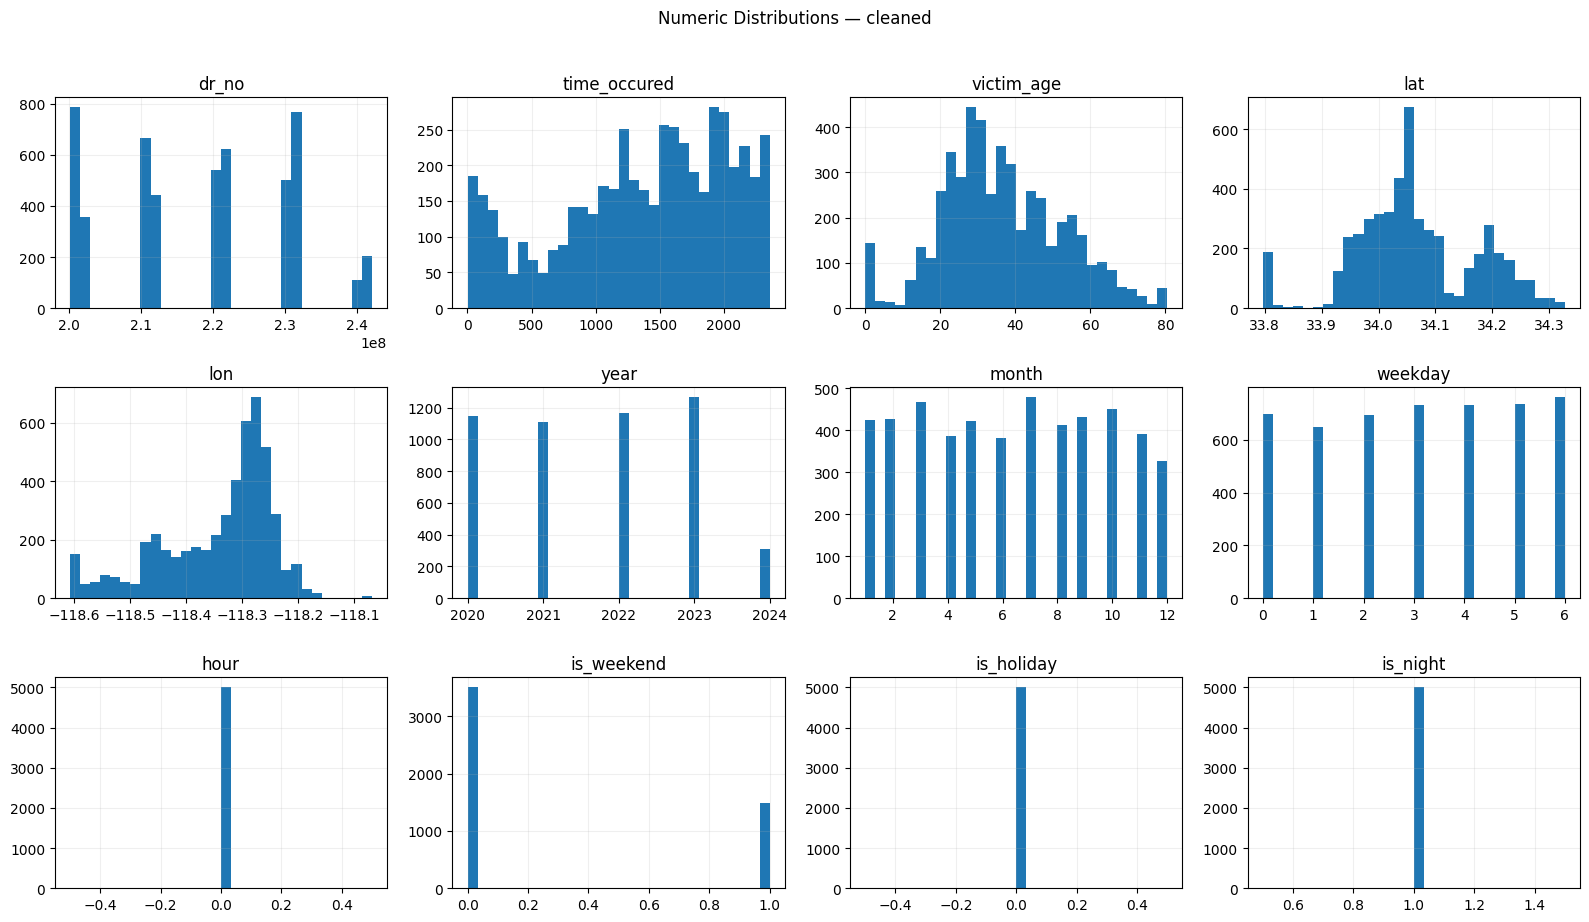

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-victim_sex.png


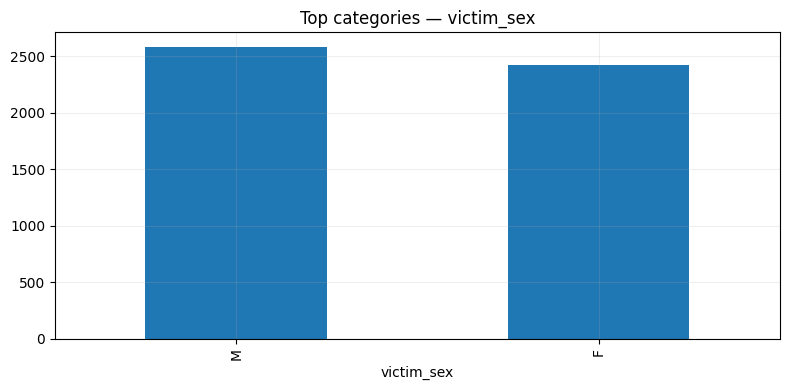

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-victim_descent.png


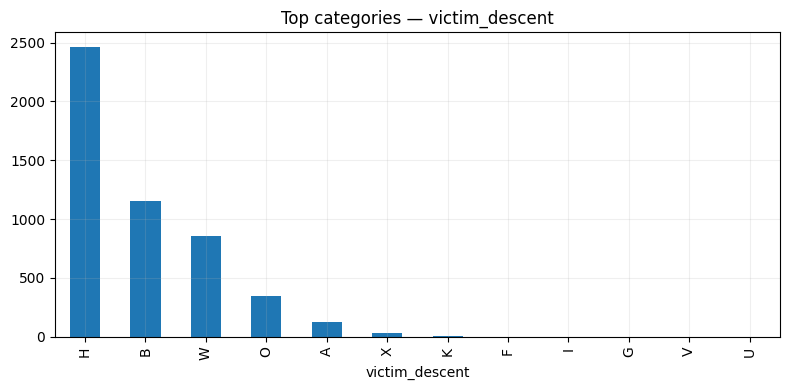

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-status.png


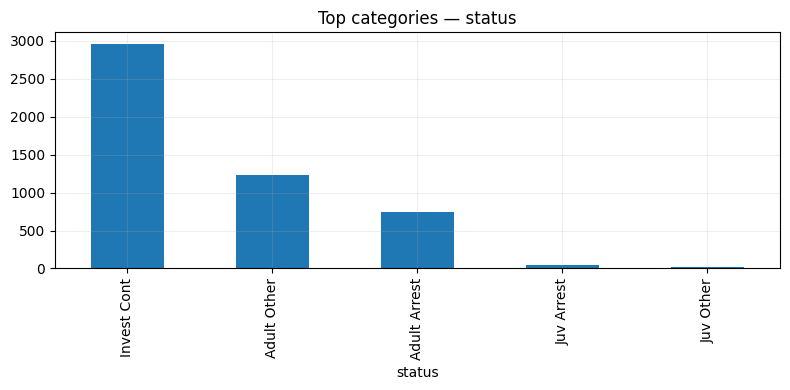

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat).png


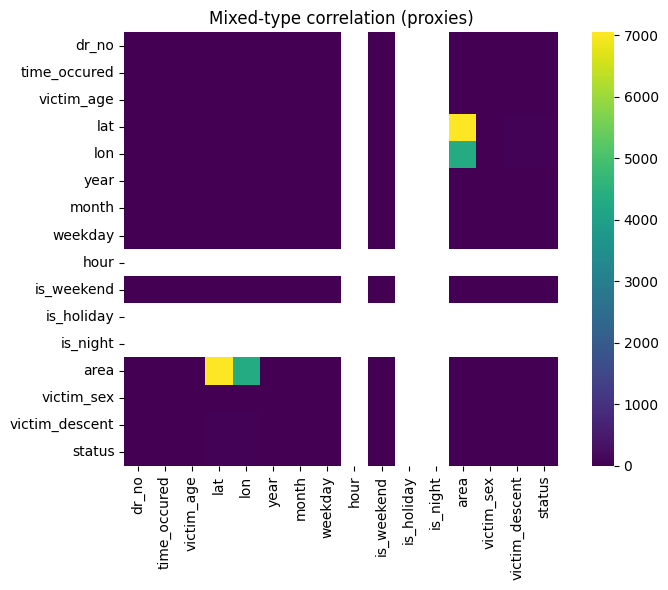

In [ ]:
# Put this after you create df_sample (and before calling run_eda if you want)
from eda import eda_top_categories, eda_numeric_histograms, eda_corr_mixed, normalize_columns, _plot_and_save
import os

# Define the figure directory
EDA_FIGS = "/content/figs_eda_with_target" # Use the directory from the successful EDA run

os.makedirs(EDA_FIGS, exist_ok=True)

# Use the sample we just built
df_plot = df_sample.copy()

# (optional but useful) normalize col names to match eda helpers’ expectations
df_plot = normalize_columns(df_plot)

# 1) Numeric distributions (all numeric cols)
_plt_title = "Numeric Distributions — cleaned"
eda_numeric_histograms(df_plot, title=_plt_title)
_plot_and_save(_plt_title, EDA_FIGS)

# 2) Categorical bars for every column with <=20 unique values (non‑numeric)
num_cols = set(df_plot.select_dtypes(include=[np.number]).columns)
cat_cols = [c for c in df_plot.columns
            if c not in num_cols and df_plot[c].nunique(dropna=False) <= 20]

for c in cat_cols:
    eda_top_categories(df_plot, c, top_n=20)
    _plot_and_save(f"Top categories — {c}", EDA_FIGS)

# 3) Mixed-type correlation heatmap (numeric ↔ categorical proxies)
eda_corr_mixed(df_plot)  # uses <=30-unique for cats internally
_plot_and_save("Mixed correlations (num + cat)", EDA_FIGS)

#Supervised

#FINAL

In [ ]:
# --- Anti-leakage + pandas hotfix + training/comparison (copy-paste ready) ---

import re
import warnings
import pandas as pd
import numpy as np

# --- HOTFIX: make pandas accept 'na_last' used by supervised.py (maps to na_position) ---
try:
    _orig_sort_values = pd.DataFrame.sort_values
    def _sort_values_compat(self, *args, **kwargs):
        if "na_last" in kwargs:
            kwargs["na_position"] = "last" if kwargs.pop("na_last") else "first"
        return _orig_sort_values(self, *args, **kwargs)
    pd.DataFrame.sort_values = _sort_values_compat  # monkey-patch
except Exception as _e:
    warnings.warn(f"Could not patch pandas sort_values: {_e}")


from supervised import MLConfig, quick_train, quick_compare # Import MLConfig and the correct functions


df = pd.read_parquet("/content/lapd_sample.parquet")

# Create target column (your approach)
df = df[df["victim_sex"].isin(["F", "M"])].copy()
df["victim_sex_num"] = df["victim_sex"].map({"F": 0, "M": 1})

print(f"Dataset shape after filtering: {df.shape}")
print(f"Target distribution:\n{df['victim_sex_num'].value_counts()}")

# CRITICAL: Remove ONLY the original victim_sex column to prevent direct data leakage
print("\nRemoving victim_sex to prevent data leakage...")
df_ml = df.drop(columns=['victim_sex']).copy()
print(f"Dataset shape after removing victim_sex: {df_ml.shape}")

# Keep victim_age and victim_descent as legitimate predictive features
victim_cols_remaining = [col for col in df_ml.columns if 'victim' in col.lower()]
print(f"Remaining victim-related columns: {victim_cols_remaining}")

# Configure experiment with fewer folds
config = MLConfig(
    sample_n=5000,
    test_size=0.2,
    fig_dir="./results_clean",
    n_iter=15,
    n_splits=3,
    scoring="roc_auc",
    stratify_by="AREA NAME"  # Stratify by area instead of target
)

# Check remaining features (excluding target)
feature_cols = [col for col in df_ml.columns if col != 'victim_sex_num']
print(f"\nRemaining features ({len(feature_cols)} total):")
print(feature_cols)

# PRE-TRAINING DIAGNOSTICS (updated)
print("\n" + "="*60)
print("PRE-TRAINING DIAGNOSTICS (CLEAN DATA)")
print("="*60)

# Check correlations again (excluding target from predictors)
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
predictor_numeric_cols = [col for col in numeric_cols if col != 'victim_sex_num']

if len(predictor_numeric_cols) > 0:
    # Create correlation matrix including target for analysis
    df_numeric = df_ml[predictor_numeric_cols + ['victim_sex_num']]
    corr_with_target = df_numeric.corr()['victim_sex_num'].abs().sort_values(ascending=False)
    # Remove target itself from the correlation series
    corr_with_target = corr_with_target.drop('victim_sex_num')

    print("Top 10 predictor features most correlated with victim_sex_num:")
    print(corr_with_target.head(10))

    # Flag suspiciously high correlations (but victim_age is expected to be high)
    suspicious_features = corr_with_target[(corr_with_target > 0.5) & (corr_with_target < 1.0)]
    if len(suspicious_features) > 0:
        print(f"\nPredictor features with correlation > 0.5:")
        print(suspicious_features)
        print("Note: victim_age correlation is expected and legitimate")
    else:
        print("\nNo predictor features with unexpectedly high correlation (>0.5)")

# TRAINING: Single model first
print("\n" + "="*60)
print("TRAINING XGB MODEL (CLEAN DATA)")
print("="*60)

# Correct the order of arguments: df, target_col, model_type, config
best_est, params, score, metrics = quick_train(
    df_ml, "victim_sex_num", "xgb", config
)

# POST-TRAINING DIAGNOSTICS
print("\n" + "="*60)
print("POST-TRAINING DIAGNOSTICS (CLEAN DATA)")
print("="*60)

try:
    # Get feature names and importances
    feature_names = best_est.named_steps['preprocessor'].get_feature_names_out()
    importances = best_est.named_steps['clf'].feature_importances_

    # Sort by importance
    feature_importance_pairs = list(zip(feature_names, importances))
    top_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

    print("Top 15 most important features:")
    for i, (feat, imp) in enumerate(top_features[:15]):
        print(f"{i+1:2d}. {feat:<30} {imp:.4f}")

    # Check if any single feature dominates (but victim_age dominance is expected)
    if top_features:
        top_importance = top_features[0][1]
        second_importance = top_features[1][1] if len(top_features) > 1 else 0
        top_feature_name = top_features[0][0]

        print(f"\nFeature importance analysis:")
        print(f"Top feature: {top_feature_name} ({top_importance:.4f})")
        print(f"Second feature importance: {second_importance:.4f}")
        print(f"Ratio (top/second): {top_importance/max(second_importance, 0.001):.2f}")

        if 'victim_age' in top_feature_name and top_importance > 0.3:
            print("✓ victim_age dominance is expected - age patterns differ by gender")
        elif top_importance > 0.5:
            print("⚠️  WARNING: Non-age feature dominates (>0.5 importance)")
        elif top_importance > 0.3:
            print("⚠️  CAUTION: Top feature has high importance (>0.3)")
        else:
            print("✓ Feature importance looks balanced")

except Exception as e:
    print(f"Could not extract feature importance: {e}")

# CV Score Analysis - higher scores expected with age/descent
print(f"\nCV Score Analysis:")
print(f"Best CV score: {score:.4f}")

if score > 0.98:
    print("⚠️  WARNING: CV score > 0.98 - may still have leakage issues")
elif score > 0.9:
    print("✓ High CV score expected - victim age/descent are strong predictors")
elif score > 0.8:
    print("✓ Good CV score - demographic features provide strong signal")
elif score > 0.7:
    print("✓ CV score looks reasonable for demographic prediction")
elif score > 0.6:
    print("✓ CV score is modest - likely realistic performance")
else:
    print("📊 CV score is low - may indicate weak signal or need more features")

# Holdout performance
if metrics:
    print(f"\nHoldout Test Performance:")
    # Filter out non-scalar values before printing
    for metric, value in metrics.items():
        if isinstance(value, (int, float, np.number)):
             print(f"{metric}: {value:.4f}")

# Compare multiple models - expect higher scores with demographic features
print(f"\nRunning model comparison with demographic features...")
print("\n" + "="*60)
print("COMPARING MULTIPLE MODELS (WITH DEMOGRAPHIC FEATURES)")
print("="*60)

# Test with multiple models
models_to_test = ["logreg", "random_forest", "hgb", "xgb"]
# Correct the order of arguments and remove the extra config argument
results = quick_compare(df_ml, "victim_sex_num", models=models_to_test, config=config)
print("\nModel Comparison Results:")
print(results.round(4))

# Analysis
if 'cv_score' in results.columns:
    best_model = results.iloc[0]
    worst_model = results.iloc[-1]
    score_range = best_model['cv_score'] - worst_model['cv_score']

    print(f"\nModel Performance Analysis:")
    print(f"Best model: {best_model['model']} ({best_model['cv_score']:.4f})")
    print(f"Worst model: {worst_model['model']} ({worst_model['cv_score']:.4f})")
    print(f"Score range: {score_range:.4f}")

    if score_range < 0.02:
        print("✓ Models perform similarly - suggests stable signal")
    elif score_range > 0.1:
        print("📊 Large performance differences - some models may be overfitting")

# FINAL ASSESSMENT
print("\n" + "="*60)
print("FINAL ASSESSMENT")
print("="*60)

print(f"Model CV score with demographic features: {score:.4f}")
print(f"This represents predictive power using victim age, descent, and crime context")

if score > 0.85:
    print("\n✓ STRONG DEMOGRAPHIC SIGNAL:")
    print("- Victim age and descent provide strong predictive power")
    print("- Combined with crime patterns, demographics enable good prediction")
    print("- This level of performance is realistic for demographic prediction")
    print("- Age patterns: crimes may affect different age groups by gender")
    print("- Descent patterns: cultural/social factors may influence crime exposure")
elif score > 0.7:
    print("\n✓ MODERATE DEMOGRAPHIC SIGNAL:")
    print("- Demographic features provide useful but not overwhelming signal")
    print("- Performance suggests learnable patterns in victim demographics")
    "- Results could be actionable for targeted prevention/resource allocation"
else:
    print("\n📊 WEAK DEMOGRAPHIC SIGNAL:")
    print("- Victim demographics may not be strongly predictable from available features")
    print("- Consider whether this target is appropriate for your use case")
    "- Might need additional contextual features"

Dataset shape after filtering: (1929, 25)
Target distribution:
victim_sex_num
1    1008
0     921
Name: count, dtype: int64

Removing victim_sex to prevent data leakage...
Dataset shape after removing victim_sex: (1929, 24)
Remaining victim-related columns: ['victim_age', 'victim_descent', 'victim_sex_num']

Remaining features (23 total):
['dr_no', 'date_reported', 'date_occured', 'time_occured', 'area', 'crime_code', 'victim_age', 'victim_descent', 'premis', 'weapon', 'status', 'location', 'lat', 'lon', 'hour', 'is_night', 'date_dt', 'date', 'year', 'month', 'weekday', 'is_weekend', 'is_holiday']

PRE-TRAINING DIAGNOSTICS (CLEAN DATA)
Top 10 predictor features most correlated with victim_sex_num:
lat             0.076035
weekday         0.031235
lon             0.021935
dr_no           0.019386
year            0.016763
month           0.013164
time_occured    0.011192
is_weekend      0.005219
victim_age      0.003392
hour                 NaN
Name: victim_sex_num, dtype: float64

No pr

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
df.columns

Index(['dr_no', 'date_reported', 'date_occured', 'time_occured', 'area',
       'crime_code', 'victim_age', 'victim_sex', 'victim_descent', 'premis',
       'weapon', 'status', 'location', 'lat', 'lon', 'hour', 'is_night',
       'victim_sex_num', 'date_dt', 'date', 'year', 'month', 'weekday',
       'is_weekend', 'is_holiday'],
      dtype='object')

In [ ]:
# ==== HARD RESET pandas .sort_values + leak-safe training/compare ====

# 0) Hard reset pandas' DataFrame.sort_values to factory default
import importlib, pandas as pd
import pandas.core.frame as _pd_frame_mod
importlib.reload(_pd_frame_mod)
pd.DataFrame.sort_values = _pd_frame_mod.DataFrame.sort_values
if hasattr(pd.DataFrame, "_orig_sort_values"):
    delattr(pd.DataFrame, "_orig_sort_values")

# 1) Idempotent compatibility patch: translate 'na_last' -> 'na_position'
def patch_pandas_sort_values():
    # Only patch if not already patched by this exact function
    if getattr(pd.DataFrame.sort_values, "__name__", "") != "_sort_values_compat":
        _orig = pd.DataFrame.sort_values
        def _sort_values_compat(self, *args, **kwargs):
            # supervised.py sometimes passes na_last=...
            if "na_last" in kwargs:
                kwargs["na_position"] = "last" if kwargs.pop("na_last") else "first"
            return _orig(self, *args, **kwargs)
        pd.DataFrame.sort_values = _sort_values_compat

patch_pandas_sort_values()

# 2) Load data
import re
TARGET = "victim_sex"
GROUP_COL = "dr_no"
df = pd.read_parquet("/content/lapd_sample.parquet")

# 3) Leak-safety: one row per incident + drop target-like proxies/perfect keys
def make_leak_safe(df: pd.DataFrame, target: str, group_col: str) -> pd.DataFrame:
    df = df.copy()

    # One row per incident (prevents same case in train & test)
    if group_col in df.columns:
        time_cols = [c for c in df.columns if re.search(r"(date|time)", c, re.I)]
        if time_cols:
            df = df.sort_values(time_cols).drop_duplicates(subset=[group_col], keep="first")
        else:
            df = df.drop_duplicates(subset=[group_col], keep="first")

    # Drop columns that clearly encode the target
    proxy_name_cols = [c for c in df.columns if c != target and re.search(re.escape(target), c, re.I)]
    alias_cols = [c for c in df.columns
                  if c != target and (c.lower() in {"sex", "gender"} or re.search(r"\b(sex|gender)\b", c, re.I))]
    df = df.drop(columns=sorted(set(proxy_name_cols + alias_cols)), errors="ignore")

    # Drop features that perfectly determine target (bijective mapping)
    max_card = 1000
    candidates = [c for c in df.columns if c != target and df[c].nunique(dropna=False) <= max_card]
    leaky_by_value = []
    for c in candidates:
        try:
            if df.groupby(c)[target].nunique(dropna=False).max() == 1:
                leaky_by_value.append(c)
        except Exception:
            pass
    df = df.drop(columns=leaky_by_value, errors="ignore")

    # Drop exact duplicates of the target
    dup_target_cols = [c for c in df.columns if c != target and df[c].equals(df[target])]
    df = df.drop(columns=dup_target_cols, errors="ignore")

    return df

df_clean = make_leak_safe(df, TARGET, GROUP_COL)
print("Shapes (raw → clean):", df.shape, "→", df_clean.shape)

# 4) Train & compare with your helpers (plots off to dodge seaborn labels quirk)
from supervised import quick_train, quick_compare, MLConfig

config = MLConfig(
    sample_n=1000,
    test_size=0.2,
    fig_dir="./results",
    plot_curves=False,  # set True later if you like; this avoids the "NoneType has no len()" warn
    random_state=42
)

print("\n=== TRAIN XGB (leak-safe) ===")
model, params, score, metrics = quick_train(df_clean, TARGET, "xgb", config)

print("\n=== COMPARE MODELS (leak-safe) ===")
results = quick_compare(
    df_clean,
    TARGET,
    models=["logreg", "rf", "xgb"],
    config=config
)
print(results)

print("\n✅ Done.")


Shapes (raw → clean): (1929, 25) → (1929, 24)

=== TRAIN XGB (leak-safe) ===

                 TRAINING XGB ON VICTIM_SEX                 
📊 Using target-stratified sample: 999 rows (from 1,929)
🎯 Target encoded: {'F': 0, 'M': 1}
📊 Dataset shape: (999, 23)
🎯 Classes: 2, Binary: True
📈 Target distribution:
0    477
1    522
Name: count, dtype: int64
⚠️ Removing constant numeric column: hour
⚠️ Removing constant numeric column: is_night
⚠️ Removing constant numeric column: is_holiday
📊 Numeric columns (9): ['dr_no', 'time_occured', 'victim_age', 'lat', 'lon']...
🏷️ Categorical columns (11): ['date_reported', 'date_occured', 'area', 'crime_code', 'victim_descent']...
⚖️ XGB scale_pos_weight set to 0.914
🔍 Running random search with 5-fold CV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best CV score (roc_auc): 0.7226
⏱️ Training time: 510.27s
🔧 Best parameters:
   clf__subsample: 1.0
   clf__n_estimators: 200
   clf__min_child_weight: 3
   clf__max_depth: 3
   clf__l

#Unsupervised

#final

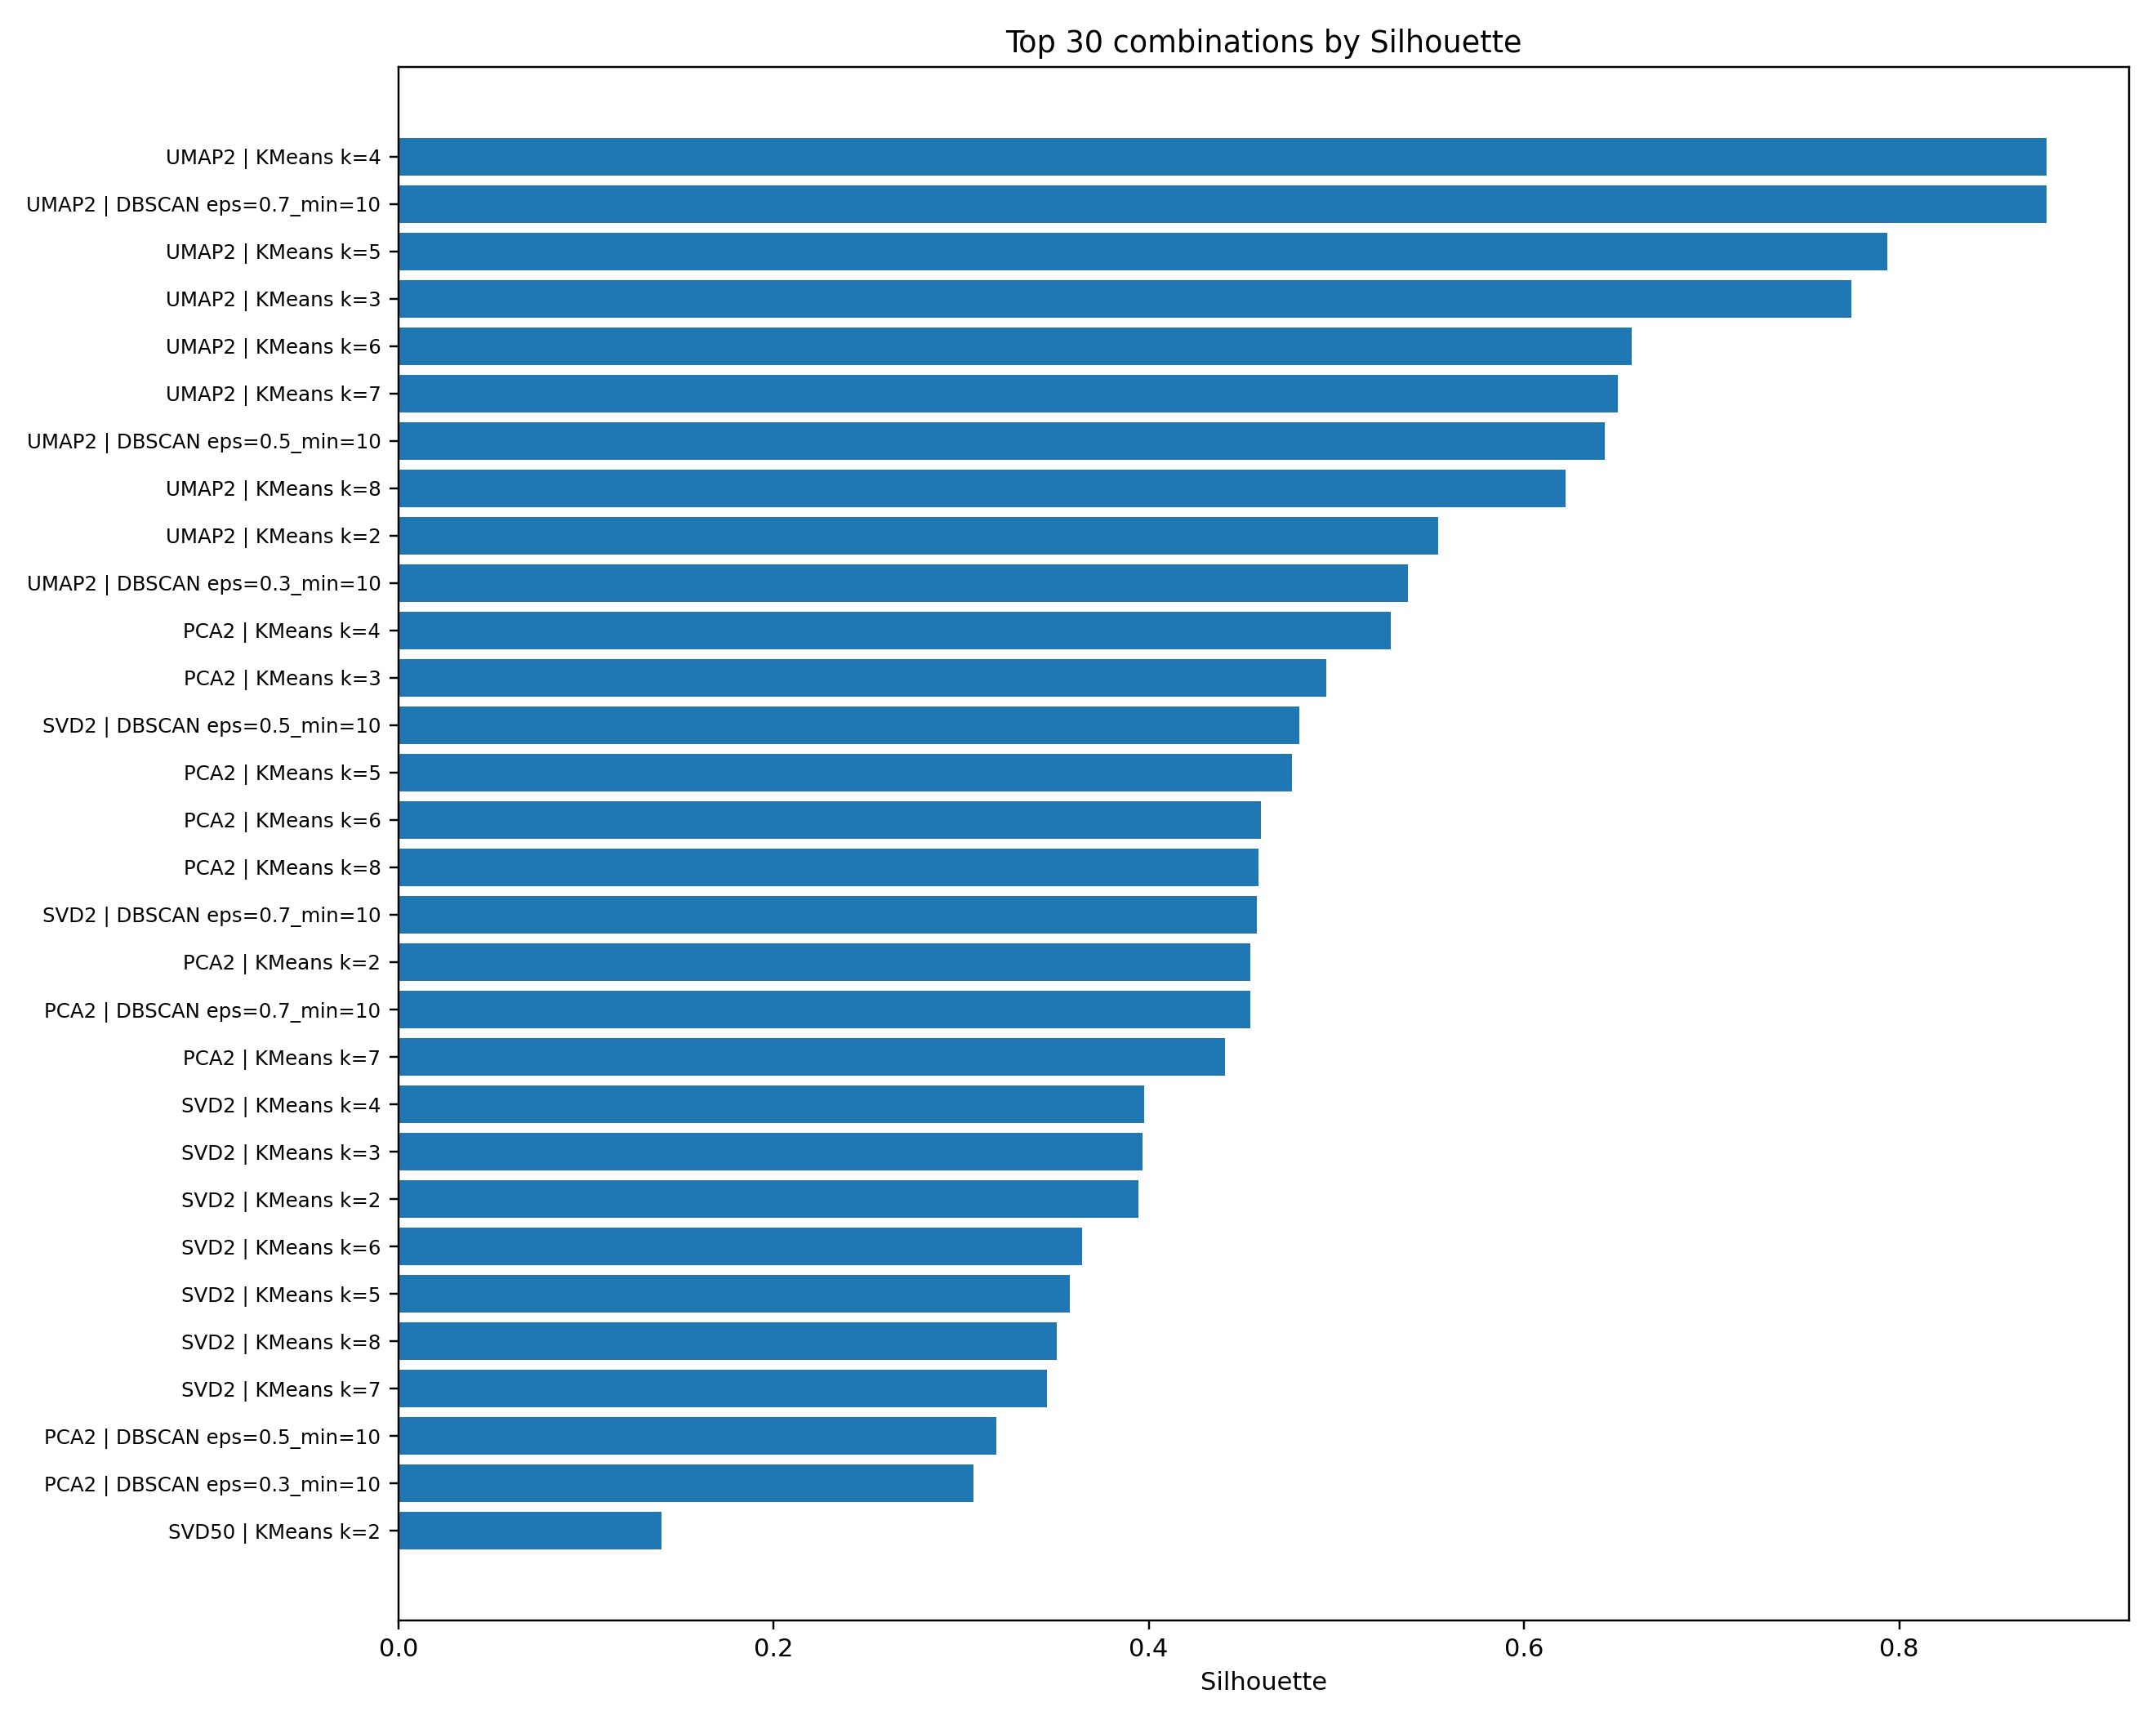

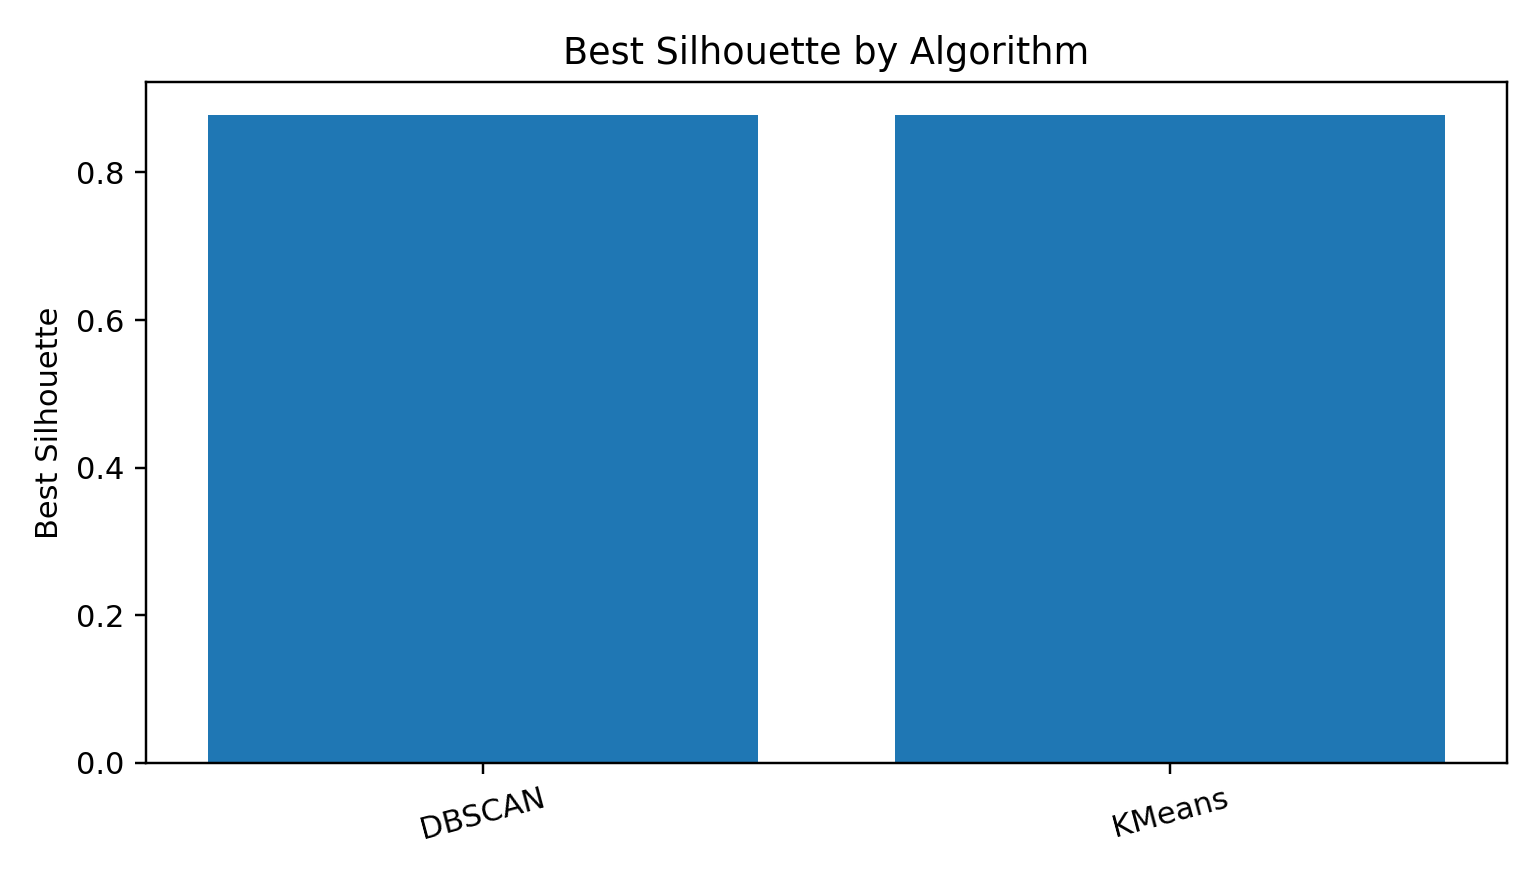

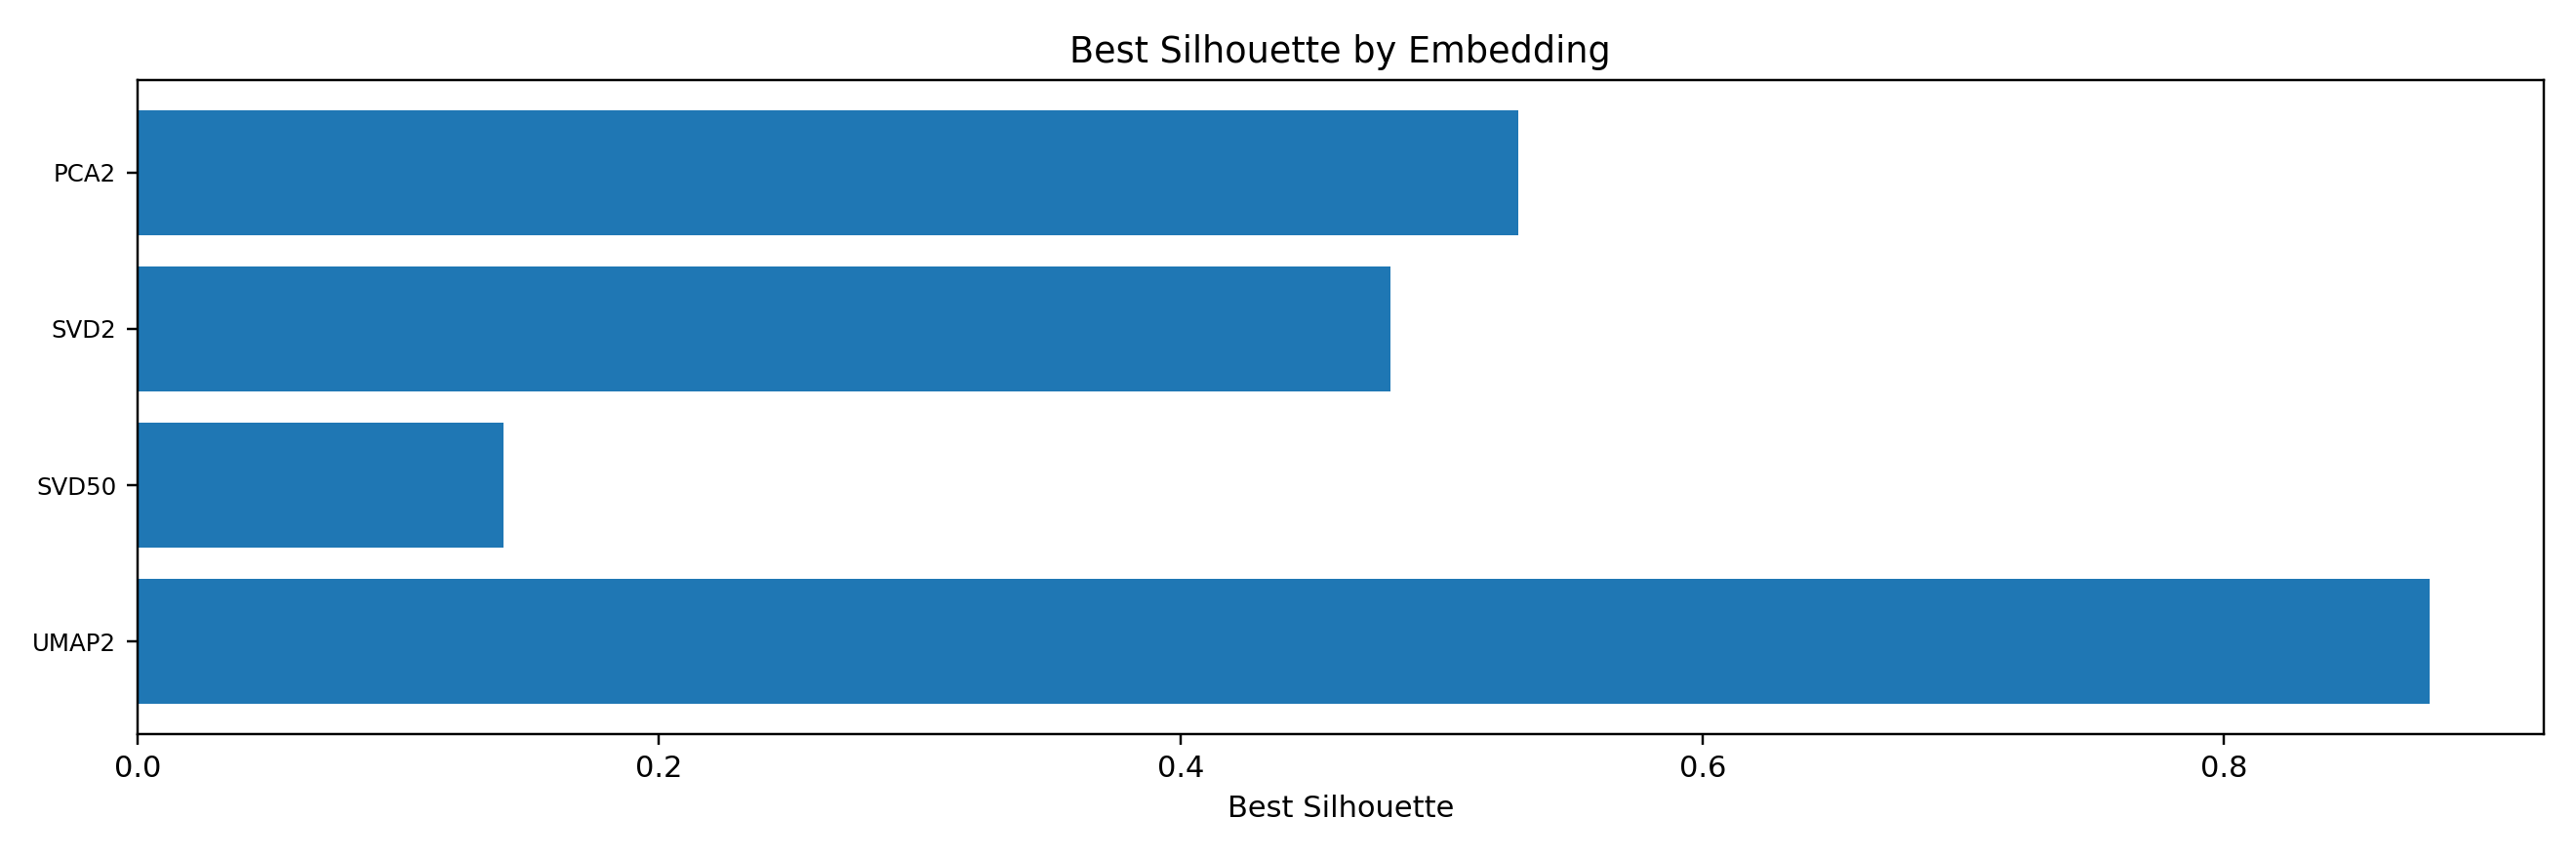

### Summary tables

embedding algorithm          config  embedding_dim  silhouette  \
32     UMAP2    KMeans             k=4              2    0.878574   
39     UMAP2    DBSCAN  eps=0.7_min=10              2    0.878574   
33     UMAP2    KMeans             k=5              2    0.793445   
31     UMAP2    KMeans             k=3              2    0.774336   
34     UMAP2    KMeans             k=6              2    0.657594   
35     UMAP2    KMeans             k=7              2    0.649976   
38     UMAP2    DBSCAN  eps=0.5_min=10              2    0.642919   
36     UMAP2    KMeans             k=8              2    0.622049   
30     UMAP2    KMeans             k=2              2    0.554341   
37     UMAP2    DBSCAN  eps=0.3_min=10              2    0.537915   
22      PCA2    KMeans             k=4              2    0.529191   
21      PCA2    KMeans             k=3              2    0.494613   
18      SVD2    DBSCAN  eps=0.5_min=10              2    0.480278   
23      PCA2    KMeans             k=5              2    0.476449   
24      PCA2    KMeans             k=6              2    0.459648   

    calinski_harabasz  davies_bouldin  n_clusters  n_noise  \
32       41110.097656        0.165247           4        0   
39       41110.097656        0.165247           4        0   
33       42278.304688        0.311604           5        0   
31        6450.632812        0.446404           3        0   
34       50282.039062        0.472131           6        0   
35       50406.832031        0.534462           7        0   
38       31646.787109        0.329394           5        0   
36       51444.863281        0.603290           8        0   
30        1916.563721        0.887982           2        0   
37       21271.718750        0.868516           8       20   
22        2669.137147        0.615480           4        0   
21        2133.920901        0.693967           3        0   
18           2.458027        3.287357           1        3   
23        2911.504902        0.707839           5        0   
24        2799.810503        0.798252           6        0   

                        combination  
32             UMAP2 + KMeans (k=4)  
39  UMAP2 + DBSCAN (eps=0.7_min=10)  
33             UMAP2 + KMeans (k=5)  
31             UMAP2 + KMeans (k=3)  
34             UMAP2 + KMeans (k=6)  
35             UMAP2 + KMeans (k=7)  
38  UMAP2 + DBSCAN (eps=0.5_min=10)  
36             UMAP2 + KMeans (k=8)  
30             UMAP2 + KMeans (k=2)  
37  UMAP2 + DBSCAN (eps=0.3_min=10)  
22              PCA2 + KMeans (k=4)  
21              PCA2 + KMeans (k=3)  
18   SVD2 + DBSCAN (eps=0.5_min=10)  
23              PCA2 + KMeans (k=5)  
24              PCA2 + KMeans (k=6)

### High-performance combinations

embedding algorithm          config  embedding_dim  silhouette  \
1     UMAP2    KMeans             k=4              2    0.878574   
7     UMAP2    DBSCAN  eps=0.7_min=10              2    0.878574   
2     UMAP2    KMeans             k=5              2    0.793445   
0     UMAP2    KMeans             k=3              2    0.774336   
3     UMAP2    KMeans             k=6              2    0.657594   
4     UMAP2    KMeans             k=7              2    0.649976   
6     UMAP2    DBSCAN  eps=0.5_min=10              2    0.642919   
5     UMAP2    KMeans             k=8              2    0.622049   

   calinski_harabasz  davies_bouldin  n_clusters  n_noise  \
1       41110.097656        0.165247           4        0   
7       41110.097656        0.165247           4        0   
2       42278.304688        0.311604           5        0   
0        6450.632812        0.446404           3        0   
3       50282.039062        0.472131           6        0   
4       50406.832031        0.534462           7        0   
6       31646.787109        0.329394           5        0   
5       51444.863281        0.603290           8        0   

                       combination  
1             UMAP2 + KMeans (k=4)  
7  UMAP2 + DBSCAN (eps=0.7_min=10)  
2             UMAP2 + KMeans (k=5)  
0             UMAP2 + KMeans (k=3)  
3             UMAP2 + KMeans (k=6)  
4             UMAP2 + KMeans (k=7)  
6  UMAP2 + DBSCAN (eps=0.5_min=10)  
5             UMAP2 + KMeans (k=8)

### Saved figures

- `best_combination_visualization.png`

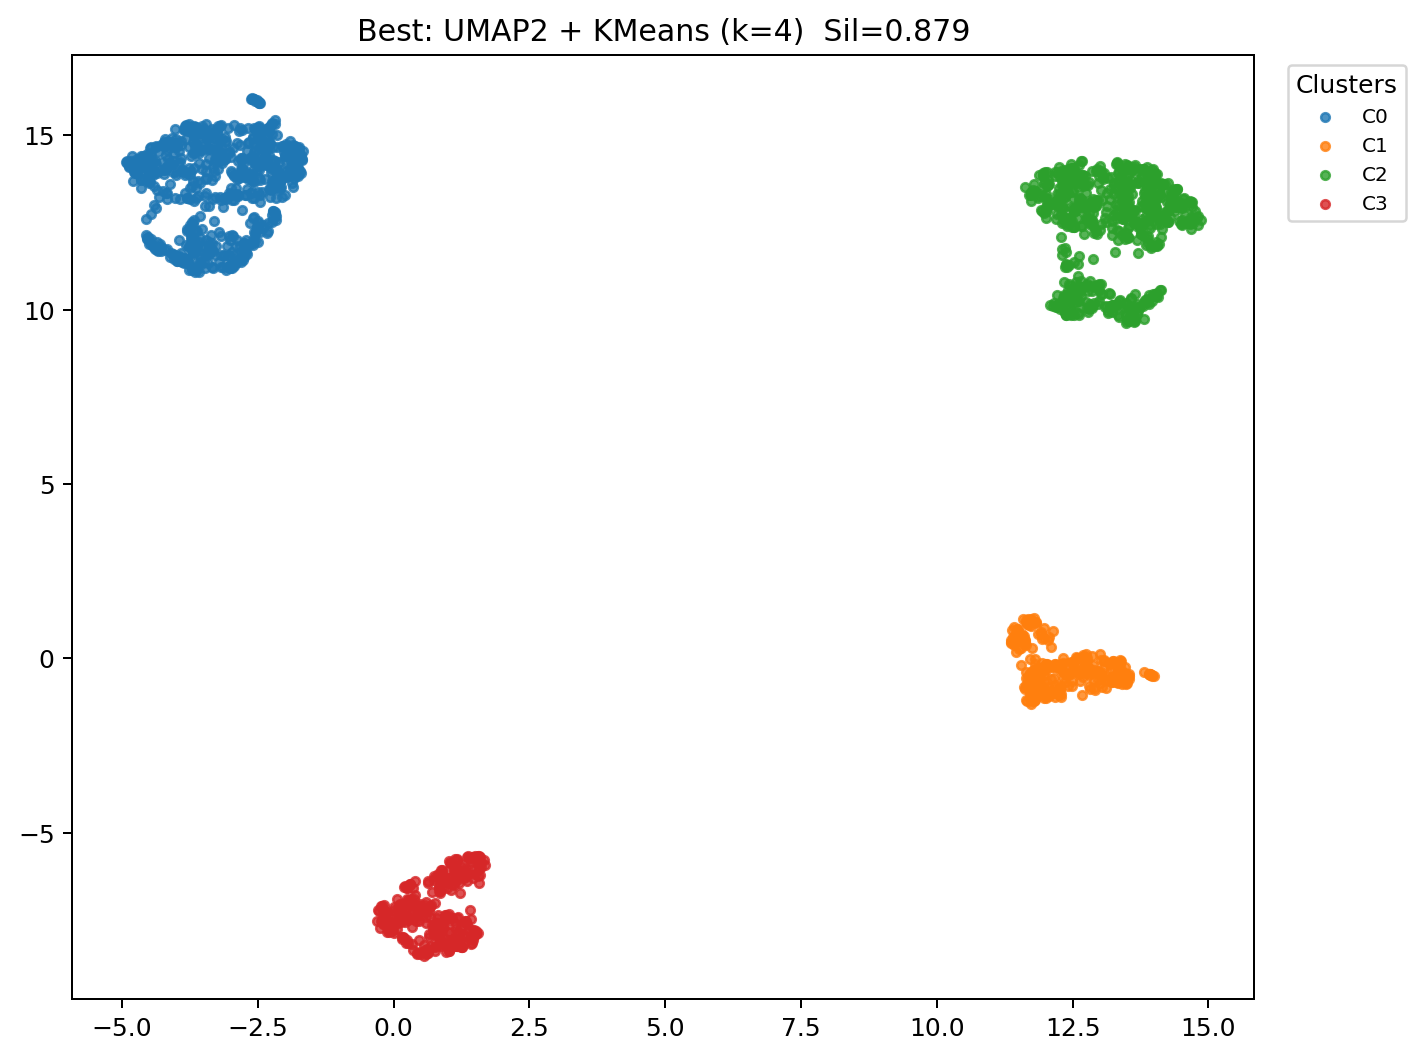

### Cluster interpretation index

combo  silhouette
0             UMAP2 + KMeans (k=4)    0.878574
1  UMAP2 + DBSCAN (eps=0.7_min=10)    0.878574
2             UMAP2 + KMeans (k=5)    0.793445
3             UMAP2 + KMeans (k=3)    0.774336
4             UMAP2 + KMeans (k=6)    0.657594
5             UMAP2 + KMeans (k=7)    0.649976
6  UMAP2 + DBSCAN (eps=0.5_min=10)    0.642919
7             UMAP2 + KMeans (k=8)    0.622049
8             UMAP2 + KMeans (k=2)    0.554341
9  UMAP2 + DBSCAN (eps=0.3_min=10)    0.537915


Overview charts saved → /content/unsup_results/charts_overview


In [6]:
# Run your analysis
from unsupervised import run_unsupervised

OUT_DIR = "/content/unsup_results"

run_unsupervised(
    data="/content/lapd_clean_final.parquet",
    output=OUT_DIR,
    max_samples=5000,
    seed=42,
    interpret=True,
    top_n=10,
)

# ---------- Visualize everything saved in OUT_DIR ----------
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown

def visualize_unsup_results(out_dir: str, topN: int = 30):
    os.makedirs(out_dir, exist_ok=True)
    charts_dir = os.path.join(out_dir, "charts_overview")
    os.makedirs(charts_dir, exist_ok=True)

    all_path  = os.path.join(out_dir, "all_combinations_results.csv")
    high_path = os.path.join(out_dir, "high_performance_combinations.csv")
    idx_json  = os.path.join(out_dir, "cluster_interpretations_index.json")

    # 1) Load results
    df_all = pd.read_csv(all_path) if os.path.exists(all_path) else None
    df_hi  = pd.read_csv(high_path) if os.path.exists(high_path) else None

    if df_all is not None:
        # Ensure helpful derived column exists
        if "combination" not in df_all.columns and {"embedding","algorithm","config"}.issubset(df_all.columns):
            df_all["combination"] = df_all["embedding"] + " + " + df_all["algorithm"] + " (" + df_all["config"] + ")"

        # 2) Top-N silhouettes (barh)
        topN = min(topN, len(df_all))
        tdf = (df_all.dropna(subset=["silhouette"])
                      .nlargest(topN, "silhouette")
                      .copy())
        if len(tdf):
            plt.figure(figsize=(12, max(4, 0.32*len(tdf))))
            ylabels = [f"{r.embedding} | {r.algorithm} {r.config}" for _, r in tdf.iterrows()]
            plt.barh(range(len(tdf)), tdf["silhouette"].values)
            plt.yticks(range(len(tdf)), ylabels, fontsize=8)
            plt.gca().invert_yaxis()
            plt.xlabel("Silhouette")
            plt.title(f"Top {len(tdf)} combinations by Silhouette")
            plt.tight_layout()
            p = os.path.join(charts_dir, "top_silhouette_barh.png")
            plt.savefig(p, dpi=220); plt.close()
            display(Image(p))

        # 3) Best silhouette by algorithm (bar)
        if "algorithm" in df_all.columns:
            best_by_algo = (df_all.dropna(subset=["silhouette"])
                                   .sort_values("silhouette", ascending=False)
                                   .groupby("algorithm", as_index=False)
                                   .first()[["algorithm","silhouette"]])
            if len(best_by_algo):
                plt.figure(figsize=(7,4))
                plt.bar(best_by_algo["algorithm"], best_by_algo["silhouette"])
                plt.ylabel("Best Silhouette")
                plt.title("Best Silhouette by Algorithm")
                plt.xticks(rotation=15)
                plt.tight_layout()
                p = os.path.join(charts_dir, "best_by_algorithm.png")
                plt.savefig(p, dpi=220); plt.close()
                display(Image(p))

        # 4) Best silhouette by embedding (barh)
        if "embedding" in df_all.columns:
            best_by_emb = (df_all.dropna(subset=["silhouette"])
                                  .sort_values("silhouette", ascending=False)
                                  .groupby("embedding", as_index=False)
                                  .first()[["embedding","silhouette"]])
            if len(best_by_emb):
                plt.figure(figsize=(12, max(4, 0.28*len(best_by_emb))))
                plt.barh(range(len(best_by_emb)), best_by_emb["silhouette"])
                plt.yticks(range(len(best_by_emb)), best_by_emb["embedding"], fontsize=8)
                plt.gca().invert_yaxis()
                plt.xlabel("Best Silhouette")
                plt.title("Best Silhouette by Embedding")
                plt.tight_layout()
                p = os.path.join(charts_dir, "best_by_embedding.png")
                plt.savefig(p, dpi=220); plt.close()
                display(Image(p))

        # 5) Print small tables
        display(Markdown("### Summary tables"))
        display(df_all.sort_values("silhouette", ascending=False).head(15))

    if df_hi is not None and len(df_hi):
        display(Markdown("### High-performance combinations"))
        display(df_hi.sort_values("silhouette", ascending=False))

    # 6) Show any images the pipeline already saved (best plot, etc.)
    imgs = sorted(glob.glob(os.path.join(out_dir, "*.png")))
    if imgs:
        display(Markdown("### Saved figures"))
        for img in imgs:
            display(Markdown(f"- `{os.path.basename(img)}`"))
            display(Image(img))

    # 7) Show interpretation index (if present)
    if os.path.exists(idx_json):
        try:
            with open(idx_json, "r") as f:
                idx = json.load(f)
            display(Markdown("### Cluster interpretation index"))
            display(pd.DataFrame(idx))
        except Exception:
            pass

    print(f"\nOverview charts saved → {charts_dir}")

visualize_unsup_results(OUT_DIR, topN=30)


In [7]:
#save as another "backend".py for meaning analysis:
#!/usr/bin/env python3
"""
Cluster Meaning Analysis Tool

This script analyzes high-performing clustering combinations (silhouette >= 0.7)
to understand what each cluster represents using mutual information, statistical tests,
and feature importance analysis.

Usage:
    python cluster_meaning_analyzer.py
"""

import os
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

def _make_ohe():
    """Create OneHotEncoder with proper sparse parameter handling."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

class ClusterMeaningAnalyzer:
    """Analyzes cluster meanings using statistical and information-theoretic methods."""

    def __init__(self, data_path: str, results_dir: str, random_state: int = 42):
        self.data_path = data_path
        self.results_dir = results_dir
        self.random_state = random_state
        self.max_cat_cardinality = 30
        self.svd_components = 50

        # Load data
        self.df_original = self._load_data(data_path)
        print(f"[LOAD] Original data: {self.df_original.shape}")

        # Prepare feature matrix
        self.X, self.preprocessor, self.feature_info = self._build_feature_matrix()
        print(f"[PREP] Feature matrix: {self.X.shape}")

    def _load_data(self, data_path: str) -> pd.DataFrame:
        """Load data from CSV or Parquet file."""
        if data_path.lower().endswith('.parquet'):
            return pd.read_parquet(data_path)
        else:
            return pd.read_csv(data_path, low_memory=False)

    def _build_feature_matrix(self) -> Tuple[np.ndarray, ColumnTransformer, Dict]:
        """Build feature matrix and track feature information."""
        df = self.df_original.copy()

        # Remove constant columns
        const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
        if const_cols:
            df = df.drop(columns=const_cols)
            print(f"[CLEAN] Dropped {len(const_cols)} constant columns")

        # Identify feature types
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        categorical_all = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
        categorical_cols = [c for c in categorical_all
                           if df[c].dropna().nunique() <= self.max_cat_cardinality]

        print(f"[FEATURES] Numeric: {len(numeric_cols)}, Categorical: {len(categorical_cols)}")

        # Prepare data for preprocessing
        feature_df = df[numeric_cols + categorical_cols].copy()

        # Convert boolean to int
        for col in feature_df.select_dtypes(include=['bool']).columns:
            feature_df[col] = feature_df[col].astype(int)

        # Build preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), [c for c in feature_df.columns
                                         if pd.api.types.is_numeric_dtype(feature_df[c])]),
                ('cat', _make_ohe(), [c for c in feature_df.columns
                                    if not pd.api.types.is_numeric_dtype(feature_df[c])])
            ],
            remainder='drop'
        )

        # Fit and transform
        X = preprocessor.fit_transform(feature_df)

        # Create feature info for interpretation
        feature_info = {
            'numeric_cols': [c for c in feature_df.columns
                           if pd.api.types.is_numeric_dtype(feature_df[c])],
            'categorical_cols': [c for c in feature_df.columns
                               if not pd.api.types.is_numeric_dtype(feature_df[c])],
            'feature_df': feature_df,
            'original_df': df
        }

        return X, preprocessor, feature_info

    def _get_embedding(self, embedding_name: str) -> np.ndarray:
        """Generate specified embedding."""
        if embedding_name == "SVD2":
            svd = TruncatedSVD(n_components=2, random_state=self.random_state)
            return svd.fit_transform(self.X)

        elif embedding_name == "SVD50":
            comp = max(2, min(self.svd_components, self.X.shape[1] - 1))
            svd = TruncatedSVD(n_components=comp, random_state=self.random_state)
            return svd.fit_transform(self.X)

        elif embedding_name == "PCA2":
            # Convert to dense if needed and feasible
            X_dense = self.X
            if hasattr(self.X, 'toarray') and self.X.shape[1] < 2000:
                X_dense = self.X.toarray()
            pca = PCA(n_components=2, random_state=self.random_state)
            return pca.fit_transform(X_dense)

        elif embedding_name == "UMAP2":
            # First get SVD50
            comp = max(2, min(self.svd_components, self.X.shape[1] - 1))
            svd = TruncatedSVD(n_components=comp, random_state=self.random_state)
            X_svd = svd.fit_transform(self.X)

            try:
                import umap
                um = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1,
                              random_state=self.random_state, verbose=False)
                return um.fit_transform(X_svd)
            except ImportError:
                print(f"[WARNING] UMAP not available, using SVD2 instead")
                return self._get_embedding("SVD2")

        else:
            raise ValueError(f"Unknown embedding: {embedding_name}")

    def _get_clustering(self, embedding: np.ndarray, algorithm: str, config: str) -> np.ndarray:
        """Generate clustering labels."""
        if algorithm == "KMeans":
            k = int(config.split("=")[1])
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=self.random_state)
            return kmeans.fit_predict(embedding)

        elif algorithm == "DBSCAN":
            parts = config.split("_")
            eps = float(parts[0].split("=")[1])
            min_samples = int(parts[1].split("=")[1])
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            return dbscan.fit_predict(embedding)

        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")

    def _calculate_mutual_information(self, labels: np.ndarray) -> Dict[str, float]:
        """Calculate mutual information between features and cluster labels."""
        # Only consider non-noise points for MI calculation
        valid_mask = labels != -1
        if not np.any(valid_mask):
            return {}

        labels_valid = labels[valid_mask]
        feature_df = self.feature_info['feature_df'].iloc[valid_mask]

        mi_scores = {}

        # Mutual information for numerical features
        for col in self.feature_info['numeric_cols']:
            if col in feature_df.columns:
                values = feature_df[col].fillna(feature_df[col].median())
                try:
                    mi = mutual_info_regression(values.values.reshape(-1, 1), labels_valid)[0]
                    mi_scores[col] = mi
                except:
                    mi_scores[col] = 0.0

        # Mutual information for categorical features
        for col in self.feature_info['categorical_cols']:
            if col in feature_df.columns:
                # Encode categorical values
                le = LabelEncoder()
                values = feature_df[col].fillna('missing').astype(str)
                try:
                    encoded_values = le.fit_transform(values)
                    mi = mutual_info_classif(encoded_values.reshape(-1, 1), labels_valid)[0]
                    mi_scores[col] = mi
                except:
                    mi_scores[col] = 0.0

        return mi_scores

    def _statistical_tests(self, labels: np.ndarray) -> Dict[str, Dict]:
        """Perform statistical tests for each feature across clusters."""
        valid_mask = labels != -1
        if not np.any(valid_mask):
            return {}

        labels_valid = labels[valid_mask]
        feature_df = self.feature_info['feature_df'].iloc[valid_mask]
        unique_clusters = np.unique(labels_valid)

        if len(unique_clusters) < 2:
            return {}

        test_results = {}

        # Tests for numerical features
        for col in self.feature_info['numeric_cols']:
            if col not in feature_df.columns:
                continue

            values = feature_df[col].fillna(feature_df[col].median())
            cluster_groups = [values[labels_valid == c] for c in unique_clusters]

            try:
                # Kruskal-Wallis test (non-parametric ANOVA)
                if len(unique_clusters) > 2:
                    stat, p_val = kruskal(*cluster_groups)
                    test_name = "Kruskal-Wallis"
                else:
                    stat, p_val = mannwhitneyu(cluster_groups[0], cluster_groups[1],
                                              alternative='two-sided')
                    test_name = "Mann-Whitney U"

                test_results[col] = {
                    'test': test_name,
                    'statistic': stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05,
                    'feature_type': 'numeric'
                }

                # Add cluster means for interpretation
                cluster_means = {f'cluster_{c}_mean': values[labels_valid == c].mean()
                               for c in unique_clusters}
                test_results[col].update(cluster_means)

            except Exception as e:
                test_results[col] = {
                    'test': 'failed',
                    'error': str(e),
                    'feature_type': 'numeric'
                }

        # Tests for categorical features
        for col in self.feature_info['categorical_cols']:
            if col not in feature_df.columns:
                continue

            try:
                # Chi-square test of independence
                crosstab = pd.crosstab(feature_df[col].fillna('missing'), labels_valid)
                chi2, p_val, dof, expected = chi2_contingency(crosstab)

                test_results[col] = {
                    'test': 'Chi-square',
                    'statistic': chi2,
                    'p_value': p_val,
                    'dof': dof,
                    'significant': p_val < 0.05,
                    'feature_type': 'categorical'
                }

                # Add cluster proportions for interpretation
                proportions = crosstab.div(crosstab.sum(axis=0), axis=1)
                for c in unique_clusters:
                    if c in proportions.columns:
                        top_category = proportions[c].idxmax()
                        top_prop = proportions[c].max()
                        test_results[col][f'cluster_{c}_top_category'] = top_category
                        test_results[col][f'cluster_{c}_top_proportion'] = top_prop

            except Exception as e:
                test_results[col] = {
                    'test': 'failed',
                    'error': str(e),
                    'feature_type': 'categorical'
                }

        return test_results

    def _generate_cluster_summary(self, labels: np.ndarray,
                                 mi_scores: Dict[str, float],
                                 stat_tests: Dict[str, Dict]) -> Dict[str, Any]:
        """Generate interpretable summary for each cluster."""
        valid_mask = labels != -1
        if not np.any(valid_mask):
            return {}

        labels_valid = labels[valid_mask]
        feature_df = self.feature_info['feature_df'].iloc[valid_mask]
        unique_clusters = np.unique(labels_valid)

        cluster_summaries = {}

        for cluster_id in unique_clusters:
            cluster_mask = labels_valid == cluster_id
            cluster_data = feature_df[cluster_mask]
            cluster_size = int(np.sum(cluster_mask))

            # Get top distinguishing features based on MI and statistical significance
            significant_features = []
            for feature, test_info in stat_tests.items():
                if (test_info.get('significant', False) and
                    feature in mi_scores and
                    mi_scores[feature] > 0.1):  # MI threshold

                    significant_features.append({
                        'feature': feature,
                        'mi_score': mi_scores[feature],
                        'p_value': test_info['p_value'],
                        'test_info': test_info
                    })

            # Sort by mutual information score
            significant_features.sort(key=lambda x: x['mi_score'], reverse=True)

            # Generate cluster characteristics
            characteristics = []
            for feat_info in significant_features[:10]:  # Top 10 features
                feature = feat_info['feature']
                test_info = feat_info['test_info']

                if test_info['feature_type'] == 'numeric':
                    cluster_mean_key = f'cluster_{cluster_id}_mean'
                    if cluster_mean_key in test_info:
                        mean_val = test_info[cluster_mean_key]
                        overall_mean = feature_df[feature].mean()
                        if mean_val > overall_mean * 1.1:
                            direction = "high"
                        elif mean_val < overall_mean * 0.9:
                            direction = "low"
                        else:
                            direction = "average"

                        characteristics.append({
                            'feature': feature,
                            'type': 'numeric',
                            'description': f"{direction} {feature}",
                            'value': f"{mean_val:.3f} (overall: {overall_mean:.3f})",
                            'mi_score': feat_info['mi_score']
                        })

                elif test_info['feature_type'] == 'categorical':
                    top_cat_key = f'cluster_{cluster_id}_top_category'
                    top_prop_key = f'cluster_{cluster_id}_top_proportion'
                    if top_cat_key in test_info and top_prop_key in test_info:
                        top_category = test_info[top_cat_key]
                        top_proportion = test_info[top_prop_key]

                        characteristics.append({
                            'feature': feature,
                            'type': 'categorical',
                            'description': f"mostly {top_category}",
                            'value': f"{top_category} ({top_proportion:.1%})",
                            'mi_score': feat_info['mi_score']
                        })

            cluster_summaries[f"cluster_{cluster_id}"] = {
                'size': cluster_size,
                'percentage': cluster_size / len(labels_valid) * 100,
                'top_characteristics': characteristics[:5],  # Top 5 for summary
                'all_characteristics': characteristics,
                'n_significant_features': len(significant_features)
            }

        return cluster_summaries

    def _create_visualization(self, combination: str, embedding: np.ndarray,
                             labels: np.ndarray, cluster_summaries: Dict,
                             output_dir: str) -> str:
        """Create visualization for the clustering result."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Main scatter plot
        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:
                ax1.scatter(embedding[mask, 0], embedding[mask, 1],
                           c='black', s=20, alpha=0.6, label='Noise')
            else:
                ax1.scatter(embedding[mask, 0], embedding[mask, 1],
                           c=[colors[i]], s=30, alpha=0.7,
                           label=f'Cluster {label} (n={np.sum(mask)})')

        ax1.set_title(f'{combination}\nClustering Result')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Cluster sizes
        valid_labels = labels[labels != -1]
        if len(valid_labels) > 0:
            cluster_sizes = pd.Series(valid_labels).value_counts().sort_index()
            ax2.bar(range(len(cluster_sizes)), cluster_sizes.values,
                   color=[colors[i] for i in range(len(cluster_sizes))])
            ax2.set_xlabel('Cluster ID')
            ax2.set_ylabel('Size')
            ax2.set_title('Cluster Sizes')
            ax2.set_xticks(range(len(cluster_sizes)))
            ax2.set_xticklabels(cluster_sizes.index)

        # Feature importance (top features by MI)
        if cluster_summaries:
            all_features = {}
            for cluster_info in cluster_summaries.values():
                for char in cluster_info['all_characteristics']:
                    feature = char['feature']
                    if feature not in all_features:
                        all_features[feature] = char['mi_score']

            if all_features:
                top_features = sorted(all_features.items(),
                                    key=lambda x: x[1], reverse=True)[:15]
                features, mi_scores = zip(*top_features)

                ax3.barh(range(len(features)), mi_scores)
                ax3.set_yticks(range(len(features)))
                ax3.set_yticklabels(features, fontsize=8)
                ax3.set_xlabel('Mutual Information Score')
                ax3.set_title('Top Features by Mutual Information')
                ax3.invert_yaxis()

        # Text summary
        ax4.axis('off')
        summary_text = f"Combination: {combination}\n\n"
        summary_text += f"Total samples: {len(labels)}\n"
        summary_text += f"Valid clusters: {len(np.unique(labels[labels != -1]))}\n"
        summary_text += f"Noise points: {np.sum(labels == -1)}\n\n"

        if cluster_summaries:
            summary_text += "Cluster Characteristics:\n"
            for cluster_id, info in cluster_summaries.items():
                summary_text += f"\n{cluster_id.replace('_', ' ').title()}:\n"
                summary_text += f"  Size: {info['size']} ({info['percentage']:.1f}%)\n"
                for char in info['top_characteristics'][:3]:
                    summary_text += f"  • {char['description']}\n"

        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()

        # Save plot
        safe_name = combination.replace("+", "_").replace("(", "_").replace(")", "_").replace(" ", "_")
        plot_path = os.path.join(output_dir, f"cluster_analysis_{safe_name}.png")
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()

        return plot_path

    def analyze_combination(self, combination_info: Dict[str, Any],
                          output_dir: str) -> Dict[str, Any]:
        """Analyze a single clustering combination."""
        embedding_name = combination_info['embedding']
        algorithm = combination_info['algorithm']
        config = combination_info['config']
        combination = combination_info['combination']

        print(f"\n[ANALYZE] {combination}")

        # Generate embedding and clustering
        embedding = self._get_embedding(embedding_name)
        labels = self._get_clustering(embedding, algorithm, config)

        # Calculate mutual information
        mi_scores = self._calculate_mutual_information(labels)

        # Perform statistical tests
        stat_tests = self._statistical_tests(labels)

        # Generate cluster summaries
        cluster_summaries = self._generate_cluster_summary(labels, mi_scores, stat_tests)

        # Create visualization
        viz_path = self._create_visualization(combination, embedding, labels,
                                            cluster_summaries, output_dir)

        # Count significant features
        n_significant = sum(1 for test in stat_tests.values()
                          if test.get('significant', False))

        # Get top features
        top_features = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        top_feature_names = [f[0] for f in top_features]

        return {
            'combination': combination,
            'silhouette': combination_info['silhouette'],
            'n_clusters': len(np.unique(labels[labels != -1])),
            'n_noise': int(np.sum(labels == -1)),
            'n_significant_features': n_significant,
            'top_features': ', '.join(top_feature_names),
            'visualization_path': viz_path,
            'cluster_summaries': cluster_summaries,
            'mi_scores': mi_scores,
            'statistical_tests': stat_tests
        }

    def run_full_analysis(self, silhouette_threshold: float = 0.7) -> str:
        """Run complete meaning analysis for high-performing combinations."""
        # Load results
        results_path = os.path.join(self.results_dir, "all_combinations_results.csv")
        if not os.path.exists(results_path):
            raise FileNotFoundError(f"Results file not found: {results_path}")

        results_df = pd.read_csv(results_path)

        # Filter by silhouette threshold
        high_perf = results_df[results_df['silhouette'] >= silhouette_threshold].copy()
        print(f"[FILTER] Found {len(high_perf)} combinations with silhouette >= {silhouette_threshold}")

        if len(high_perf) == 0:
            print("[WARNING] No combinations meet the silhouette threshold")
            return self.results_dir

        # Create output directory for meaning analysis
        meaning_dir = os.path.join(self.results_dir, "meaning_analysis")
        os.makedirs(meaning_dir, exist_ok=True)

        # Analyze each combination
        overview_rows = []
        detailed_results = {}

        for idx, row in high_perf.iterrows():
            try:
                result = self.analyze_combination(row.to_dict(), meaning_dir)
                overview_rows.append(result)
                detailed_results[result['combination']] = {
                    'cluster_summaries': result['cluster_summaries'],
                    'mi_scores': result['mi_scores'],
                    'statistical_tests': result['statistical_tests']
                }

            except Exception as e:
                print(f"[ERROR] Failed to analyze {row['combination']}: {e}")
                continue

        # Save overview
        overview_df = pd.DataFrame(overview_rows)
        overview_df = overview_df.sort_values('silhouette', ascending=False)
        overview_path = os.path.join(meaning_dir, "meaning_overview.csv")
        overview_df.to_csv(overview_path, index=False)

        # Save detailed results
        detailed_path = os.path.join(meaning_dir, "detailed_results.json")
        with open(detailed_path, 'w') as f:
            json.dump(detailed_results, f, indent=2, default=str)

        print(f"\n[COMPLETE] Analysis saved to: {meaning_dir}")
        print(f"[OVERVIEW] {overview_path}")
        print(f"[DETAILED] {detailed_path}")

        return meaning_dir

def main():
    """Main function to run cluster meaning analysis."""
    # Configuration
    DATA_PATH = "/content/lapd_clean_final.parquet"  # Update this path
    RESULTS_DIR = "/content/unsup_results"
    SILHOUETTE_THRESHOLD = 0.7

    print("="*80)
    print("CLUSTER MEANING ANALYSIS")
    print("="*80)

    try:
        # Initialize analyzer
        analyzer = ClusterMeaningAnalyzer(
            data_path=DATA_PATH,
            results_dir=RESULTS_DIR,
            random_state=42
        )

        # Run analysis
        output_dir = analyzer.run_full_analysis(silhouette_threshold=SILHOUETTE_THRESHOLD)

        print("\n" + "="*80)
        print("ANALYSIS COMPLETED!")
        print("="*80)
        print(f"Results available in: {output_dir}")

    except Exception as e:
        print(f"\nERROR: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

CLUSTER MEANING ANALYSIS
[LOAD] Original data: (1929, 25)
[CLEAN] Dropped 3 constant columns
[FEATURES] Numeric: 10, Categorical: 4
[PREP] Feature matrix: (1929, 48)
[FILTER] Found 4 combinations with silhouette >= 0.7

[ANALYZE] UMAP2 + KMeans (k=3)

[ANALYZE] UMAP2 + KMeans (k=4)

[ANALYZE] UMAP2 + KMeans (k=5)

[ANALYZE] UMAP2 + DBSCAN (eps=0.7_min=10)

[COMPLETE] Analysis saved to: /content/unsup_results/meaning_analysis
[OVERVIEW] /content/unsup_results/meaning_analysis/meaning_overview.csv
[DETAILED] /content/unsup_results/meaning_analysis/detailed_results.json

ANALYSIS COMPLETED!
Results available in: /content/unsup_results/meaning_analysis


In [8]:
analyzer = ClusterMeaningAnalyzer(
    data_path="/content/lapd_clean_final.parquet",
    results_dir="/content/unsup_results",
    random_state=42
)
output_dir = analyzer.run_full_analysis(silhouette_threshold=0.7)

[LOAD] Original data: (1929, 25)
[CLEAN] Dropped 3 constant columns
[FEATURES] Numeric: 10, Categorical: 4
[PREP] Feature matrix: (1929, 48)
[FILTER] Found 4 combinations with silhouette >= 0.7

[ANALYZE] UMAP2 + KMeans (k=3)

[ANALYZE] UMAP2 + KMeans (k=4)

[ANALYZE] UMAP2 + KMeans (k=5)

[ANALYZE] UMAP2 + DBSCAN (eps=0.7_min=10)

[COMPLETE] Analysis saved to: /content/unsup_results/meaning_analysis
[OVERVIEW] /content/unsup_results/meaning_analysis/meaning_overview.csv
[DETAILED] /content/unsup_results/meaning_analysis/detailed_results.json


#plots analysis

[DEBUG] Loaded detailed results for 4 combinations
[DEBUG] First detailed result structure: ['cluster_summaries', 'mi_scores', 'statistical_tests']
[FILTER] Kept 4/4 combos with silhouette ≥ 0.60
[INIT] Loaded 4 combinations for plotting
[DEBUG] Overview columns: ['combination', 'silhouette', 'n_clusters', 'n_noise', 'n_significant_features', 'top_features', 'visualization_path', 'cluster_summaries', 'mi_scores', 'statistical_tests']
[DEBUG] Detailed results keys: ['UMAP2 + KMeans (k=3)', 'UMAP2 + KMeans (k=4)', 'UMAP2 + KMeans (k=5)', 'UMAP2 + DBSCAN (eps=0.7_min=10)']...
[SAVE] Plots will be saved to: /content/unsup_results/meaning_analysis/plots
[INFO] Starting plot generation process...
[INFO] Generating overview dashboard...
[DEBUG] Creating overview dashboard...


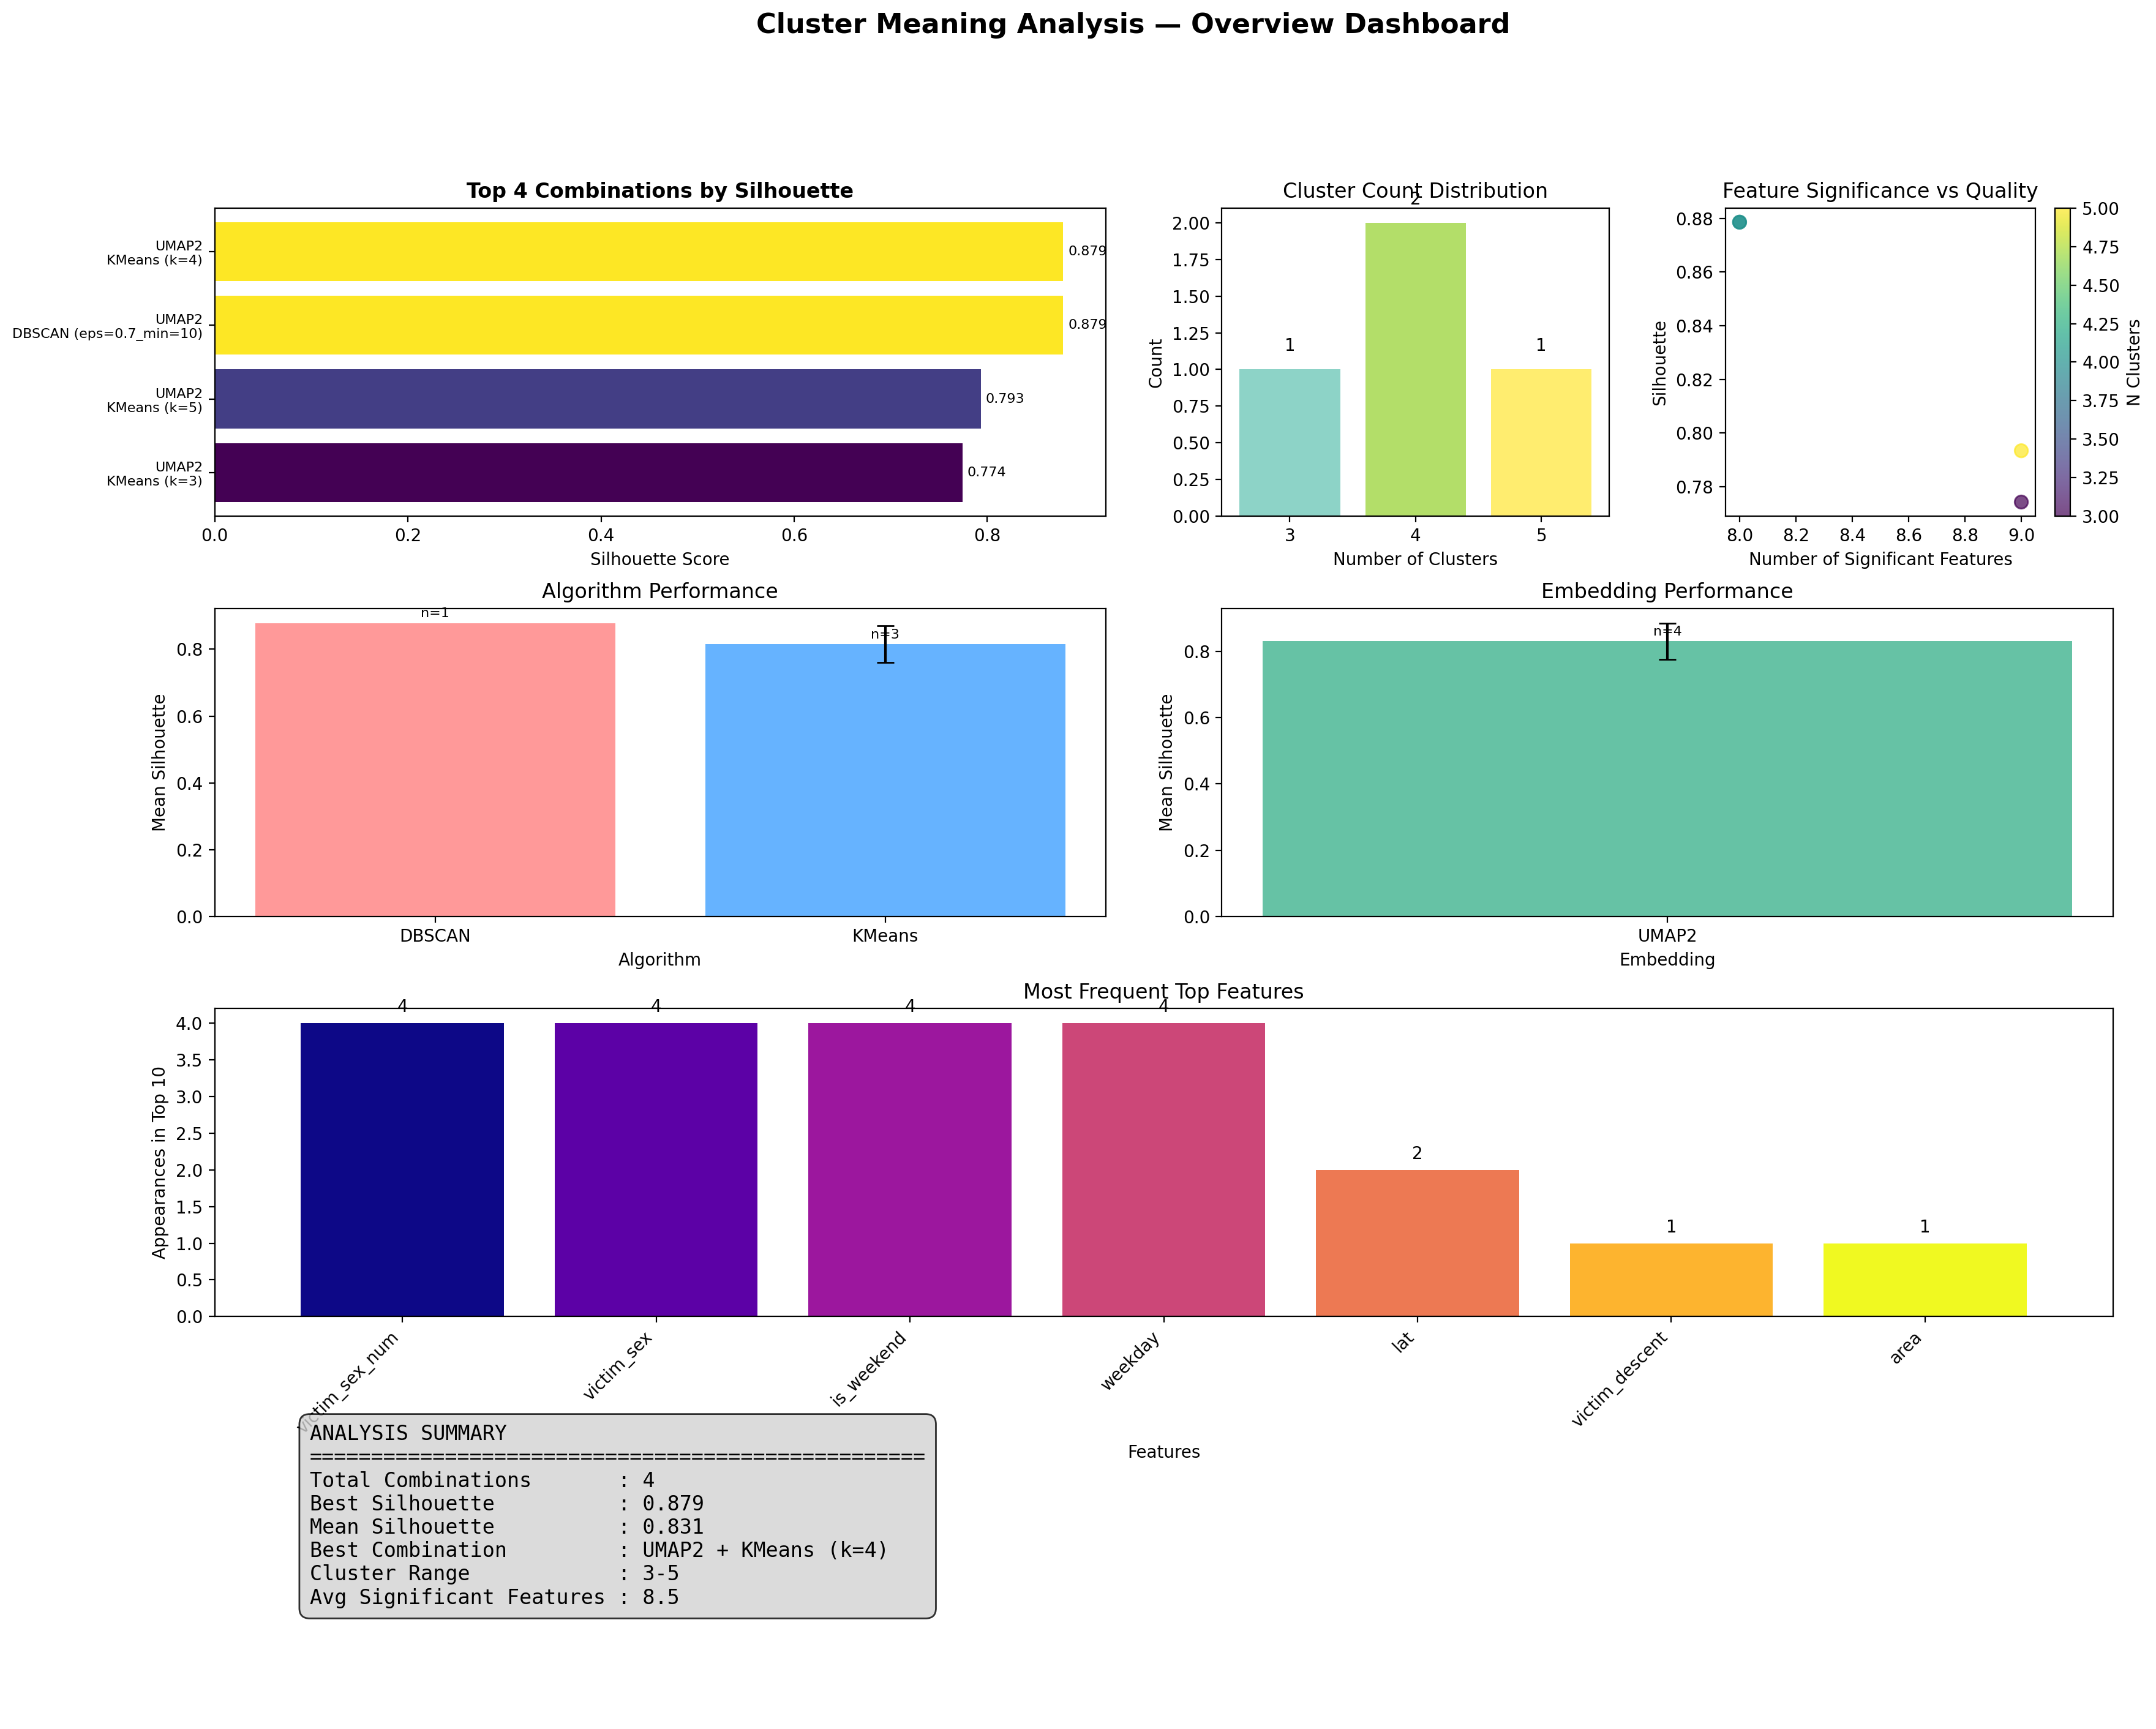

[SAVED] /content/unsup_results/meaning_analysis/plots/overview_dashboard.png
[INFO] Generating feature importance summary...
[DEBUG] Creating feature importance summary...
[DEBUG] Combo UMAP2 + KMeans (k=3): 14 MI scores
[DEBUG] Combo UMAP2 + KMeans (k=4): 14 MI scores
[DEBUG] Combo UMAP2 + KMeans (k=5): 14 MI scores
[DEBUG] Combo UMAP2 + DBSCAN (eps=0.7_min=10): 14 MI scores
[DEBUG] Total features with MI scores: 14


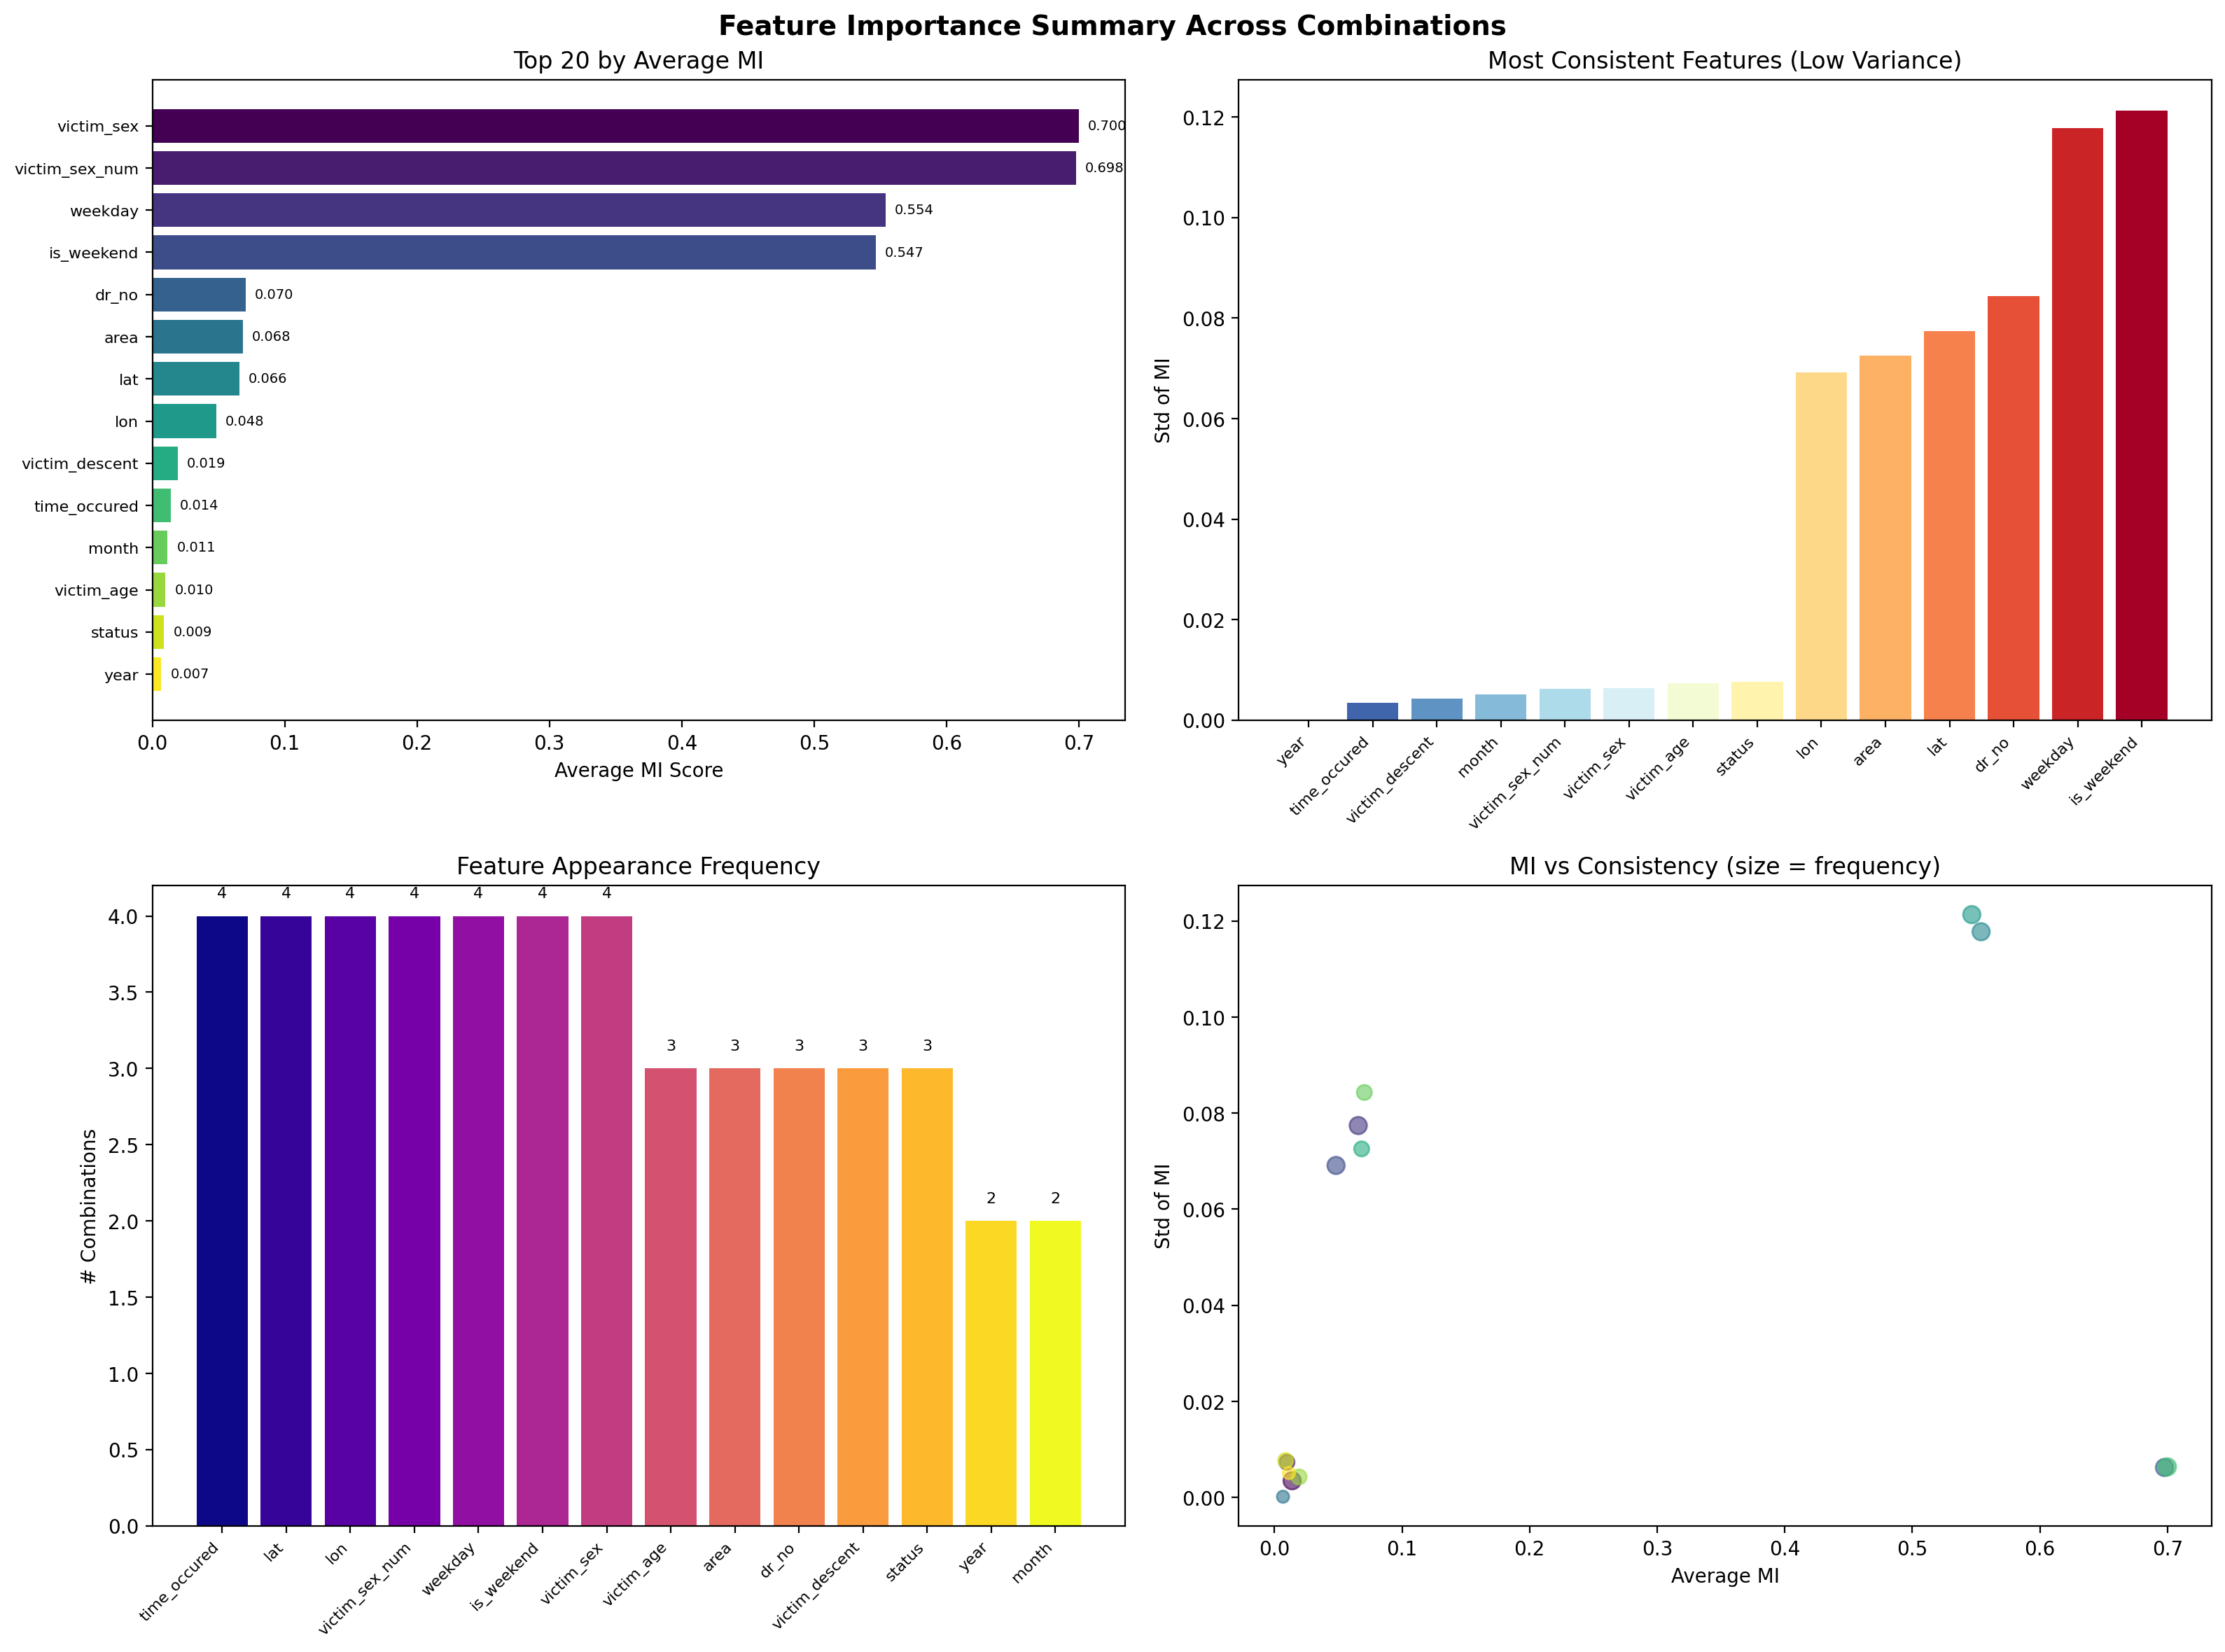

[SAVED] /content/unsup_results/meaning_analysis/plots/feature_importance_summary.png
[INFO] Generating statistical significance analysis...
[DEBUG] Creating statistical significance analysis...
[DEBUG] Found 56 valid statistical test results


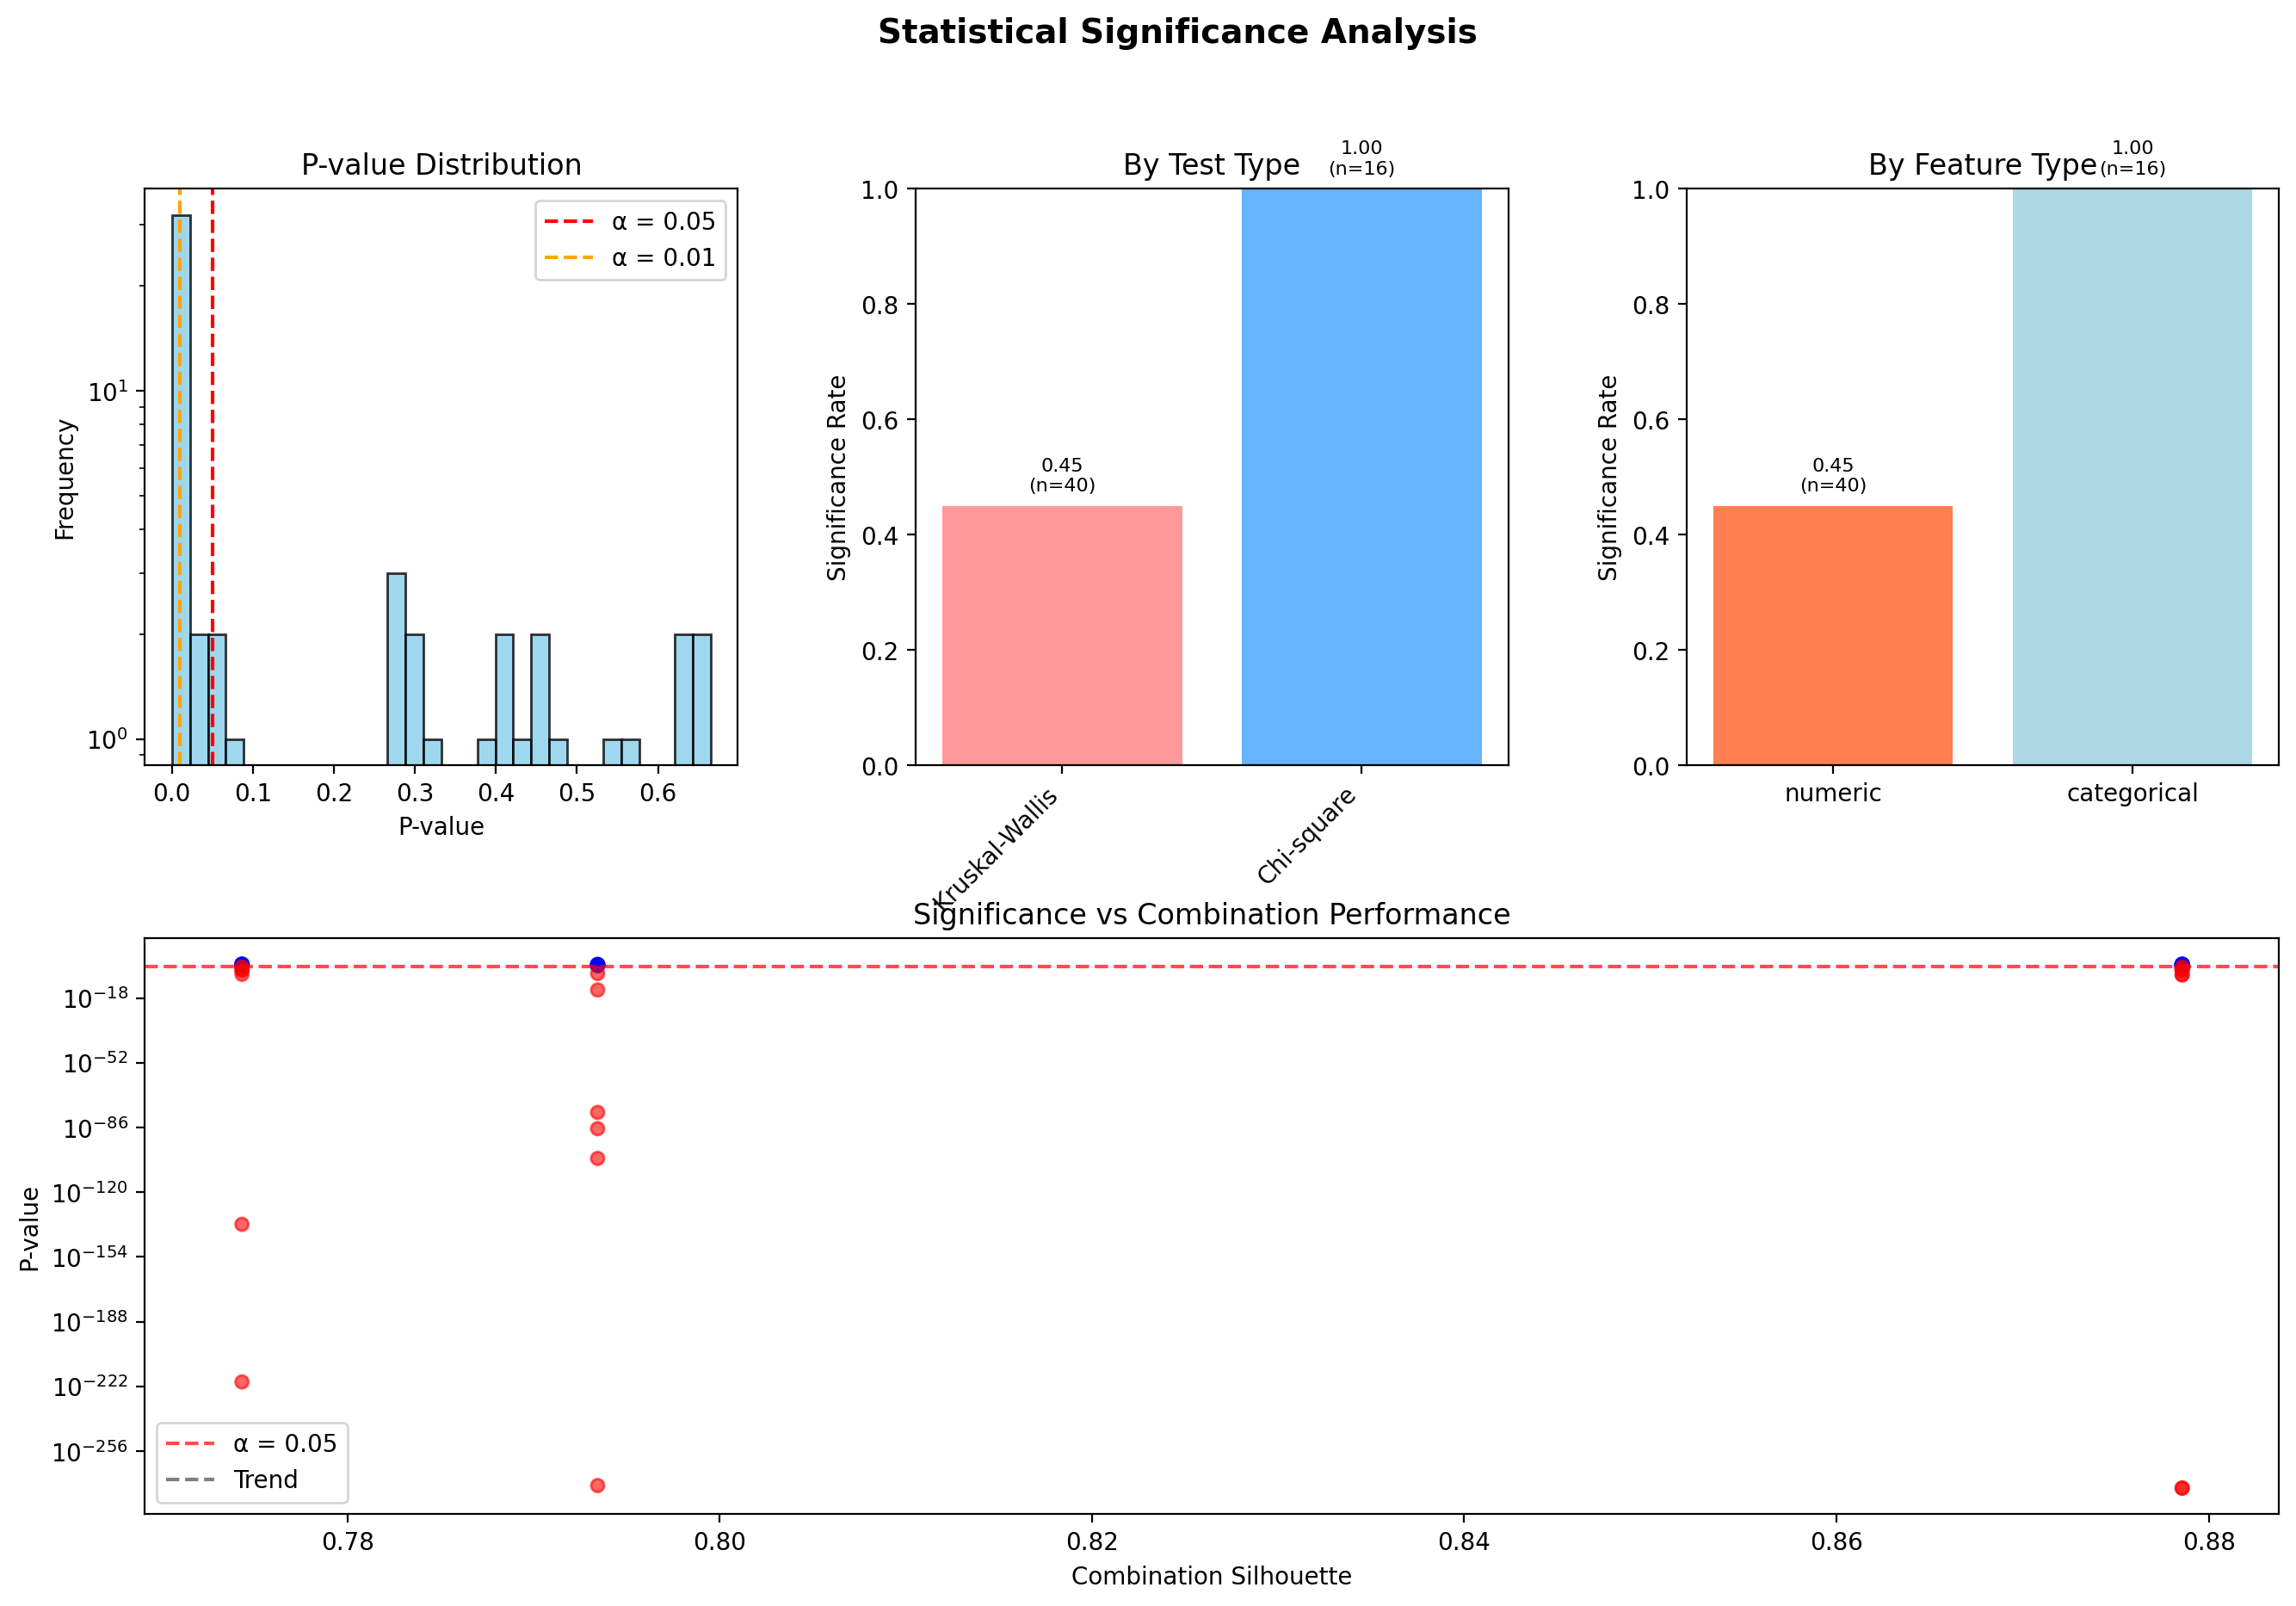

[SAVED] /content/unsup_results/meaning_analysis/plots/statistical_significance_analysis.png
[INFO] Generating detailed plots for top 5 combinations...
[DEBUG] Creating detailed plots for top 5 combinations...
[DEBUG] Processing combination 1/5: UMAP2 + KMeans (k=4)
[DEBUG] Found 4 cluster summaries and 14 MI scores


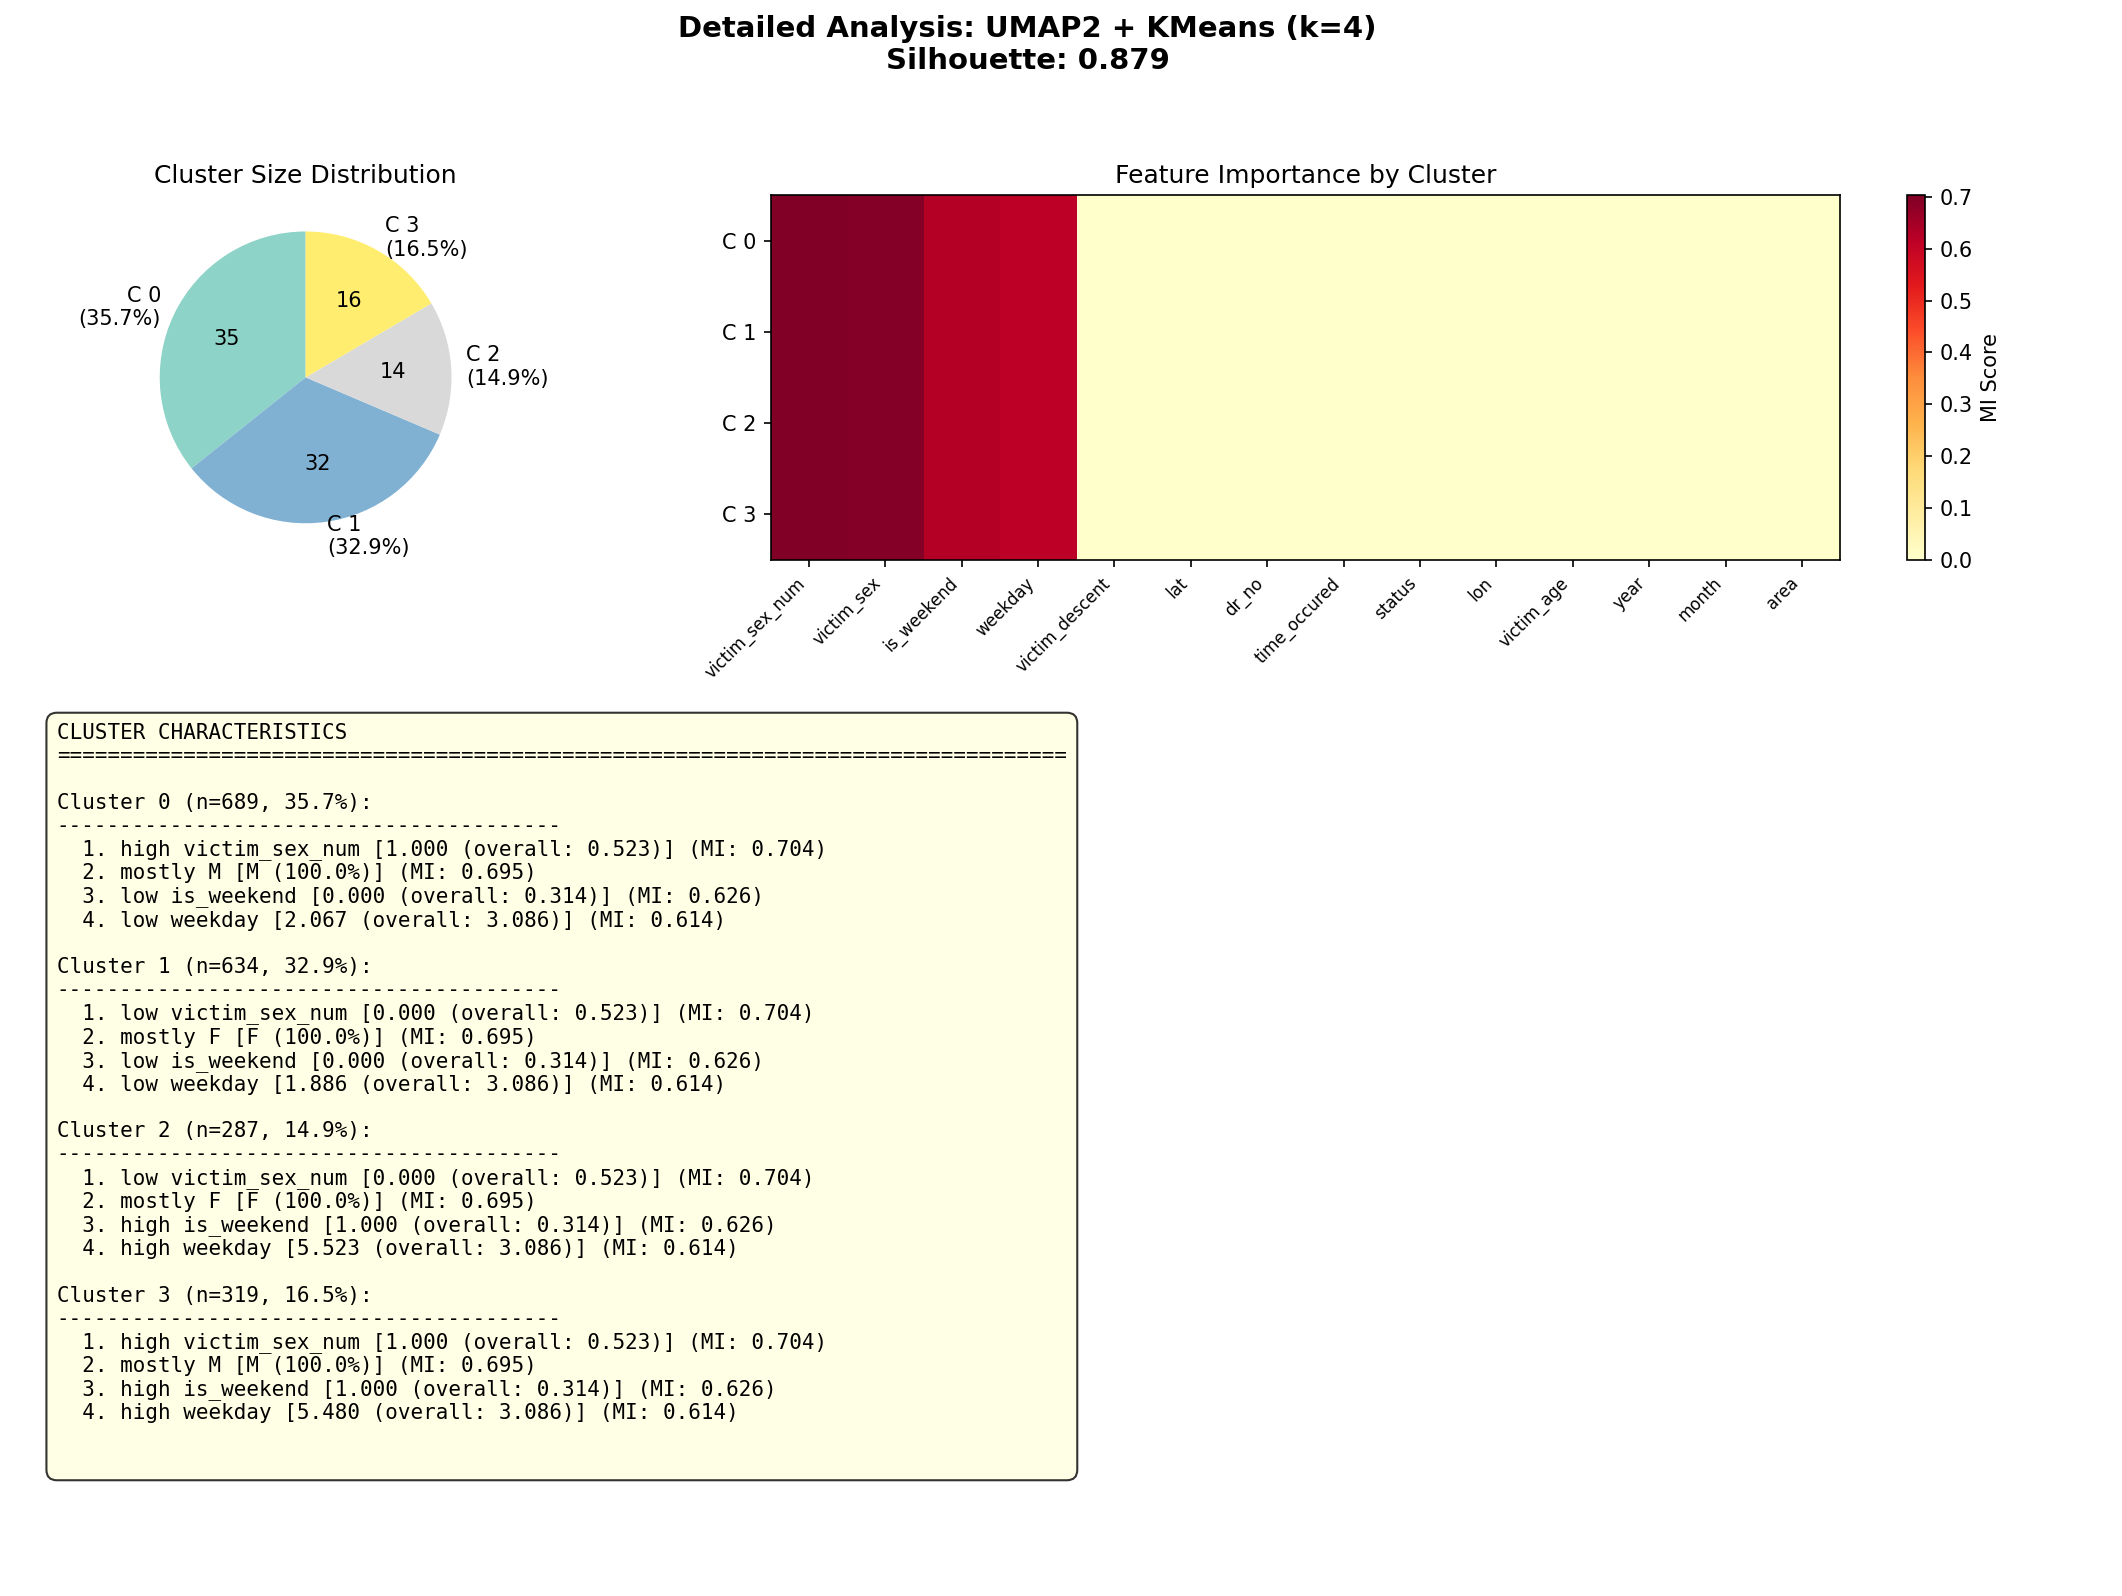

[SAVED] /content/unsup_results/meaning_analysis/plots/detailed_analysis_1_UMAP2___KMeans__k4_.png
[DEBUG] Processing combination 2/5: UMAP2 + DBSCAN (eps=0.7_min=10)
[DEBUG] Found 4 cluster summaries and 14 MI scores


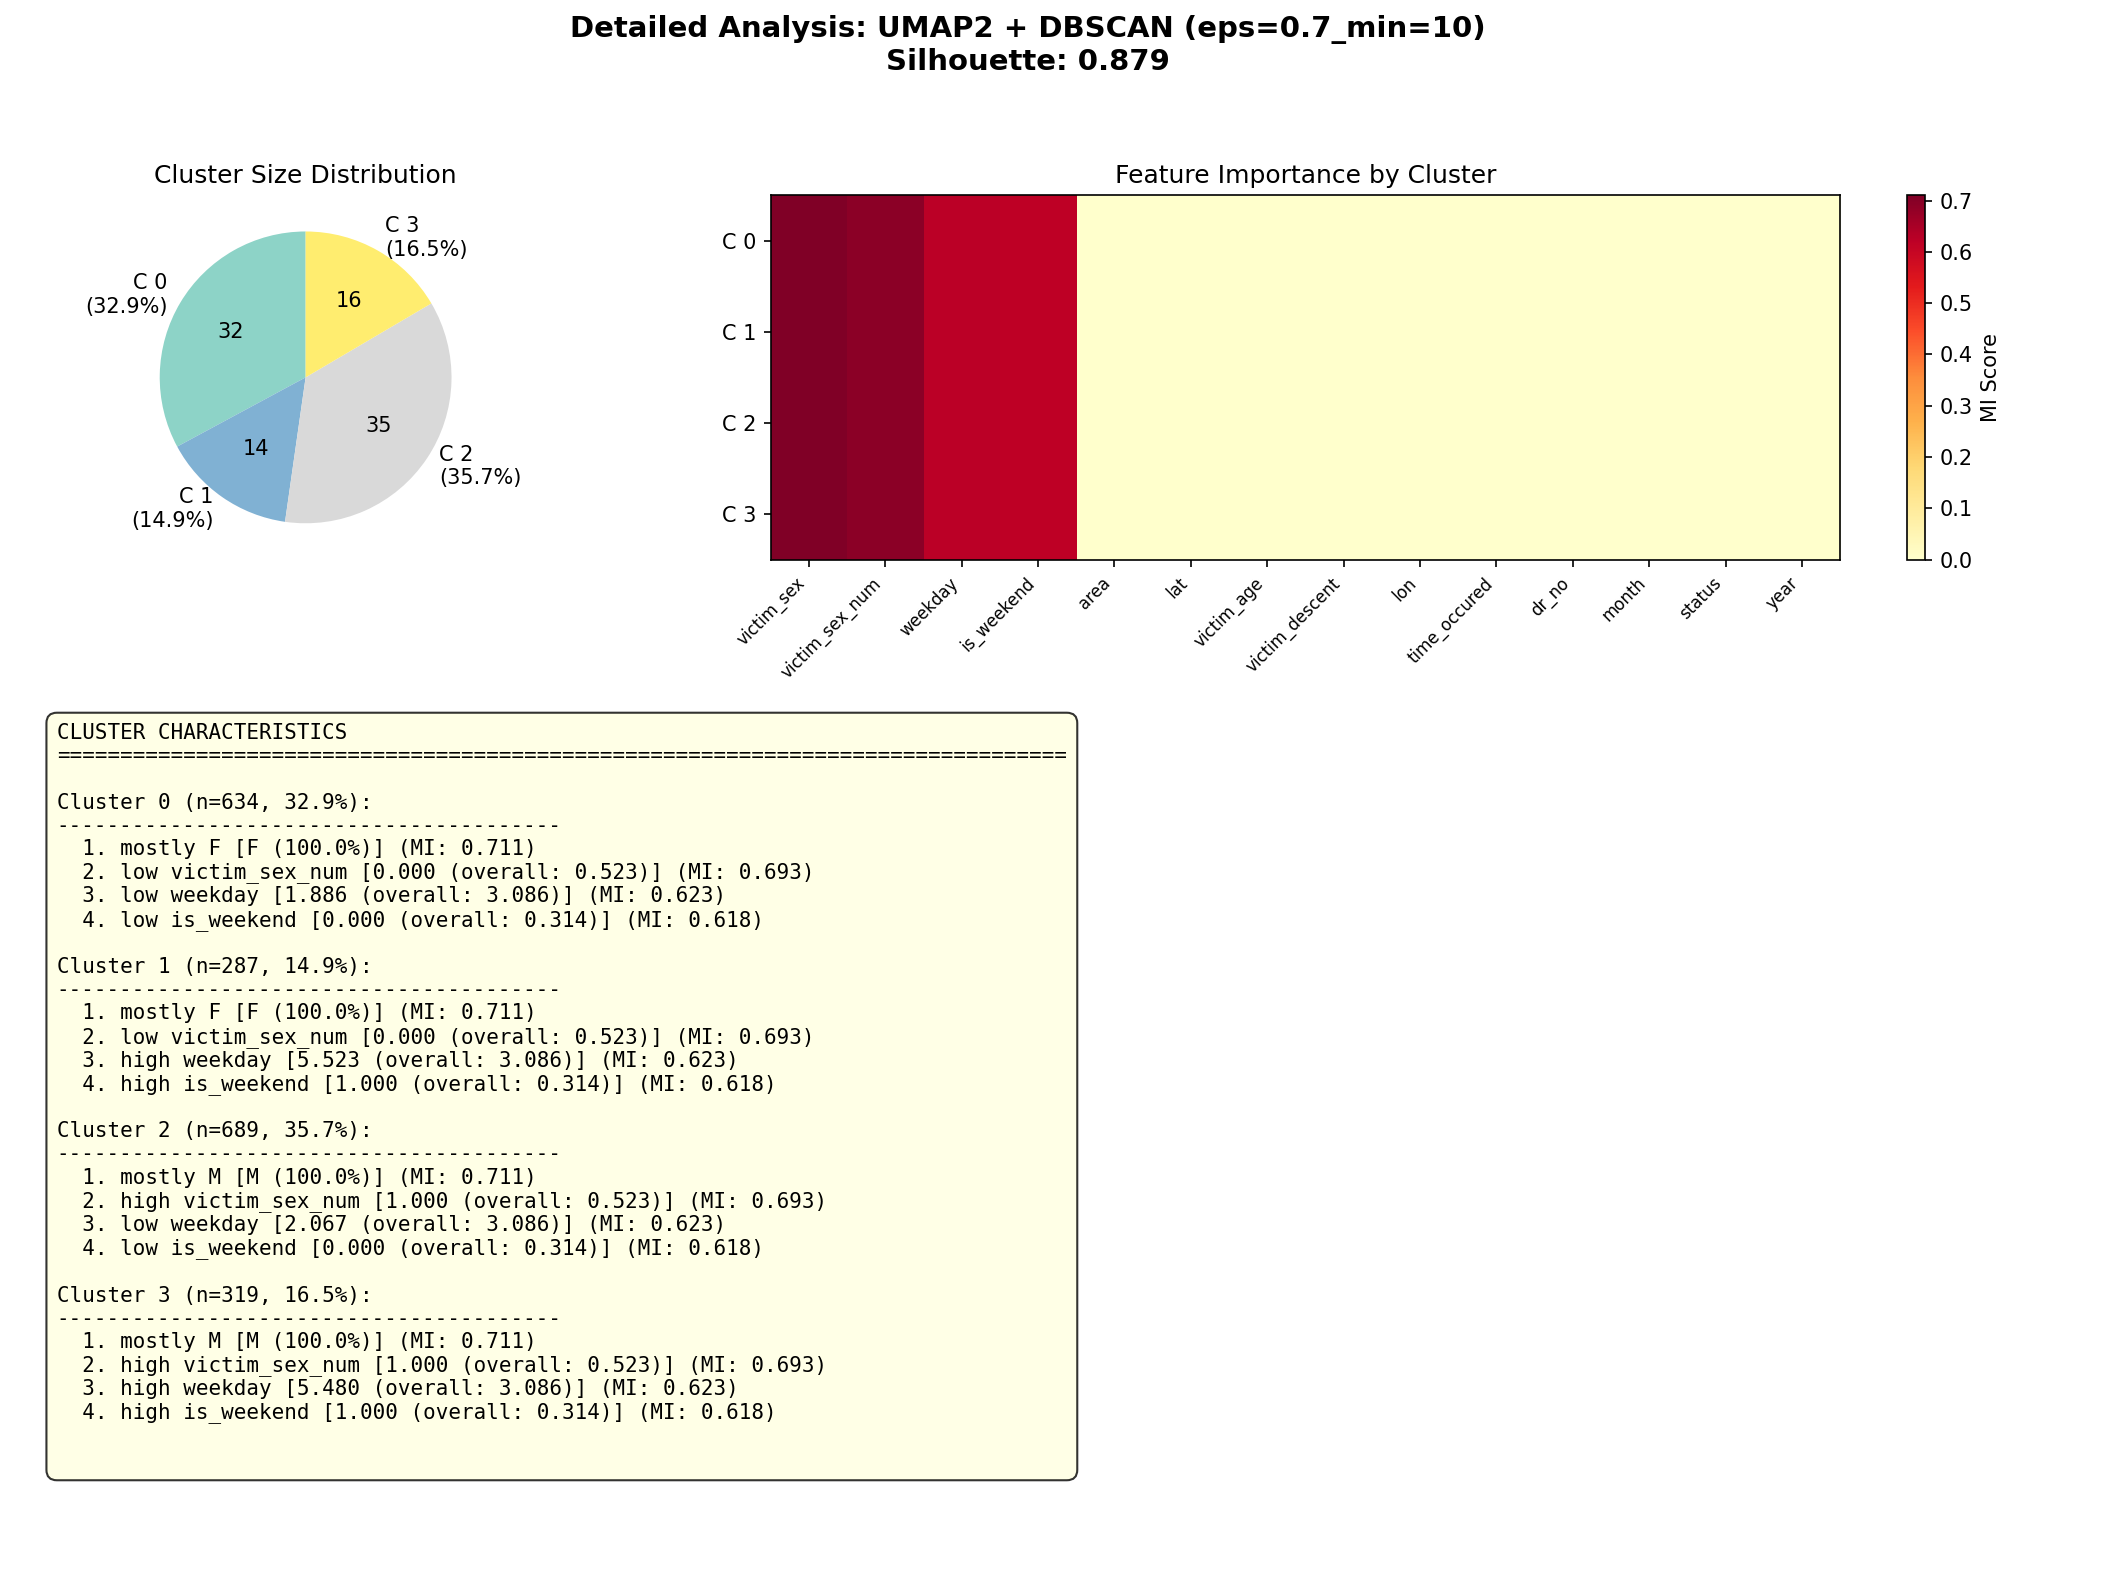

[SAVED] /content/unsup_results/meaning_analysis/plots/detailed_analysis_2_UMAP2___DBSCAN__eps0.7_min10_.png
[DEBUG] Processing combination 3/5: UMAP2 + KMeans (k=5)
[DEBUG] Found 5 cluster summaries and 14 MI scores


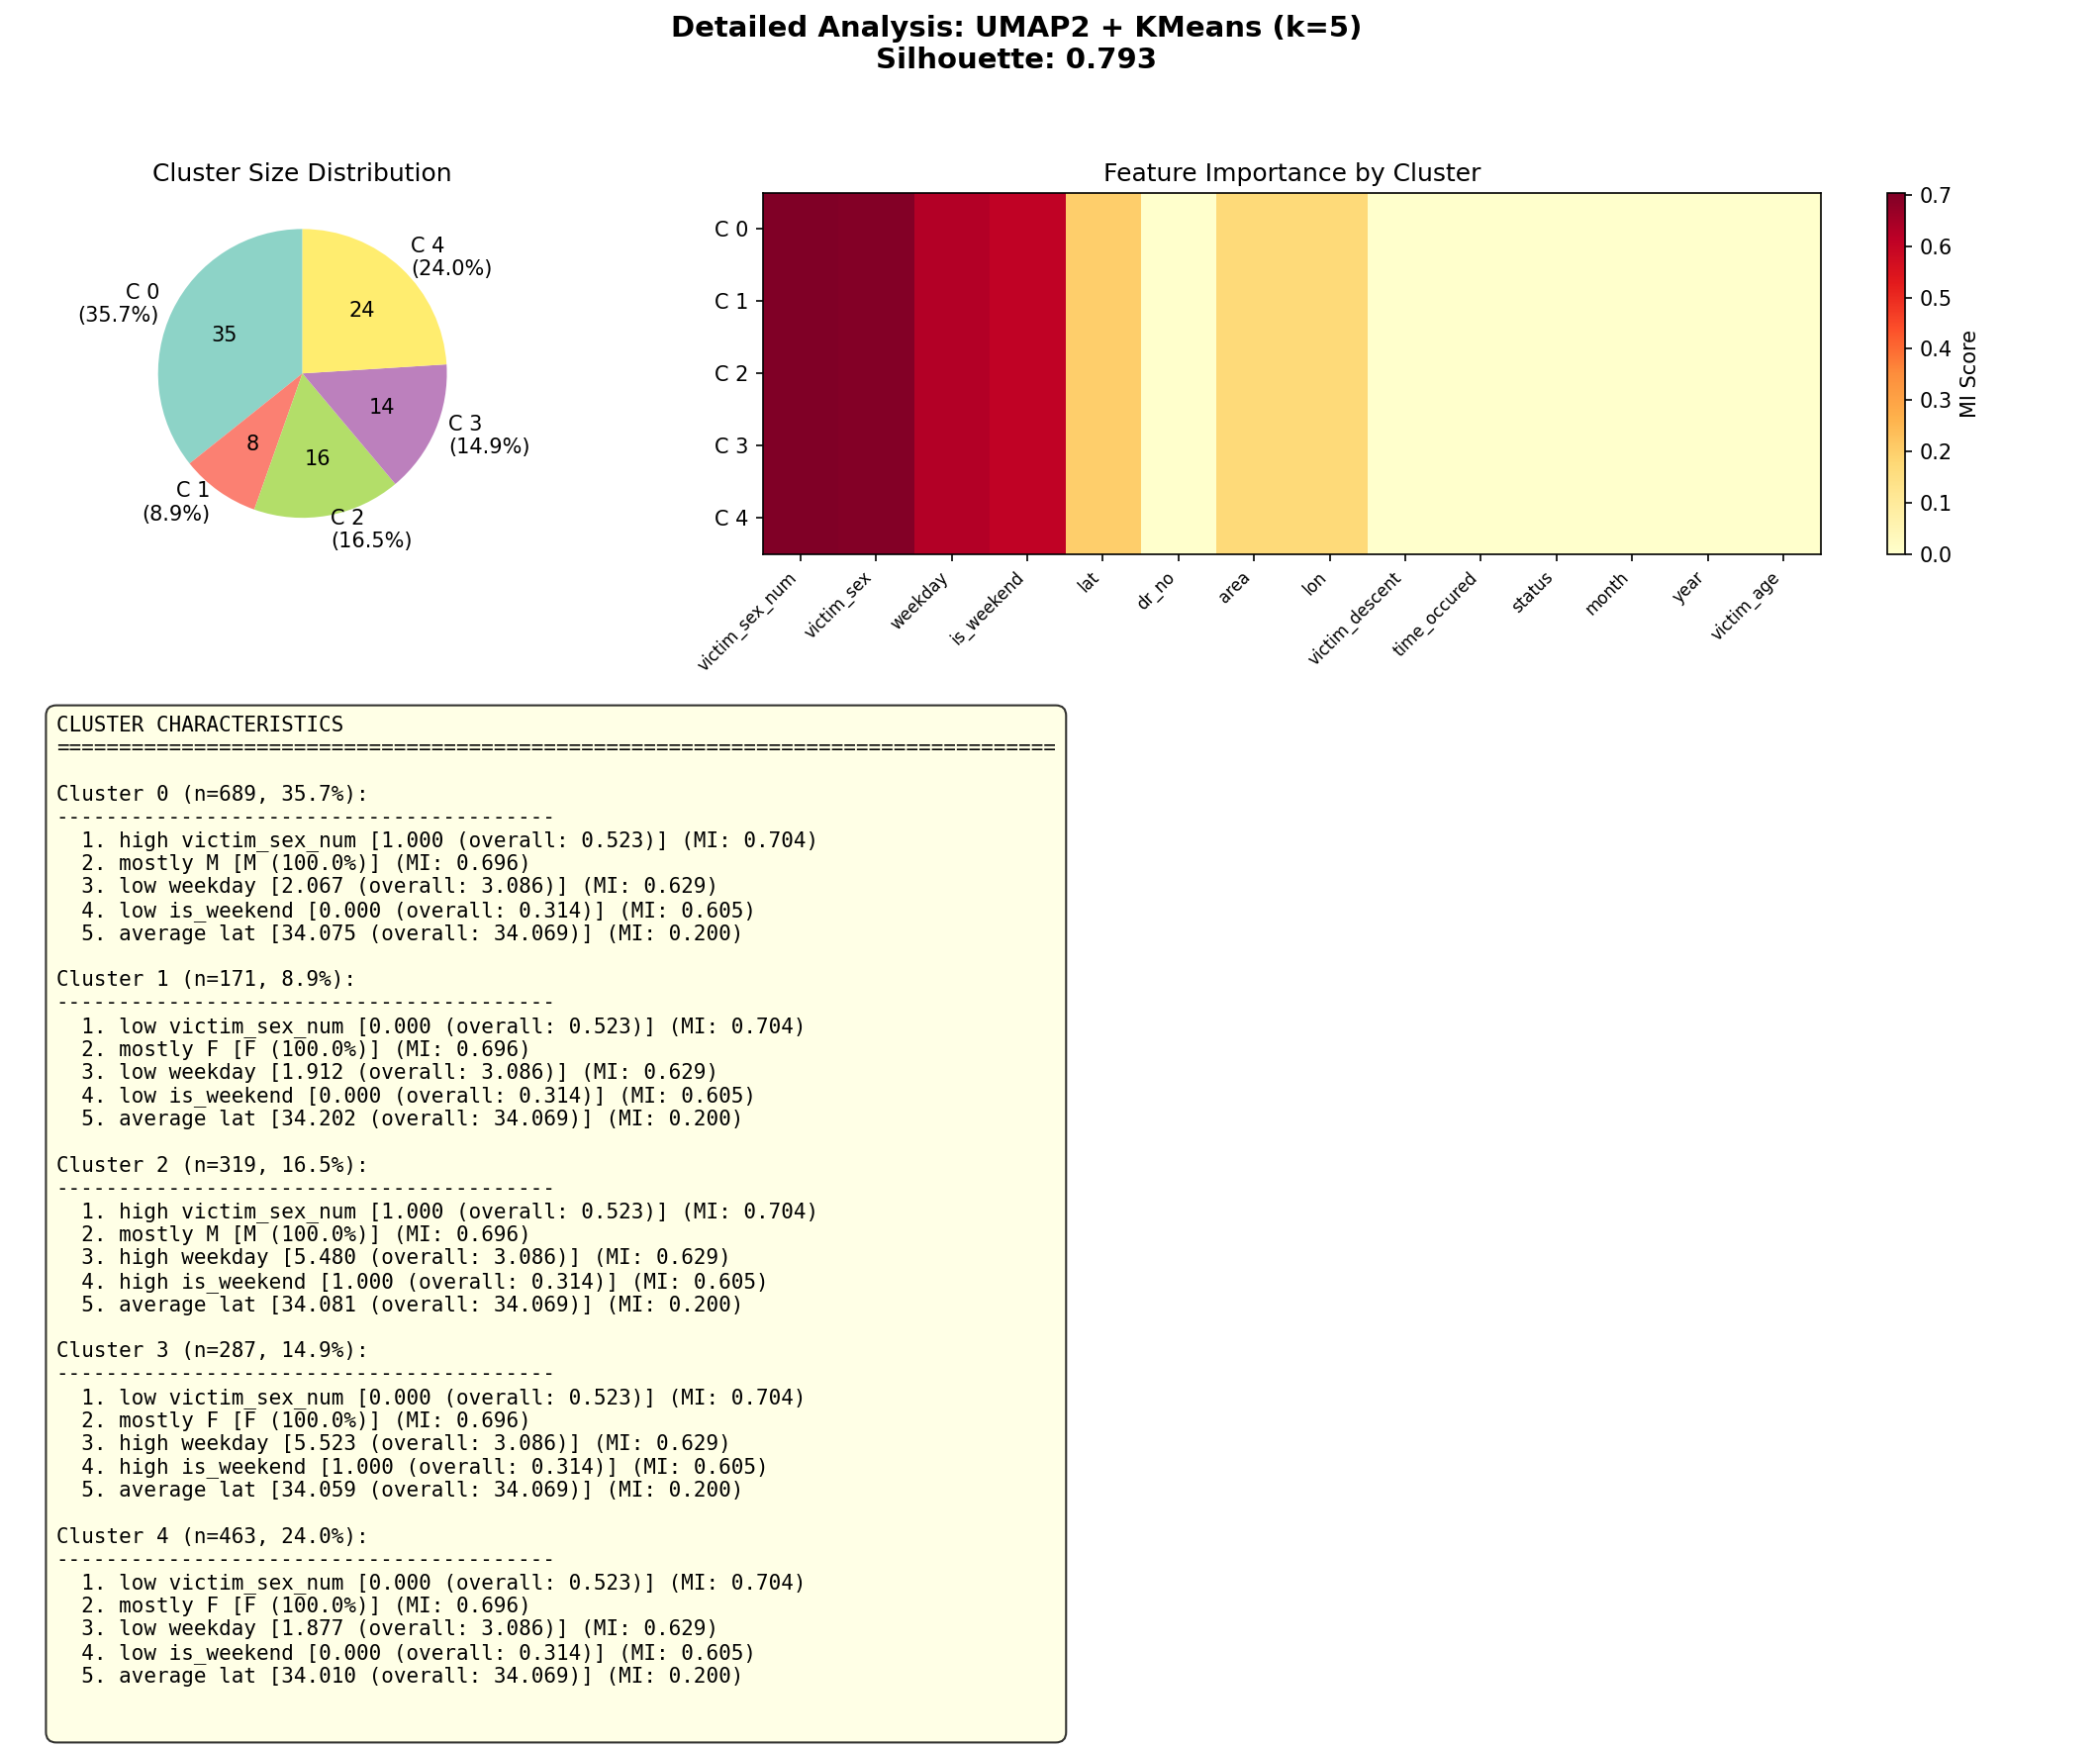

[SAVED] /content/unsup_results/meaning_analysis/plots/detailed_analysis_3_UMAP2___KMeans__k5_.png
[DEBUG] Processing combination 4/5: UMAP2 + KMeans (k=3)
[DEBUG] Found 3 cluster summaries and 14 MI scores


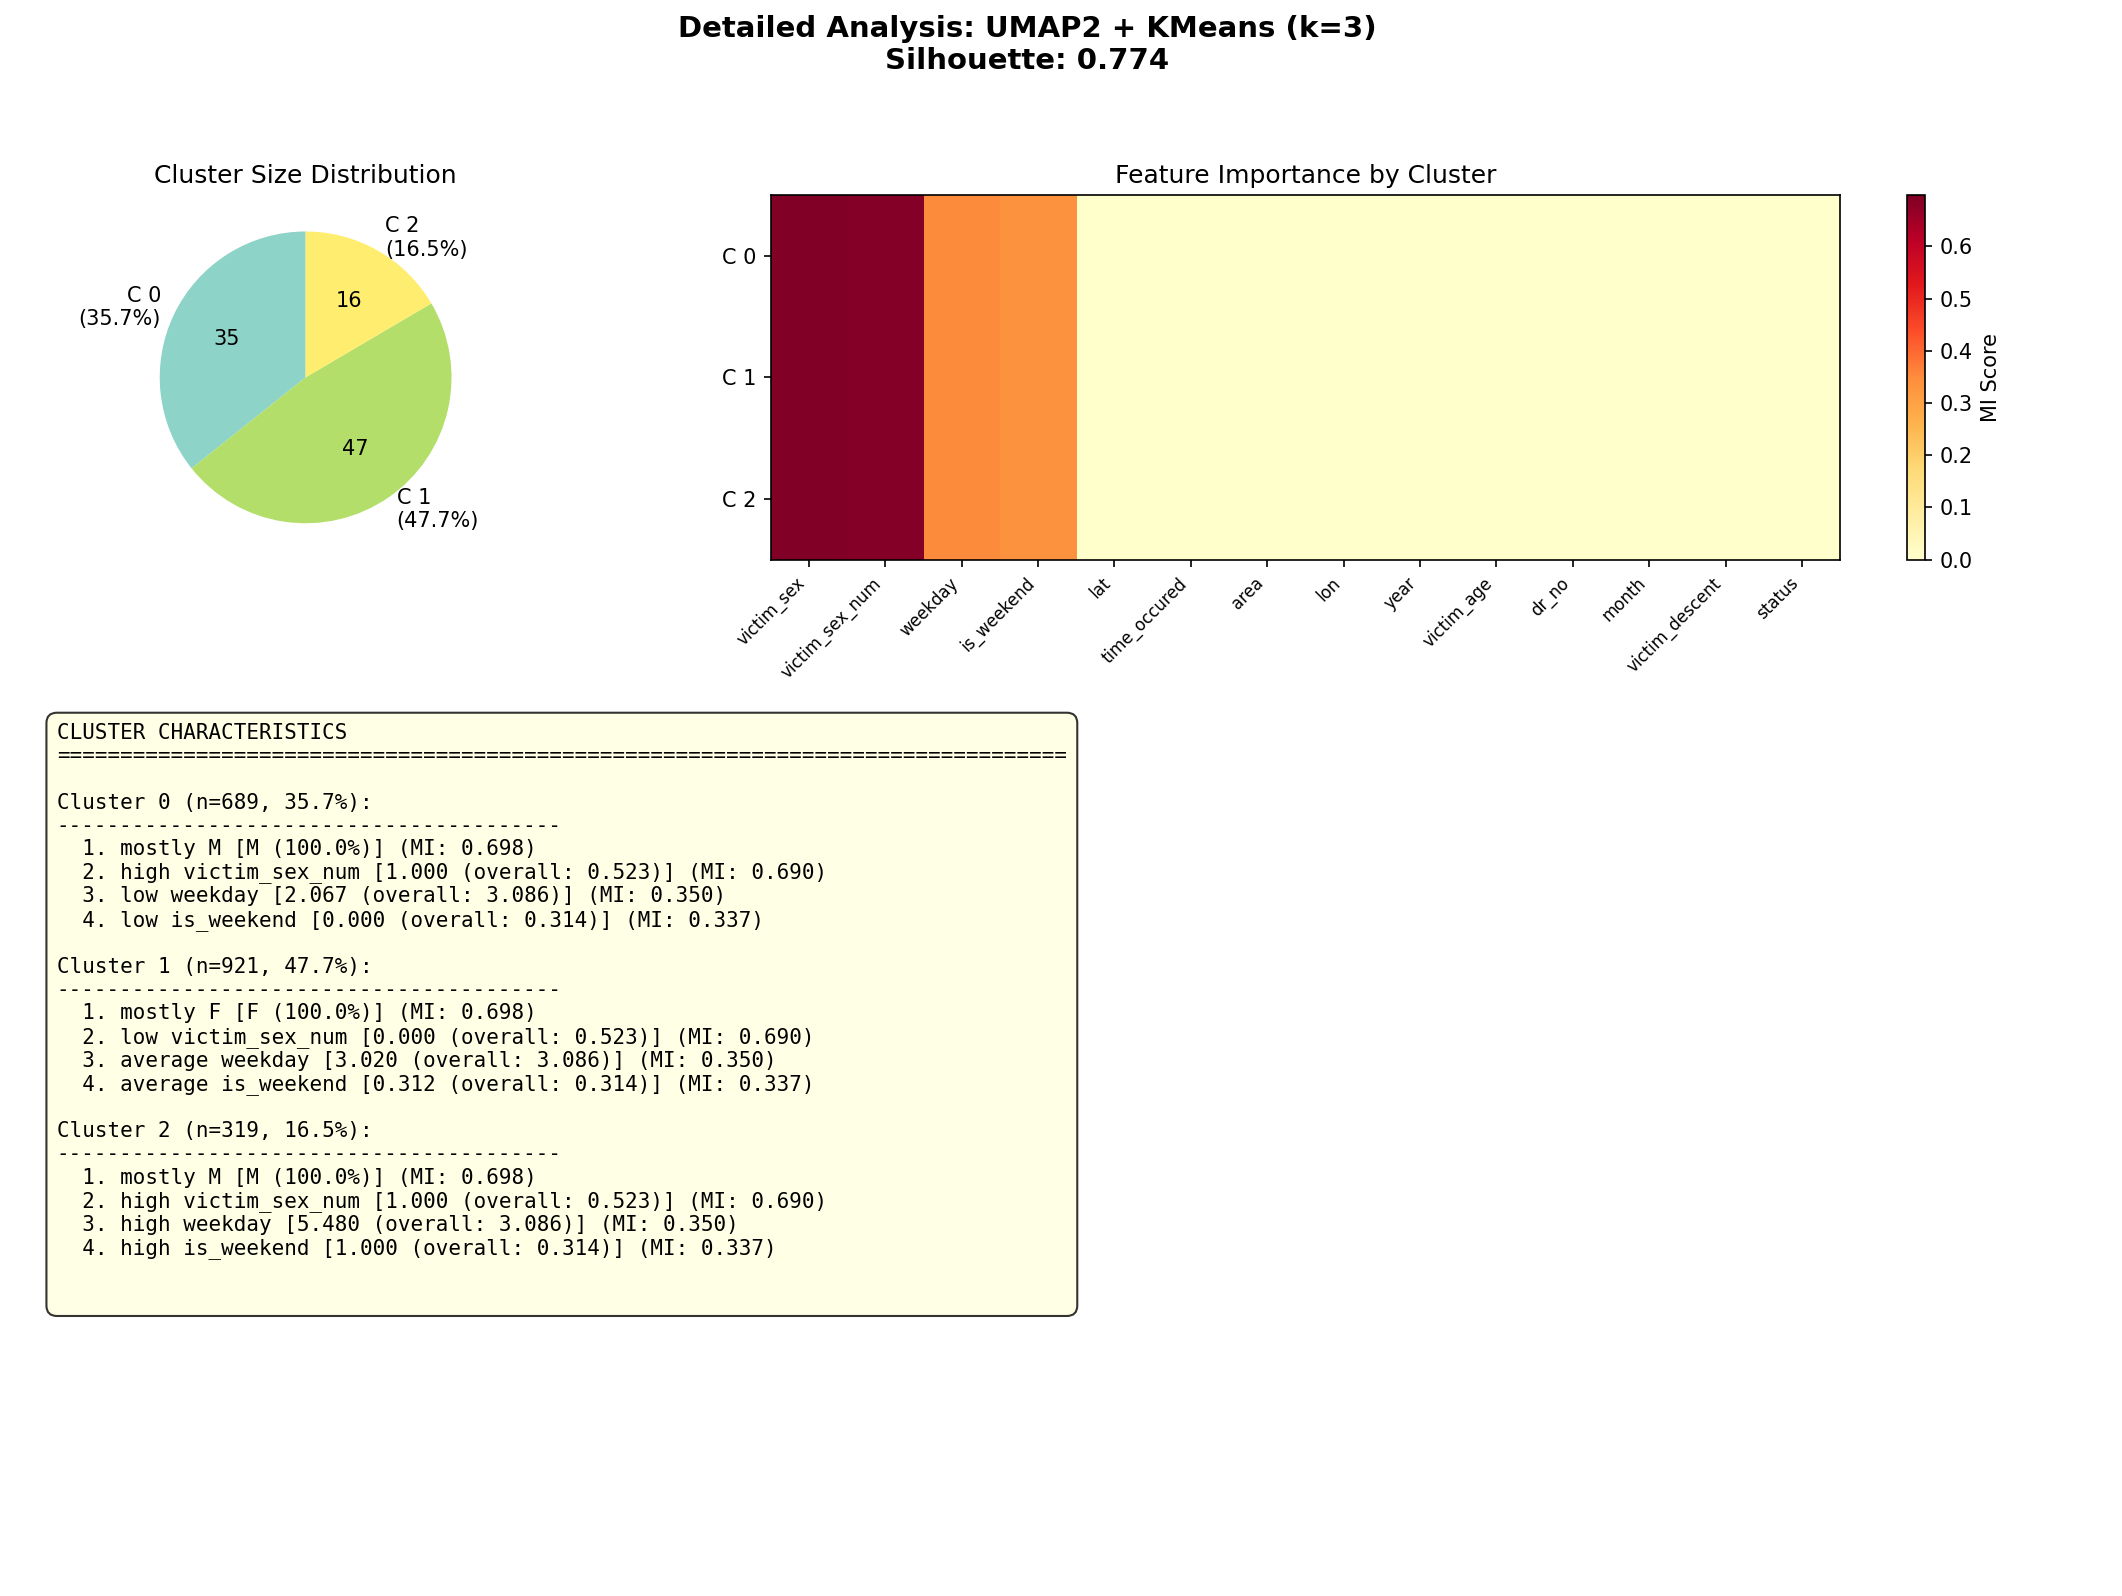

[SAVED] /content/unsup_results/meaning_analysis/plots/detailed_analysis_4_UMAP2___KMeans__k3_.png
[INFO] Creating HTML summary report...
[DEBUG] Creating HTML summary report...
[SAVED] /content/unsup_results/meaning_analysis/meaning_report.html
[INFO] Plot generation process completed!

Final Artifacts Summary:
  ✓ overview_dashboard: /content/unsup_results/meaning_analysis/plots/overview_dashboard.png
  ✓ feature_importance_summary: /content/unsup_results/meaning_analysis/plots/feature_importance_summary.png
  ✓ statistical_significance_analysis: /content/unsup_results/meaning_analysis/plots/statistical_significance_analysis.png
  ✓ detailed_plots: ['/content/unsup_results/meaning_analysis/plots/detailed_analysis_1_UMAP2___KMeans__k4_.png', '/content/unsup_results/meaning_analysis/plots/detailed_analysis_2_UMAP2___DBSCAN__eps0.7_min10_.png', '/content/unsup_results/meaning_analysis/plots/detailed_analysis_3_UMAP2___KMeans__k5_.png', '/content/unsup_results/meaning_analysis/plots/detai

In [14]:
#!/usr/bin/env python3
"""
Meaning Analysis Results Plotter - Fixed Version

Usage (notebook):
    plotter = MeaningAnalysisPlotter("/content/unsup_results/meaning_analysis", threshold=0.6, show=True)
    plotter.plot_all()

Usage (CLI):
    python plot_meaning_results.py --dir /content/unsup_results/meaning_analysis --threshold 0.6
"""
import os, json, warnings, sys
from pathlib import Path
from typing import Dict, List, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

warnings.filterwarnings("ignore")


class MeaningAnalysisPlotter:
    """Creates comprehensive visualizations from meaning analysis results."""

    def __init__(self, meaning_analysis_dir: str, threshold: float = 0.6, show: bool = True):
        self.meaning_dir = Path(meaning_analysis_dir)
        self.output_dir = self.meaning_dir / "plots"
        self.output_dir.mkdir(exist_ok=True)

        # Load data
        self.overview_df = self._load_overview()
        self.detailed_results = self._load_detailed_results()

        # Filter by silhouette
        if "silhouette" in self.overview_df.columns:
            before = len(self.overview_df)
            self.overview_df = (
                self.overview_df.loc[self.overview_df["silhouette"] >= float(threshold)]
                .sort_values("silhouette", ascending=False)
                .reset_index(drop=True)
            )
            print(f"[FILTER] Kept {len(self.overview_df)}/{before} combos with silhouette ≥ {threshold:.2f}")

        # Style + behavior
        self.show = bool(show)
        plt.style.use("default")
        sns.set_palette("husl")

        print(f"[INIT] Loaded {len(self.overview_df)} combinations for plotting")
        print(f"[DEBUG] Overview columns: {list(self.overview_df.columns)}")
        print(f"[DEBUG] Detailed results keys: {list(self.detailed_results.keys())[:5]}...")
        print(f"[SAVE] Plots will be saved to: {self.output_dir}")

    # ------------------------- loaders -------------------------
    def _load_overview(self) -> pd.DataFrame:
        overview_path = self.meaning_dir / "meaning_overview.csv"
        if not overview_path.exists():
            raise FileNotFoundError(f"Overview file not found: {overview_path}")
        df = pd.read_csv(overview_path)

        # Guard missing columns
        for col, default in [
            ("combination", None),
            ("silhouette", np.nan),
            ("n_clusters", np.nan),
            ("n_significant_features", np.nan),
            ("top_features", "")
        ]:
            if col not in df.columns:
                df[col] = default
        return df

    def _load_detailed_results(self) -> Dict[str, Any]:
        detailed_path = self.meaning_dir / "detailed_results.json"
        if not detailed_path.exists():
            print("[WARN] detailed_results.json not found; some plots will be skipped")
            return {}
        try:
            with open(detailed_path, "r") as f:
                data = json.load(f)
                print(f"[DEBUG] Loaded detailed results for {len(data)} combinations")
                if data:
                    first_key = list(data.keys())[0]
                    print(f"[DEBUG] First detailed result structure: {list(data[first_key].keys())}")
                return data
        except Exception as e:
            print(f"[WARN] Failed to read detailed_results.json: {e}")
            return {}

    # ------------------------- plots -------------------------
    def plot_overview_dashboard(self) -> str:
        if len(self.overview_df) == 0:
            print("[SKIP] No rows in overview after filtering")
            return ""

        print("[DEBUG] Creating overview dashboard...")
        fig = plt.figure(figsize=(20, 16))
        gs = GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)

        # 1. Silhouette ranking
        ax1 = fig.add_subplot(gs[0, :2])
        top_n = min(15, len(self.overview_df))
        top_combos = self.overview_df.head(top_n)
        y_pos = np.arange(len(top_combos))
        colors = plt.cm.viridis((top_combos["silhouette"] - top_combos["silhouette"].min()) /
                                max(1e-9, (top_combos["silhouette"].max() - top_combos["silhouette"].min())))
        bars = ax1.barh(y_pos, top_combos["silhouette"], color=colors)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels([c.replace(" + ", "\n") for c in top_combos["combination"]], fontsize=8)
        ax1.set_xlabel("Silhouette Score")
        ax1.set_title(f"Top {top_n} Combinations by Silhouette", fontweight="bold")
        ax1.invert_yaxis()
        for bar, val in zip(bars, top_combos["silhouette"]):
            ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f"{val:.3f}", va="center", fontsize=8)

        # 2. Number of clusters distribution
        ax2 = fig.add_subplot(gs[0, 2])
        if "n_clusters" in self.overview_df.columns and self.overview_df["n_clusters"].notna().any():
            vc = self.overview_df["n_clusters"].dropna().astype(int).value_counts().sort_index()
            bars2 = ax2.bar(vc.index, vc.values, color=plt.cm.Set3(np.linspace(0, 1, len(vc))))
            ax2.set_xlabel("Number of Clusters"); ax2.set_ylabel("Count"); ax2.set_title("Cluster Count Distribution")
            ax2.set_xticks(vc.index)
            for bar, val in zip(bars2, vc.values):
                ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.1, str(val), ha="center", va="bottom")
        else:
            ax2.text(0.5, 0.5, "n_clusters not available", ha="center", va="center", transform=ax2.transAxes)

        # 3. Significant features vs silhouette
        ax3 = fig.add_subplot(gs[0, 3])
        if "n_significant_features" in self.overview_df.columns:
            sc = ax3.scatter(self.overview_df["n_significant_features"], self.overview_df["silhouette"],
                             c=self.overview_df.get("n_clusters", 1), cmap="viridis", s=60, alpha=0.7)
            ax3.set_xlabel("Number of Significant Features"); ax3.set_ylabel("Silhouette")
            ax3.set_title("Feature Significance vs Quality")
            plt.colorbar(sc, ax=ax3, label="N Clusters")
        else:
            ax3.text(0.5, 0.5, "n_significant_features not available", ha="center", va="center", transform=ax3.transAxes)

        # 4. Algorithm performance comparison
        ax4 = fig.add_subplot(gs[1, :2])
        df_alg = self.overview_df.copy()
        df_alg["algorithm"] = df_alg["combination"].str.extract(r"\+\s*(\w+)")
        if df_alg["algorithm"].notna().any():
            algo = df_alg.groupby("algorithm")["silhouette"].agg(["mean", "std", "count"])
            xpos = np.arange(len(algo))
            bars4 = ax4.bar(xpos, algo["mean"], yerr=algo["std"], capsize=5,
                            color=["#ff9999", "#66b3ff", "#99ff99"][:len(algo)])
            ax4.set_xlabel("Algorithm"); ax4.set_ylabel("Mean Silhouette"); ax4.set_title("Algorithm Performance")
            ax4.set_xticks(xpos); ax4.set_xticklabels(algo.index)
            for bar, ct in zip(bars4, algo["count"]):
                ax4.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"n={ct}", ha="center", va="bottom", fontsize=8)
        else:
            ax4.text(0.5, 0.5, "Could not parse algorithm from combination", ha="center", va="center", transform=ax4.transAxes)

        # 5. Embedding performance
        ax5 = fig.add_subplot(gs[1, 2:])
        df_emb = self.overview_df.copy()
        df_emb["embedding"] = df_emb["combination"].str.extract(r"^(\w+)")
        if df_emb["embedding"].notna().any():
            emb = df_emb.groupby("embedding")["silhouette"].agg(["mean", "std", "count"])
            xpos = np.arange(len(emb))
            bars5 = ax5.bar(xpos, emb["mean"], yerr=emb["std"], capsize=5,
                            color=plt.cm.Set2(np.linspace(0, 1, len(emb))))
            ax5.set_xlabel("Embedding"); ax5.set_ylabel("Mean Silhouette"); ax5.set_title("Embedding Performance")
            ax5.set_xticks(xpos); ax5.set_xticklabels(emb.index)
            for bar, ct in zip(bars5, emb["count"]):
                ax5.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"n={ct}", ha="center", va="bottom", fontsize=8)
        else:
            ax5.text(0.5, 0.5, "Could not parse embedding from combination", ha="center", va="center", transform=ax5.transAxes)

        # 6. Top features frequency among top 10
        ax6 = fig.add_subplot(gs[2, :])
        feat_counts = {}
        if "top_features" in self.overview_df.columns:
            for _, r in self.overview_df.head(10).iterrows():
                feats = (r["top_features"] or "").split(", ")
                for f in feats:
                    f = f.strip()
                    if f:
                        feat_counts[f] = feat_counts.get(f, 0) + 1
        if feat_counts:
            sorted_feats = sorted(feat_counts.items(), key=lambda x: x[1], reverse=True)[:15]
            features, counts = zip(*sorted_feats)
            bars6 = ax6.bar(range(len(features)), counts, color=plt.cm.plasma(np.linspace(0, 1, len(features))))
            ax6.set_xlabel("Features"); ax6.set_ylabel("Appearances in Top 10")
            ax6.set_title("Most Frequent Top Features")
            ax6.set_xticks(range(len(features))); ax6.set_xticklabels(features, rotation=45, ha="right")
            for bar, val in zip(bars6, counts):
                ax6.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.1, str(val), ha="center", va="bottom")
        else:
            ax6.text(0.5, 0.5, "No top_features in overview", ha="center", va="center", transform=ax6.transAxes)

        # 7. Summary stats
        ax7 = fig.add_subplot(gs[3, :]); ax7.axis("off")
        summary = {
            "Total Combinations": len(self.overview_df),
            "Best Silhouette": f"{self.overview_df['silhouette'].max():.3f}",
            "Mean Silhouette": f"{self.overview_df['silhouette'].mean():.3f}",
            "Best Combination": str(self.overview_df.iloc[0]["combination"]) if len(self.overview_df) else "—",
            "Cluster Range": (f"{int(self.overview_df['n_clusters'].min())}-"
                              f"{int(self.overview_df['n_clusters'].max())}") if "n_clusters" in self.overview_df and self.overview_df['n_clusters'].notna().any() else "—",
            "Avg Significant Features": (f"{self.overview_df['n_significant_features'].mean():.1f}"
                                         if "n_significant_features" in self.overview_df and self.overview_df['n_significant_features'].notna().any() else "—")
        }
        txt = "ANALYSIS SUMMARY\n" + "="*50 + "\n" + "\n".join([f"{k:25}: {v}" for k, v in summary.items()])
        ax7.text(0.05, 0.95, txt, transform=ax7.transAxes, fontsize=12, va="top",
                 fontfamily="monospace", bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.suptitle("Cluster Meaning Analysis — Overview Dashboard", fontsize=16, fontweight="bold", y=0.98)
        out = self.output_dir / "overview_dashboard.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.close()
        if self.show:
            try:
                from IPython.display import display, Image
                display(Image(filename=str(out)))
            except ImportError:
                print(f"[INFO] IPython not available, saved to {out}")
        print(f"[SAVED] {out}")
        return str(out)

    def plot_detailed_cluster_analysis(self, top_n: int = 5) -> List[str]:
        paths = []
        if not self.detailed_results:
            print("[SKIP] No detailed_results.json → skipping detailed plots")
            return paths

        print(f"[DEBUG] Creating detailed plots for top {top_n} combinations...")

        for idx, (_, row) in enumerate(self.overview_df.head(top_n).iterrows()):
            combo = row["combination"]
            print(f"[DEBUG] Processing combination {idx+1}/{top_n}: {combo}")

            if combo not in self.detailed_results:
                print(f"[WARN] Combination '{combo}' not found in detailed results")
                continue

            detailed = self.detailed_results[combo]
            cluster_summ = detailed.get("cluster_summaries", {})
            mi_scores = detailed.get("mi_scores", {})

            print(f"[DEBUG] Found {len(cluster_summ)} cluster summaries and {len(mi_scores)} MI scores")

            fig = plt.figure(figsize=(18, 12))
            gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)
            fig.suptitle(f"Detailed Analysis: {combo}\nSilhouette: {row['silhouette']:.3f}", fontsize=14, fontweight="bold")

            # 1) Pie of cluster sizes
            ax1 = fig.add_subplot(gs[0, 0])
            if cluster_summ:
                sizes = [info.get("size", 0) for info in cluster_summ.values()]
                labels = [f"C {cid.split('_')[-1] if '_' in cid else cid}\n({info.get('percentage', 0):.1f}%)"
                         for cid, info in cluster_summ.items()]
                if sum(sizes) > 0:  # Only create pie if we have data
                    ax1.pie(sizes, labels=labels, autopct="%d", colors=plt.cm.Set3(np.linspace(0,1,len(sizes))), startangle=90)
                    ax1.set_title("Cluster Size Distribution")
                else:
                    ax1.text(0.5, 0.5, "No cluster size data", ha="center", va="center", transform=ax1.transAxes)
            else:
                ax1.text(0.5, 0.5, "No cluster summaries", ha="center", va="center", transform=ax1.transAxes)

            # 2) Feature importance heatmap by cluster
            ax2 = fig.add_subplot(gs[0, 1:])
            if cluster_summ and mi_scores:
                # Filter and convert MI scores to ensure they're numeric
                numeric_mi_scores = {}
                for f, score in mi_scores.items():
                    try:
                        numeric_score = float(score)
                        if not np.isnan(numeric_score):
                            numeric_mi_scores[f] = numeric_score
                    except (ValueError, TypeError):
                        continue  # Skip non-numeric scores

                if numeric_mi_scores:
                    top_feat = [f for f, _ in sorted(numeric_mi_scores.items(), key=lambda x: x[1], reverse=True)[:15]]
                mat = []
                row_labels = []
                for cid, info in cluster_summ.items():
                    row_labels.append(f"C {cid.split('_')[-1] if '_' in cid else cid}")
                    row_vals = []
                    chars = info.get("all_characteristics", [])
                    for feat in top_feat:
                        m = 0.0
                        for ch in chars:
                            if ch.get("feature") == feat:
                                m = ch.get("mi_score", 0.0)
                                break
                        row_vals.append(m)
                    mat.append(row_vals)

                if mat and len(mat[0]) > 0:  # Check if we have valid data
                    im = ax2.imshow(mat, cmap="YlOrRd", aspect="auto")
                    ax2.set_xticks(range(len(top_feat))); ax2.set_xticklabels(top_feat, rotation=45, ha="right", fontsize=8)
                    ax2.set_yticks(range(len(row_labels))); ax2.set_yticklabels(row_labels)
                    ax2.set_title("Feature Importance by Cluster")
                    plt.colorbar(im, ax=ax2, label="MI Score")
                else:
                    ax2.text(0.5, 0.5, "No feature matrix data", ha="center", va="center", transform=ax2.transAxes)
            else:
                ax2.text(0.5, 0.5, "No MI/cluster details", ha="center", va="center", transform=ax2.transAxes)

            # 3) Characteristics text
            ax3 = fig.add_subplot(gs[1:, :]); ax3.axis("off")
            text = "CLUSTER CHARACTERISTICS\n" + "="*80 + "\n\n"
            if cluster_summ:
                for cid, info in cluster_summ.items():
                    cnum = cid.split("_")[-1] if "_" in cid else cid
                    text += f"Cluster {cnum} (n={info.get('size', 0)}, {info.get('percentage', 0):.1f}%):\n"
                    text += "-" * 40 + "\n"
                    top_chars = info.get("top_characteristics", [])
                    if top_chars:
                        for i, ch in enumerate(top_chars[:8]):
                            desc = ch.get("description", "No description")
                            val = ch.get("value", "No value")
                            mi = ch.get("mi_score", 0.0)
                            text += f"  {i+1}. {desc} [{val}] (MI: {mi:.3f})\n"
                    else:
                        text += "  No characteristics available\n"
                    text += "\n"
            else:
                text += "(no cluster details available)\n"

            ax3.text(0.02, 0.98, text, transform=ax3.transAxes, fontsize=10, va="top",
                     fontfamily="monospace", bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

            safe = combo.replace("+", "_").replace("(", "_").replace(")", "_").replace(" ", "_").replace("=", "").replace("/", "_")
            out = self.output_dir / f"detailed_analysis_{idx+1}_{safe}.png"
            plt.savefig(out, dpi=150, bbox_inches="tight")
            plt.close()

            if self.show:
                try:
                    from IPython.display import display, Image
                    display(Image(filename=str(out)))
                except ImportError:
                    print(f"[INFO] IPython not available, saved to {out}")
            print(f"[SAVED] {out}")
            paths.append(str(out))
        return paths

    def plot_feature_importance_summary(self) -> str:
        if not self.detailed_results:
            print("[SKIP] No detailed_results.json → skipping feature importance summary")
            return ""

        print("[DEBUG] Creating feature importance summary...")

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        all_mi = {}
        freq = {}
        for combo, det in self.detailed_results.items():
            mi_scores = det.get("mi_scores", {})
            print(f"[DEBUG] Combo {combo}: {len(mi_scores)} MI scores")
            for f, s in mi_scores.items():
                if isinstance(s, (int, float)) and not np.isnan(s):  # Valid numeric score
                    all_mi.setdefault(f, []).append(float(s))
                    freq[f] = freq.get(f, 0) + 1

        print(f"[DEBUG] Total features with MI scores: {len(all_mi)}")

        if not all_mi:
            # Create empty plots with message
            for ax in [ax1, ax2, ax3, ax4]:
                ax.text(0.5, 0.5, "No MI scores available", ha="center", va="center", transform=ax.transAxes)
            plt.suptitle("Feature Importance Summary - No Data Available", fontsize=14, fontweight="bold")
        else:
            # 1) Avg MI
            avg = {f: float(np.mean(v)) for f, v in all_mi.items()}
            top = sorted(avg.items(), key=lambda x: x[1], reverse=True)[:20]
            if top:
                feats, scores = zip(*top)
                b = ax1.barh(range(len(feats)), scores, color=plt.cm.viridis(np.linspace(0,1,len(feats))))
                ax1.set_yticks(range(len(feats))); ax1.set_yticklabels(feats, fontsize=8)
                ax1.set_xlabel("Average MI Score"); ax1.set_title("Top 20 by Average MI"); ax1.invert_yaxis()
                for bar, sc in zip(b, scores):
                    ax1.text(sc + max(scores)*0.01, bar.get_y()+bar.get_height()/2, f"{sc:.3f}", va="center", fontsize=7)
            else:
                ax1.text(0.5, 0.5, "No average MI data", ha="center", va="center", transform=ax1.transAxes)

            # 2) Consistency (std)
            std = {f: float(np.std(v)) for f, v in all_mi.items() if len(v) > 1}
            if std:
                cons = sorted(std.items(), key=lambda x: x[1])[:15]
                feats, stds = zip(*cons)
                b2 = ax2.bar(range(len(feats)), stds, color=plt.cm.RdYlBu_r(np.linspace(0,1,len(feats))))
                ax2.set_xticks(range(len(feats))); ax2.set_xticklabels(feats, rotation=45, ha="right", fontsize=8)
                ax2.set_ylabel("Std of MI"); ax2.set_title("Most Consistent Features (Low Variance)")
            else:
                ax2.text(0.5, 0.5, "No consistency data", ha="center", va="center", transform=ax2.transAxes)

            # 3) Frequency
            freq_sorted = sorted(freq.items(), key=lambda x: x[1], reverse=True)[:20]
            if freq_sorted:
                feats, counts = zip(*freq_sorted)
                b3 = ax3.bar(range(len(feats)), counts, color=plt.cm.plasma(np.linspace(0,1,len(feats))))
                ax3.set_xticks(range(len(feats))); ax3.set_xticklabels(feats, rotation=45, ha="right", fontsize=8)
                ax3.set_ylabel("# Combinations"); ax3.set_title("Feature Appearance Frequency")
                for bar, ct in zip(b3, counts):
                    ax3.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.1, str(ct), ha="center", va="bottom", fontsize=8)
            else:
                ax3.text(0.5, 0.5, "No frequency data", ha="center", va="center", transform=ax3.transAxes)

            # 4) Avg vs Std scatter
            feats_scatter = [f for f in avg if f in std]
            if feats_scatter:
                x = [avg[f] for f in feats_scatter]
                y = [std[f] for f in feats_scatter]
                sizes = [freq.get(f,1)*20 for f in feats_scatter]
                sc = ax4.scatter(x, y, s=sizes, alpha=0.6, c=np.linspace(0,1,len(feats_scatter)), cmap="viridis")
                ax4.set_xlabel("Average MI"); ax4.set_ylabel("Std of MI")
                ax4.set_title("MI vs Consistency (size = frequency)")
            else:
                ax4.text(0.5, 0.5, "No scatter data", ha="center", va="center", transform=ax4.transAxes)

            plt.suptitle("Feature Importance Summary Across Combinations", fontsize=14, fontweight="bold")

        plt.tight_layout()
        out = self.output_dir / "feature_importance_summary.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.close()

        if self.show:
            try:
                from IPython.display import display, Image
                display(Image(filename=str(out)))
            except ImportError:
                print(f"[INFO] IPython not available, saved to {out}")
        print(f"[SAVED] {out}")
        return str(out)

    def plot_statistical_significance_analysis(self) -> str:
        print("[DEBUG] Creating statistical significance analysis...")

        # Expecting per-feature p-values in detailed_results[combo]["statistical_tests"][feature]
        # If missing, skip gracefully.
        pvals, tests, ftypes, combos = [], [], [], []
        for combo, det in self.detailed_results.items():
            stat_tests = det.get("statistical_tests", {})
            for feat, res in stat_tests.items():
                if isinstance(res, dict) and "p_value" in res and "test" in res:
                    try:
                        p_val = float(res["p_value"])
                        if not np.isnan(p_val):
                            pvals.append(p_val)
                            tests.append(res["test"])
                            ftypes.append(res.get("feature_type", "unknown"))
                            combos.append(combo)
                    except (ValueError, TypeError):
                        continue  # Skip invalid p-values

        print(f"[DEBUG] Found {len(pvals)} valid statistical test results")

        if not pvals:
            print("[SKIP] No statistical_tests found in detailed_results.json")
            # Create a placeholder plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No Statistical Test Data Available\n\nThis plot requires 'statistical_tests' data in detailed_results.json",
                   ha="center", va="center", transform=ax.transAxes, fontsize=14,
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
            ax.set_title("Statistical Significance Analysis")
            plt.tight_layout()
            out = self.output_dir / "statistical_significance_analysis.png"
            plt.savefig(out, dpi=200, bbox_inches="tight")
            plt.close()
            if self.show:
                try:
                    from IPython.display import display, Image
                    display(Image(filename=str(out)))
                except ImportError:
                    print(f"[INFO] IPython not available, saved to {out}")
            print(f"[SAVED] {out}")
            return str(out)

        pvals = np.array(pvals)
        fig = plt.figure(figsize=(16, 10))
        gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

        # 1) P-value distribution
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(pvals, bins=30, alpha=0.8, color="skyblue", edgecolor="black")
        ax1.axvline(0.05, color="red", ls="--", label="α = 0.05")
        ax1.axvline(0.01, color="orange", ls="--", label="α = 0.01")
        ax1.set_yscale("log"); ax1.set_xlabel("P-value"); ax1.set_ylabel("Frequency"); ax1.legend()
        ax1.set_title("P-value Distribution")

        # 2) Significance rate by test type
        ax2 = fig.add_subplot(gs[0, 1])
        d = {}
        for t, p in zip(tests, pvals):
            d.setdefault(t, {"sig": 0, "tot": 0})
            d[t]["tot"] += 1
            if p < 0.05: d[t]["sig"] += 1
        names = list(d.keys())
        if names:
            rates = [d[n]["sig"]/d[n]["tot"] for n in names]
            totals = [d[n]["tot"] for n in names]
            bars = ax2.bar(range(len(names)), rates, color=["#ff9999","#66b3ff","#99ff99"][:len(names)])
            ax2.set_xticks(range(len(names))); ax2.set_xticklabels(names, rotation=45, ha="right")
            ax2.set_ylim(0,1); ax2.set_ylabel("Significance Rate"); ax2.set_title("By Test Type")
            for bar, tot, r in zip(bars, totals, rates):
                ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, f"{r:.2f}\n(n={tot})", ha="center", va="bottom", fontsize=8)
        else:
            ax2.text(0.5, 0.5, "No test data", ha="center", va="center", transform=ax2.transAxes)

        # 3) Significance rate by feature type
        ax3 = fig.add_subplot(gs[0, 2])
        d2 = {}
        for ft, p in zip(ftypes, pvals):
            d2.setdefault(ft, {"sig": 0, "tot": 0})
            d2[ft]["tot"] += 1
            if p < 0.05: d2[ft]["sig"] += 1
        fnames = list(d2.keys())
        if fnames:
            frates = [d2[n]["sig"]/d2[n]["tot"] for n in fnames]
            ftot = [d2[n]["tot"] for n in fnames]
            bars2 = ax3.bar(range(len(fnames)), frates, color=["coral","lightblue","lightgreen"][:len(fnames)])
            ax3.set_xticks(range(len(fnames))); ax3.set_xticklabels(fnames, rotation=0)
            ax3.set_ylim(0,1); ax3.set_ylabel("Significance Rate"); ax3.set_title("By Feature Type")
            for bar, tot, r in zip(bars2, ftot, frates):
                ax3.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, f"{r:.2f}\n(n={tot})", ha="center", va="bottom", fontsize=8)
        else:
            ax3.text(0.5, 0.5, "No feature type data", ha="center", va="center", transform=ax3.transAxes)

        # 4) P-value vs silhouette scatter
        ax4 = fig.add_subplot(gs[1, :])
        sils = []
        for combo in combos:
            row = self.overview_df.loc[self.overview_df["combination"] == combo]
            sils.append(row.iloc[0]["silhouette"] if not row.empty else np.nan)
        sils = np.array(sils)
        valid = ~np.isnan(sils)
        if valid.any():
            sigmask = pvals < 0.05
            colors = np.where(sigmask, "red", "blue")
            ax4.scatter(sils[valid], pvals[valid], c=np.array(colors)[valid], alpha=0.6, s=30)
            ax4.axhline(0.05, color="red", ls="--", alpha=0.7, label="α = 0.05")
            ax4.set_yscale("log"); ax4.set_xlabel("Combination Silhouette"); ax4.set_ylabel("P-value")
            ax4.set_title("Significance vs Combination Performance"); ax4.legend()
            if valid.sum() > 5:
                try:
                    z = np.polyfit(sils[valid], np.log10(pvals[valid]), 1)
                    xgrid = np.linspace(sils[valid].min(), sils[valid].max(), 100)
                    ax4.plot(xgrid, 10**np.poly1d(z)(xgrid), "k--", alpha=0.5, label="Trend")
                    ax4.legend()
                except:
                    pass  # Skip trend line if fitting fails
        else:
            ax4.text(0.5, 0.5, "No silhouette data for scatter", ha="center", va="center", transform=ax4.transAxes)

        plt.suptitle("Statistical Significance Analysis", fontsize=14, fontweight="bold")
        out = self.output_dir / "statistical_significance_analysis.png"
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.close()
        if self.show:
            try:
                from IPython.display import display, Image
                display(Image(filename=str(out)))
            except ImportError:
                print(f"[INFO] IPython not available, saved to {out}")
        print(f"[SAVED] {out}")
        return str(out)

    # ------------------------- report -------------------------
    def create_summary_report(self) -> str:
        print("[DEBUG] Creating HTML summary report...")

        html = [
            "<!DOCTYPE html><html><head><meta charset='utf-8'><title>Meaning Analysis Report</title>",
            "<style>body{font-family:Arial, sans-serif; margin:32px;} img{max-width:100%; border:1px solid #ddd; margin:10px 0;} table{border-collapse:collapse;} th,td{padding:8px; text-align:left;}</style>",
            "</head><body>",
            "<h1>Cluster Meaning Analysis Report</h1>",
            f"<p><b>Generated:</b> {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>",
            f"<p><b>Total combinations (after filter):</b> {len(self.overview_df)}</p>",
            f"<p><b>Detailed results available:</b> {len(self.detailed_results)} combinations</p>",
        ]

        # Summary statistics
        if len(self.overview_df):
            html.append("<h2>Top 10 Combinations</h2>")
            html.append("<table border='1' cellpadding='6' cellspacing='0'>")
            html.append("<tr><th>Rank</th><th>Combination</th><th>Silhouette</th><th>#Clusters</th><th>#Sig Features</th></tr>")
            for i, (_, r) in enumerate(self.overview_df.head(10).iterrows()):
                html.append(f"<tr><td>{i+1}</td><td>{r['combination']}</td><td>{r['silhouette']:.3f}</td><td>{r.get('n_clusters','')}</td><td>{r.get('n_significant_features','')}</td></tr>")
            html.append("</table>")

        # Embed images if present
        plot_files = [
            ("overview_dashboard.png", "Overview Dashboard"),
            ("feature_importance_summary.png", "Feature Importance Summary"),
            ("statistical_significance_analysis.png", "Statistical Significance Analysis")
        ]

        for filename, title in plot_files:
            p = self.output_dir / filename
            if p.exists():
                html.append(f"<h2>{title}</h2>")
                html.append(f"<img src='plots/{p.name}' alt='{title}'/>")
            else:
                html.append(f"<h2>{title}</h2>")
                html.append(f"<p><i>Plot not generated: {filename}</i></p>")

        # Detailed images
        detailed_imgs = sorted([p for p in self.output_dir.glob("detailed_analysis_*.png")])
        if detailed_imgs:
            html.append("<h2>Detailed Cluster Analyses</h2>")
            for p in detailed_imgs:
                # Extract combination name from filename
                combo_name = p.stem.replace("detailed_analysis_", "").replace("_", " ")
                html.append(f"<h3>Analysis: {combo_name}</h3>")
                html.append(f"<img src='plots/{p.name}' alt='Detailed analysis for {combo_name}'/>")
        else:
            html.append("<h2>Detailed Cluster Analyses</h2>")
            html.append("<p><i>No detailed analysis plots generated.</i></p>")

        # Data availability summary
        html.append("<h2>Data Availability Summary</h2>")
        html.append("<ul>")
        html.append(f"<li><b>Overview CSV:</b> {len(self.overview_df)} rows loaded</li>")
        html.append(f"<li><b>Detailed JSON:</b> {len(self.detailed_results)} combinations with detailed data</li>")

        # Check what data is available in detailed results
        if self.detailed_results:
            sample_combo = list(self.detailed_results.keys())[0]
            sample_data = self.detailed_results[sample_combo]
            available_keys = list(sample_data.keys())
            html.append(f"<li><b>Available detailed data:</b> {', '.join(available_keys)}</li>")

        html.append("</ul>")

        html.append("</body></html>")
        out = self.meaning_dir / "meaning_report.html"
        out.write_text("\n".join(html), encoding="utf-8")
        print(f"[SAVED] {out}")
        return str(out)

    # ------------------------- orchestrator -------------------------
    def plot_all(self, top_n_details: int = 5) -> dict:
        print("[INFO] Starting plot generation process...")
        artifacts = {}

        try:
            print("[INFO] Generating overview dashboard...")
            artifacts["overview_dashboard"] = self.plot_overview_dashboard()
        except Exception as e:
            print(f"[ERROR] plot_overview_dashboard failed: {e}")
            import traceback
            traceback.print_exc()

        try:
            print("[INFO] Generating feature importance summary...")
            artifacts["feature_importance_summary"] = self.plot_feature_importance_summary()
        except Exception as e:
            print(f"[ERROR] plot_feature_importance_summary failed: {e}")
            import traceback
            traceback.print_exc()

        try:
            print("[INFO] Generating statistical significance analysis...")
            artifacts["statistical_significance_analysis"] = self.plot_statistical_significance_analysis()
        except Exception as e:
            print(f"[ERROR] plot_statistical_significance_analysis failed: {e}")
            import traceback
            traceback.print_exc()

        try:
            print(f"[INFO] Generating detailed plots for top {top_n_details} combinations...")
            artifacts["detailed_plots"] = self.plot_detailed_cluster_analysis(top_n=top_n_details)
        except Exception as e:
            print(f"[ERROR] plot_detailed_cluster_analysis failed: {e}")
            import traceback
            traceback.print_exc()

        try:
            print("[INFO] Creating HTML summary report...")
            artifacts["html_report"] = self.create_summary_report()
        except Exception as e:
            print(f"[ERROR] create_summary_report failed: {e}")
            import traceback
            traceback.print_exc()

        print("[INFO] Plot generation process completed!")
        return artifacts


# ------------------------------ CLI / Notebook friendly entrypoint ------------------------------
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser("Meaning Analysis Results Plotter")
    parser.add_argument("--dir", default="/content/unsup_results/meaning_analysis",
                        help="Path to meaning_analysis directory (contains meaning_overview.csv)")
    parser.add_argument("--top-n-details", type=int, default=5,
                        help="How many top combinations to include in detailed plots")
    parser.add_argument("--threshold", type=float, default=0.6,
                        help="Minimum silhouette to include (default 0.60)")
    parser.add_argument("--no-show", action="store_true",
                        help="Do not display images inline (still saves to disk)")

    # Notebook-safe: ignore Jupyter's extra args
    if "ipykernel" in sys.modules:
        args, _ = parser.parse_known_args([])  # defaults in notebooks
    else:
        args, _ = parser.parse_known_args()

    plotter = MeaningAnalysisPlotter(args.dir, threshold=args.threshold, show=not args.no_show)
    out = plotter.plot_all(top_n_details=args.top_n_details)
    print("\nFinal Artifacts Summary:")
    for k, v in out.items():
        if v:
            print(f"  ✓ {k}: {v}")
        else:
            print(f"  ✗ {k}: Failed to generate")

#Time series

In [ ]:
# fixed_timeseries_lapd.py
# =============================================================================
# LAPD Daily Crime Forecasting - FIXED VERSION
# Properly handles LAPD date columns and ensures valid time series
# =============================================================================

import os
import warnings
from typing import Dict, Optional, Union, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p

def _smart_read(df_or_path: Union[pd.DataFrame, str]) -> pd.DataFrame:
    if isinstance(df_or_path, pd.DataFrame):
        return df_or_path.copy()
    if not os.path.exists(df_or_path):
        raise FileNotFoundError(f"File not found: {df_or_path}")
    if df_or_path.lower().endswith(".parquet"):
        return pd.read_parquet(df_or_path)
    return pd.read_csv(df_or_path, low_memory=False)

def _metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape)}

def _plot_forecast(ds, y_true, y_pred, title, path):
    plt.figure(figsize=(12, 6))
    plt.plot(ds, y_true, label="Actual", lw=2, alpha=0.8)
    plt.plot(ds, y_pred, label="Forecast", lw=2, alpha=0.8)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Daily Crime Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

# Model functions
def _naive_last(y: pd.Series, horizon: int) -> np.ndarray:
    return np.full(horizon, float(y.iloc[-1]))

def _naive_mean7(y: pd.Series, horizon: int) -> np.ndarray:
    tail = y.tail(7)
    val = float(tail.mean()) if len(tail) else float(y.iloc[-1])
    return np.full(horizon, val)

def _fit_predict_sarimax(y_train: pd.Series, horizon: int, seasonal: int = 7):
    try:
        import statsmodels.api as sm
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except ImportError:
        return None, "statsmodels not available"

    try:
        # Try SARIMAX with weekly seasonality
        model = SARIMAX(
            y_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=100)
        forecast = fitted_model.forecast(steps=horizon)
        return forecast.values, None
    except Exception as e:
        # Try simpler ARIMA if SARIMAX fails
        try:
            from statsmodels.tsa.arima.model import ARIMA
            model = ARIMA(y_train, order=(1, 1, 1))
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=horizon)
            return forecast.values, None
        except Exception as e2:
            return None, f"SARIMAX/ARIMA failed: {e}, {e2}"

def _fit_predict_prophet(df_train: pd.DataFrame, horizon: int):
    try:
        from prophet import Prophet
    except ImportError:
        return None, "prophet not available"

    try:
        # Prepare data for Prophet
        prophet_df = df_train.reset_index().rename(columns={df_train.index.name or 'index': 'ds', 'y': 'y'})

        # Initialize Prophet with reasonable parameters for daily crime data
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1,
            seasonality_prior_scale=10.0
        )

        # Fit the model
        model.fit(prophet_df)

        # Make future dataframe
        future = model.make_future_dataframe(periods=horizon, freq='D', include_history=False)

        # Generate forecast
        forecast = model.predict(future)

        return forecast['yhat'].values, None
    except Exception as e:
        return None, f"Prophet failed: {e}"

def _fit_predict_lstm(y_train: pd.Series, horizon: int, lookback: int = 14, epochs: int = 50):
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from sklearn.preprocessing import MinMaxScaler
    except ImportError:
        return None, "tensorflow/keras not available"

    try:
        # Prepare data
        data = y_train.values.reshape(-1, 1).astype(np.float32)

        # Scale data
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)

        # Create sequences
        X, y = [], []
        for i in range(lookback, len(data_scaled)):
            X.append(data_scaled[i-lookback:i, 0])
            y.append(data_scaled[i, 0])

        X = np.array(X).reshape((len(X), lookback, 1))
        y = np.array(y)

        # Build model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # Train model
        model.fit(X, y, epochs=epochs, batch_size=32, verbose=0, validation_split=0.1)

        # Generate forecast
        last_sequence = data_scaled[-lookback:].reshape(1, lookback, 1)
        predictions = []

        for _ in range(horizon):
            pred = model.predict(last_sequence, verbose=0)
            predictions.append(pred[0, 0])

            # Update sequence with prediction
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1, 0] = pred[0, 0]

        # Inverse transform
        predictions = np.array(predictions).reshape(-1, 1)
        predictions_original = scaler.inverse_transform(predictions)

        return predictions_original.flatten(), None
    except Exception as e:
        return None, f"LSTM failed: {e}"

def run_lapd_forecasting(
    df_or_path: Union[pd.DataFrame, str],
    out_dir: str = "/content/figs_ts",
    horizon: int = 30,
    eval_days: int = 180,  # Increased for better evaluation
    rolling_splits: int = 3,
    run_models: Optional[List[str]] = None,
    verbose: bool = True,
):
    """
    LAPD-specific time series forecasting with proper date handling
    """
    _ensure_dir(out_dir)
    charts_dir = _ensure_dir(os.path.join(out_dir, "charts"))
    tables_dir = _ensure_dir(os.path.join(out_dir, "tables"))

    if run_models is None:
        run_models = ["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"]

    # Load data and create daily time series
    df = _smart_read(df_or_path)
    y = _daily_counts(df)

    if verbose:
        print("\n==== [TS-1] Daily crime series built ====")
        print(f"Span: {y.index.min().date()} → {y.index.max().date()} ({len(y)} days)")
        print(f"Mean daily crimes: {y.mean():.1f}")
        print(f"Std: {y.std():.1f}")
        print(f"Zero-crime days: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
        print(f"Max daily crimes: {y.max()}")

    # Ensure we have enough data
    if len(y) < eval_days + horizon + 30:
        raise ValueError(f"Not enough data. Need at least {eval_days + horizon + 30} days, have {len(y)}")

    # Rolling origin evaluation
    total_days = len(y)
    split_indices = [
        total_days - eval_days,
        total_days - eval_days + eval_days // 3,
        total_days - horizon
    ]

    if verbose:
        print(f"\n==== [TS-2] Rolling evaluation setup ====")
        print(f"Total data: {total_days} days")
        print(f"Evaluation window: {eval_days} days")
        print(f"Forecast horizon: {horizon} days")
        print(f"Split points: {split_indices}")

    metrics_rows = []
    last_forecasts = {}
    last_test = None

    for split_idx, train_end in enumerate(split_indices):
        if train_end <= horizon:
            continue

        test_start = train_end
        test_end = min(test_start + horizon, len(y))

        y_train = y.iloc[:train_end]
        y_test = y.iloc[test_start:test_end]

        if len(y_test) < horizon:
            continue

        if verbose:
            print(f"\n[Split {split_idx+1}] Train: {y_train.index[0].date()} → {y_train.index[-1].date()}")
            print(f"             Test:  {y_test.index[0].date()} → {y_test.index[-1].date()}")
            print(f"             Size: train={len(y_train)}, test={len(y_test)}")

        # Prepare Prophet dataframe
        df_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})

        # Run models
        for model_name in run_models:
            if model_name == "naive_last":
                yhat = _naive_last(y_train, len(y_test))
                error = None
            elif model_name == "naive_mean7":
                yhat = _naive_mean7(y_train, len(y_test))
                error = None
            elif model_name == "sarimax":
                yhat, error = _fit_predict_sarimax(y_train, len(y_test))
            elif model_name == "prophet":
                yhat, error = _fit_predict_prophet(df_train, len(y_test))
            elif model_name == "lstm":
                yhat, error = _fit_predict_lstm(y_train, len(y_test))
            else:
                continue

            if yhat is not None:
                # Ensure non-negative predictions
                yhat = np.maximum(yhat, 0)

                # Calculate metrics
                metrics = _metrics(y_test.values, yhat)
                metrics.update({
                    'split': split_idx + 1,
                    'model': model_name,
                    'train_size': len(y_train),
                    'test_size': len(y_test)
                })
                metrics_rows.append(metrics)

                # Save last split for visualization
                if split_idx == len(split_indices) - 1:
                    last_forecasts[model_name] = pd.Series(yhat, index=y_test.index)

                if verbose:
                    print(f"  {model_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")
            else:
                if verbose:
                    print(f"  {model_name}: {error}")

        if split_idx == len(split_indices) - 1:
            last_test = y_test

    # Aggregate results
    if metrics_rows:
        metrics_df = pd.DataFrame(metrics_rows)
        avg_metrics = metrics_df.groupby('model')[['MAE', 'RMSE', 'MAPE%']].mean().sort_values('RMSE')

        # Save results
        metrics_df.to_csv(os.path.join(tables_dir, 'detailed_metrics.csv'), index=False)
        avg_metrics.to_csv(os.path.join(tables_dir, 'average_metrics.csv'))

        if verbose:
            print(f"\n==== [TS-3] Average Performance ====")
            print(avg_metrics.round(3).to_string())
    else:
        print("No models produced forecasts")
        return None

    # Generate plots
    if last_test is not None and last_forecasts:
        # Individual model plots
        for model_name, forecast in last_forecasts.items():
            _plot_forecast(
                last_test.index, last_test.values, forecast.values,
                f"{model_name.upper()} - Daily Crime Forecast",
                os.path.join(charts_dir, f"forecast_{model_name}.png")
            )

        # Comparison plot
        plt.figure(figsize=(14, 8))
        plt.plot(last_test.index, last_test.values, label="Actual", lw=3, color='black', alpha=0.8)

        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (model_name, forecast) in enumerate(last_forecasts.items()):
            plt.plot(forecast.index, forecast.values,
                    label=model_name.upper(), lw=2, alpha=0.7,
                    color=colors[i % len(colors)])

        plt.title("LAPD Daily Crime Forecasting - Model Comparison", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Crime Count", fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        comparison_path = os.path.join(charts_dir, "forecast_comparison.png")
        plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
        plt.close()

        if verbose:
            print(f"\n==== [TS-4] Plots saved ====")
            print(f"Comparison: {comparison_path}")
            for model_name in last_forecasts.keys():
                print(f"{model_name}: {os.path.join(charts_dir, f'forecast_{model_name}.png')}")

    return {
        "daily_series": y,
        "metrics_detailed": metrics_df if metrics_rows else pd.DataFrame(),
        "metrics_average": avg_metrics if metrics_rows else pd.DataFrame(),
        "forecasts": last_forecasts,
        "actual_test": last_test,
        "paths": {
            "charts": charts_dir,
            "tables": tables_dir
        }
    }

# Main execution
if __name__ == "__main__":
    result = run_lapd_forecasting(
        df_or_path=df_full,
        out_dir="/content/figs_ts_fixed",
        horizon=30,
        eval_days=180,
        rolling_splits=3,
        run_models=["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"],
        verbose=True
    )

    if result:
        print("\n==== FORECASTING COMPLETE ====")
        print(f"Charts saved to: {result['paths']['charts']}")
        print(f"Tables saved to: {result['paths']['tables']}")
        print(f"Daily series shape: {result['daily_series'].shape}")
    else:
        print("Forecasting failed - check your data")

  # Install Prophet if needed
!pip install -q prophet

# Save the fixed code
with open('/content/fixed_timeseries_lapd.py', 'w') as f:
    f.write("""# [PASTE THE ARTIFACT CODE HERE]""")


Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=73.57, RMSE=82.46

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  

In [ ]:

results = run_lapd_forecasting(
    df_or_path=df_full,
    out_dir='/content/figs_ts_fixed',
    horizon=30,
    eval_days=180,
    rolling_splits=3,
    run_models=['naive_last', 'naive_mean7', 'sarimax', 'prophet', 'lstm'],
    verbose=True
)

Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=75.13, RMSE=83.80

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  